In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model
import os



2025-01-18 21:30:44.207068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 21:30:44.207110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 21:30:44.208388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 21:30:44.215737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


# Path to the directory containing images
image_dir = r"Kaggle"

# Loop through all image files in the directory
processed_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add other formats if needed
        image_path = os.path.join(image_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {filename} - could not load image.")
            continue
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image if necessary
        target_size = (256, 256)  # Define desired size
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        # Patchify the image
        patch_size = 256  # Example patch size
        step_size = 256   # Example step size
        patches = patchify(normalized_image, (patch_size, patch_size), step=step_size)
        
        # Store patches for later use or processing
        processed_images.append((filename, patches))

        # Optional: Print progress
        print(f"Processed {filename} - Patches shape: {patches.shape}")

# Check the number of processed images
print(f"Total processed images: {len(processed_images)}")


Processed test_image_13.png - Patches shape: (1, 1, 256, 256)
Processed test_image_17.png - Patches shape: (1, 1, 256, 256)
Processed test_image_5.png - Patches shape: (1, 1, 256, 256)
Processed test_image_12.png - Patches shape: (1, 1, 256, 256)
Processed test_image_1.png - Patches shape: (1, 1, 256, 256)
Processed test_image_10.png - Patches shape: (1, 1, 256, 256)
Processed test_image_4.png - Patches shape: (1, 1, 256, 256)
Processed test_image_3.png - Patches shape: (1, 1, 256, 256)
Processed test_image_14.png - Patches shape: (1, 1, 256, 256)
Processed test_image_8.png - Patches shape: (1, 1, 256, 256)
Processed test_image_11.png - Patches shape: (1, 1, 256, 256)
Processed test_image_9.png - Patches shape: (1, 1, 256, 256)
Processed test_image_15.png - Patches shape: (1, 1, 256, 256)
Processed test_image_2.png - Patches shape: (1, 1, 256, 256)
Processed test_image_6.png - Patches shape: (1, 1, 256, 256)
Processed test_image_18.png - Patches shape: (1, 1, 256, 256)
Processed test_i

In [3]:
# **Load and preprocess all images in the dataset**
def load_images_from_directory(directory_path):
    """
    Load all images from a directory in grayscale mode.
    """
    images = []
    filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Supported formats
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(filename)
            else:
                print(f"Failed to load {filename}")
    return images, filenames

# **Detect edges to find the Petri dish**
def detect_edges(image, max_size=2800):
    """
    Detect edges and find the approximate square Petri dish.
    """
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    side_length = min(max(w, h), max_size)
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
    return new_x, new_x + new_w, new_y, new_y + new_h

# **Crop the image based on detected edges**
def crop_image(image, edges, max_size=2800):
    """
    Crop the image based on detected edges and resize if necessary.
    """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
    return cropped

# **Pad the image to make dimensions divisible by the patch size**
def padder(image, patch_size):
    """
    Add padding to make dimensions divisible by the patch size.
    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# **Patchify and normalize the image**
def preprocess_image(image, patch_size=256):
    """
    Preprocess the image: pad, patchify, and normalize.
    """
    patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension
    patches_normalized = patches_reshaped / 255.0
    return patches, patches_normalized

# **Run the preprocessing pipeline**
image_dir = r"Kaggle"

# Load all images from the directory
images, filenames = load_images_from_directory(image_dir)

# Preprocess each image
preprocessed_data = []
patch_size = 256
for image, filename in zip(images, filenames):
    edges = detect_edges(image)
    cropped_image = crop_image(image, edges)
    petri_dish_padded = padder(cropped_image, patch_size)
    patches, patches_normalized = preprocess_image(petri_dish_padded, patch_size)
    preprocessed_data.append((filename, patches_normalized))

    # Print progress
    print(f"Processed {filename}: Original shape {image.shape}, Padded shape {petri_dish_padded.shape}, Patches {patches.shape}")

# Verify results
print(f"Total images processed: {len(preprocessed_data)}")


Processed test_image_13.png: Original shape (2999, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_17.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_5.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_12.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_1.png: Original shape (3006, 4112), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_10.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_4.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_3.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_14.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 2

In [13]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

8/8 [==============================] - 0s 17ms/step
Prediction completed for test_image_13.png
8/8 [==============================] - 0s 19ms/step
Prediction completed for test_image_17.png
8/8 [==============================] - 0s 19ms/step
Prediction completed for test_image_5.png
8/8 [==============================] - 0s 17ms/step
Prediction completed for test_image_12.png
8/8 [==============================] - 1s 18ms/step
Prediction completed for test_image_1.png
8/8 [==============================] - 0s 19ms/step
Prediction completed for test_image_10.png
8/8 [==============================] - 0s 18ms/step
Prediction completed for test_image_4.png
8/8 [==============================] - 0s 19ms/step
Prediction completed for test_image_3.png
8/8 [==============================] - 0s 17ms/step
Prediction completed for test_image_14.png
8/8 [==============================] - 0s 18ms/step
Prediction completed for test_image_8.png
8/8 [==============================] - 0s 17ms/step
Pre

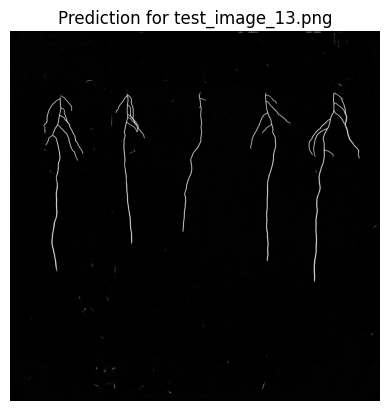

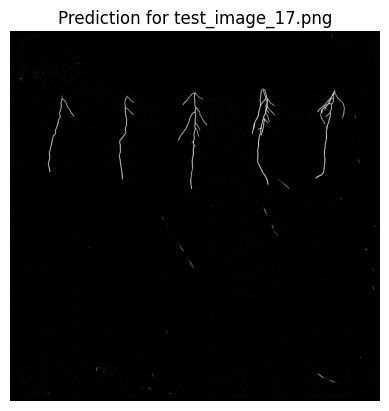

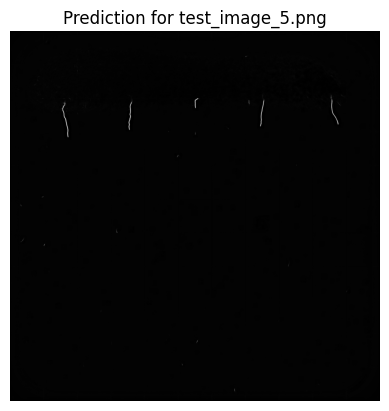

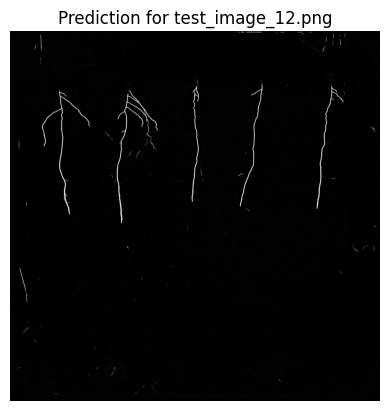

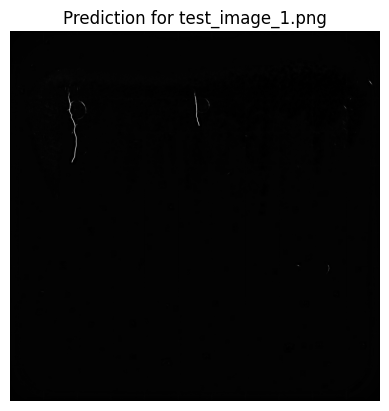

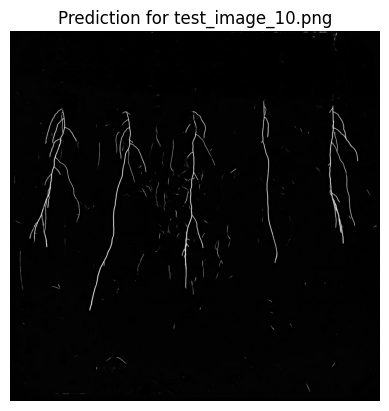

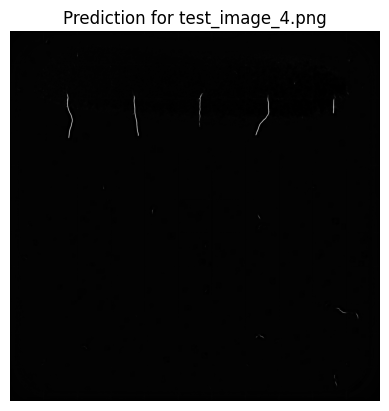

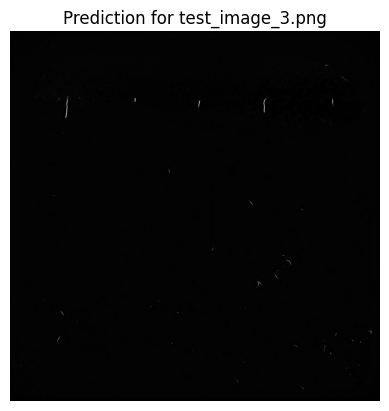

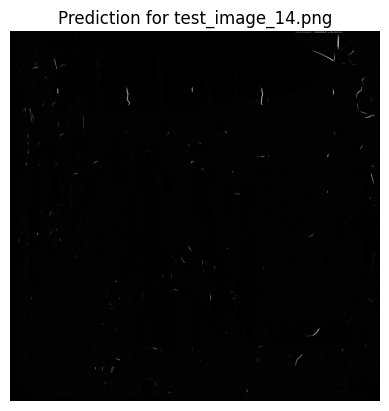

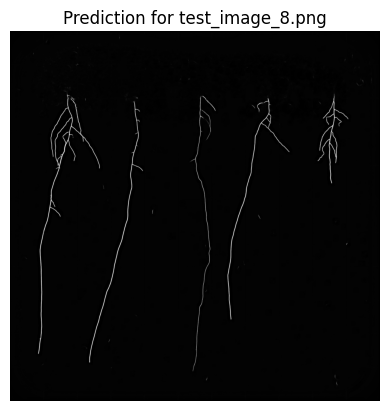

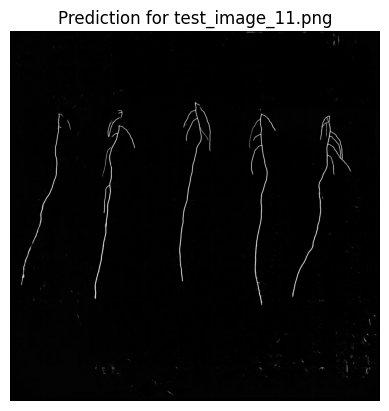

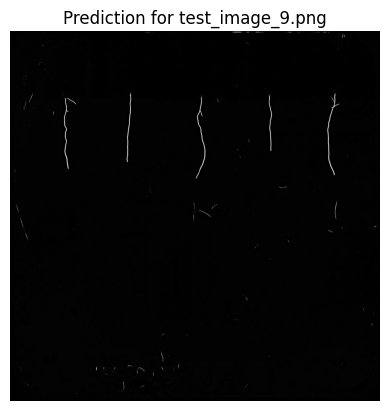

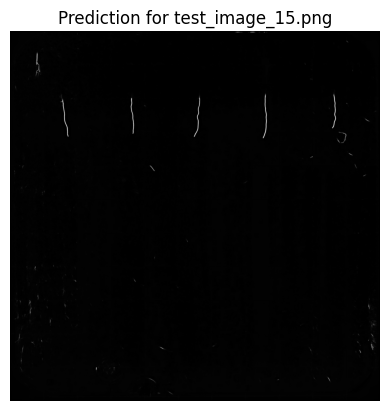

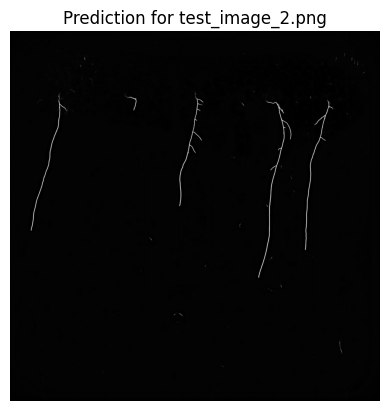

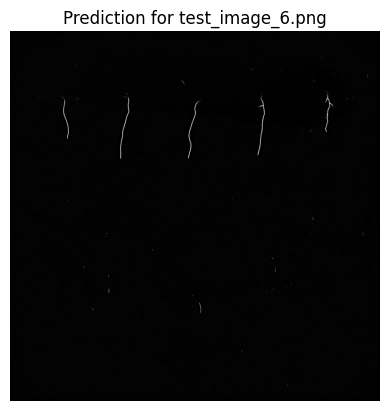

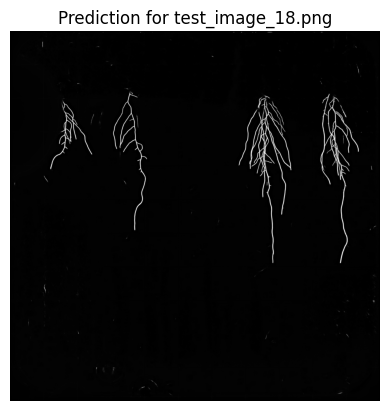

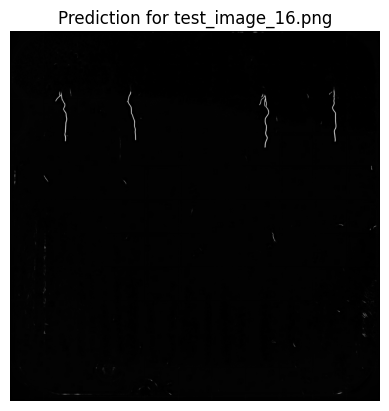

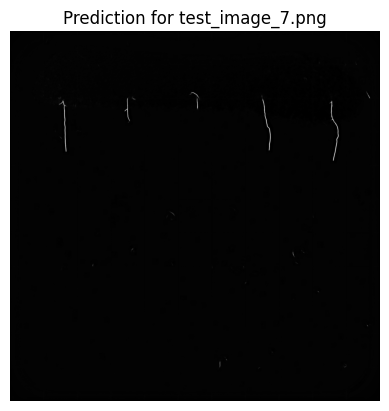

In [14]:

# **Load the model**
model_path = "PetarPaskalev_232725_unet_model_4_256px_82F1.h5"
model = load_model(model_path, custom_objects={"f1": f1})

# **Run predictions**
predictions = []
for filename, patches_normalized in preprocessed_data:
    # Predict on patches
    predicted_patches = model.predict(patches_normalized, batch_size=16)
    
    # Reshape predictions back to original patch grid
    num_patches = int(np.sqrt(predicted_patches.shape[0]))  # Assuming square grid
    predicted_patches = predicted_patches.reshape(num_patches, num_patches, patch_size, patch_size)
    
    # Reconstruct the full image using unpatchify
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    reconstructed_prediction = unpatchify(predicted_patches, petri_dish_padded_shape)
    
    # Store the prediction
    predictions.append((filename, reconstructed_prediction))
    print(f"Prediction completed for {filename}")

# **Visualize predictions**
for filename, predicted_mask in predictions:
    plt.figure(dpi=100)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction for {filename}")
    plt.axis('off')
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Loop through predictions and convert each mask to binary
binary_predictions = []
for filename, predicted_mask in predictions:
    # Convert predicted mask to binary: thresholding at 0.5
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
    
    # Store the binary mask
    binary_predictions.append((filename, binary_mask))

 

  


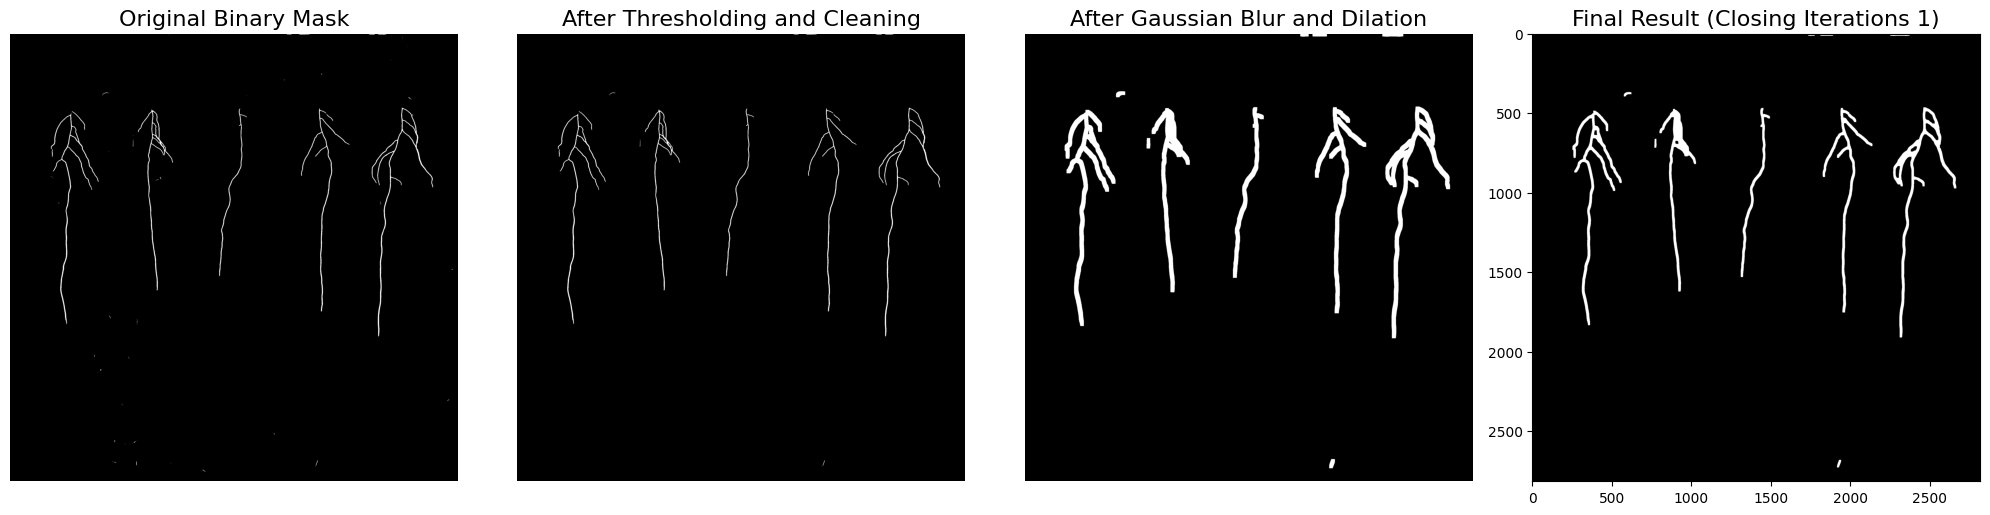

Processed test_image_13.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


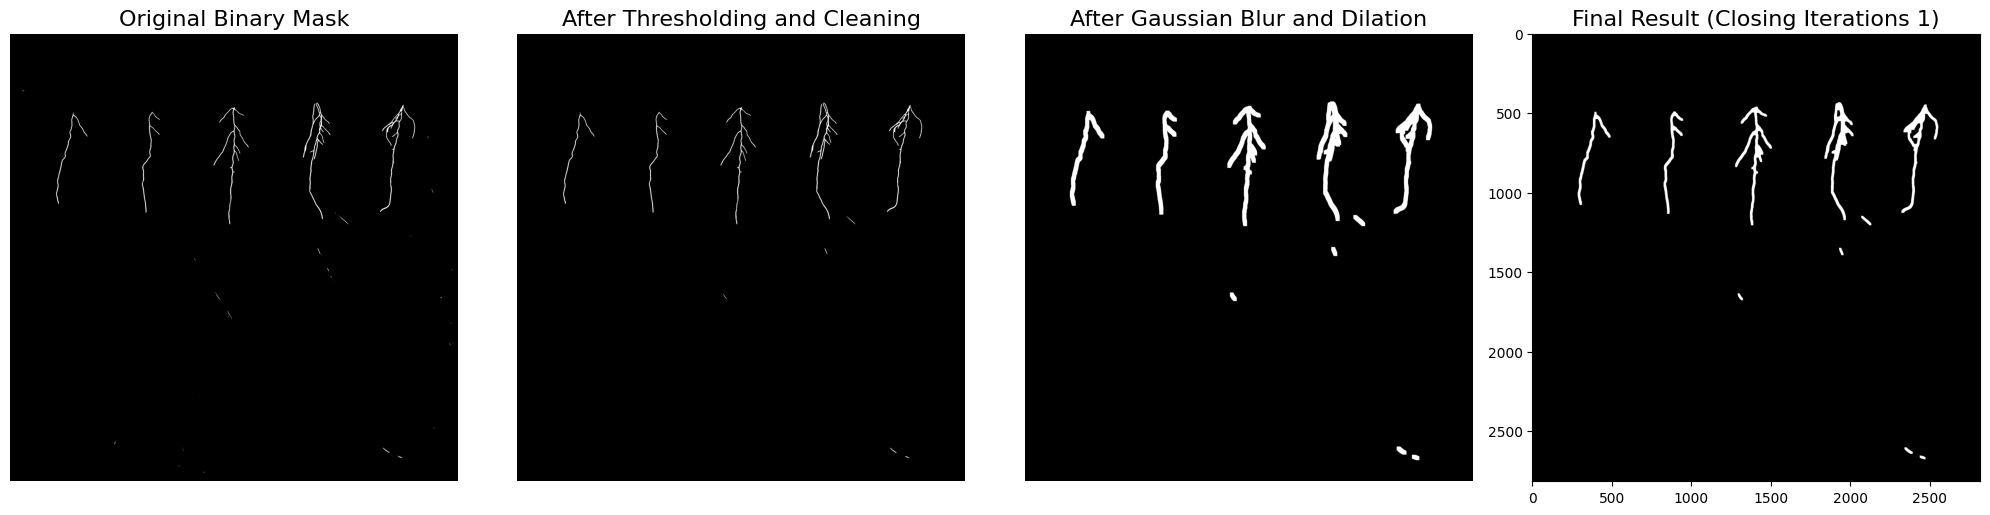

Processed test_image_17.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


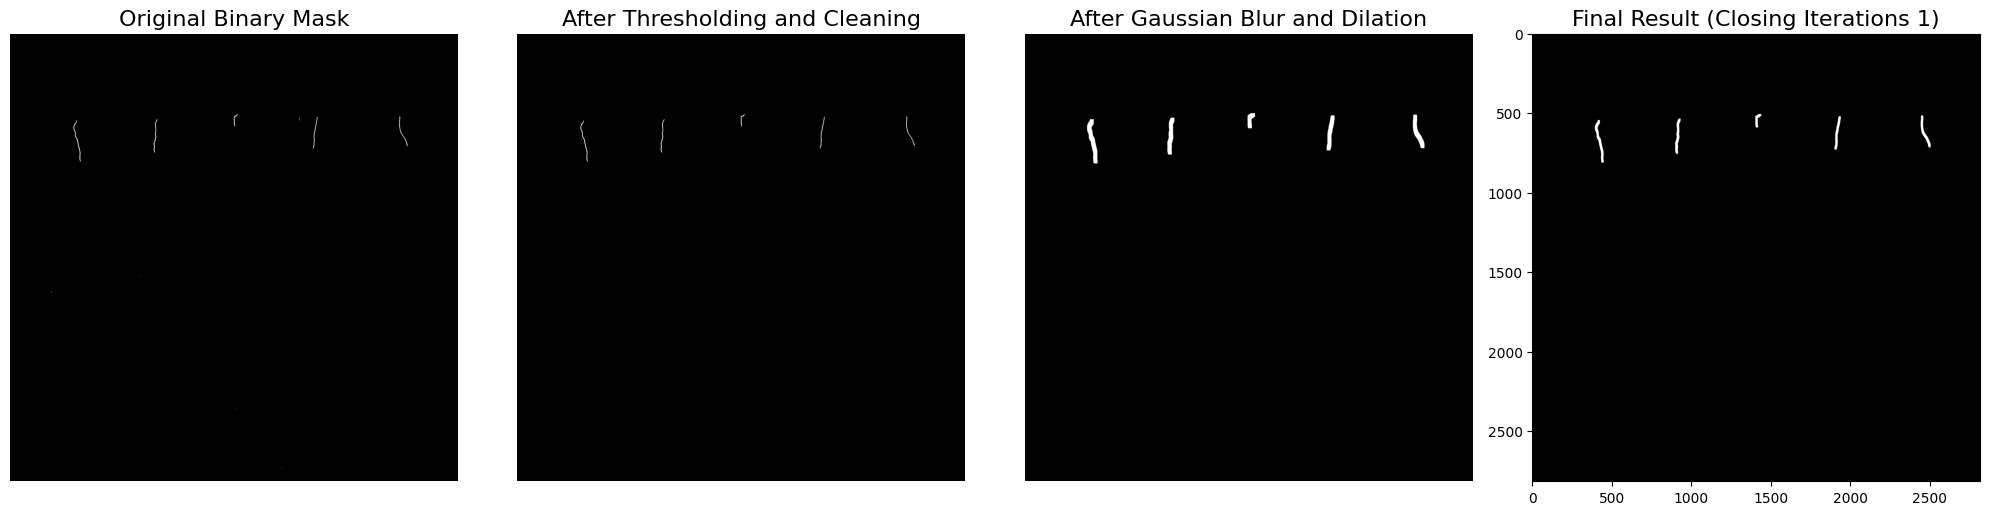

Processed test_image_5.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


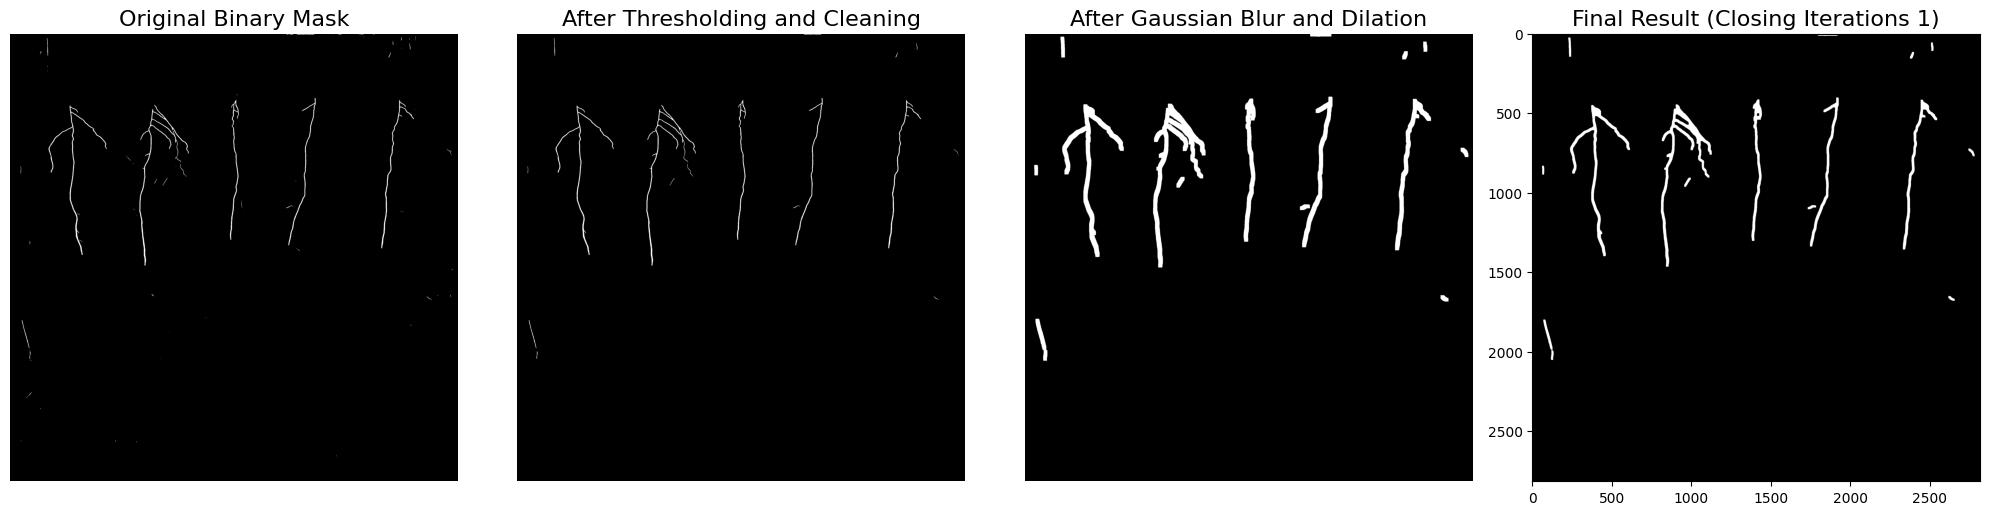

Processed test_image_12.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


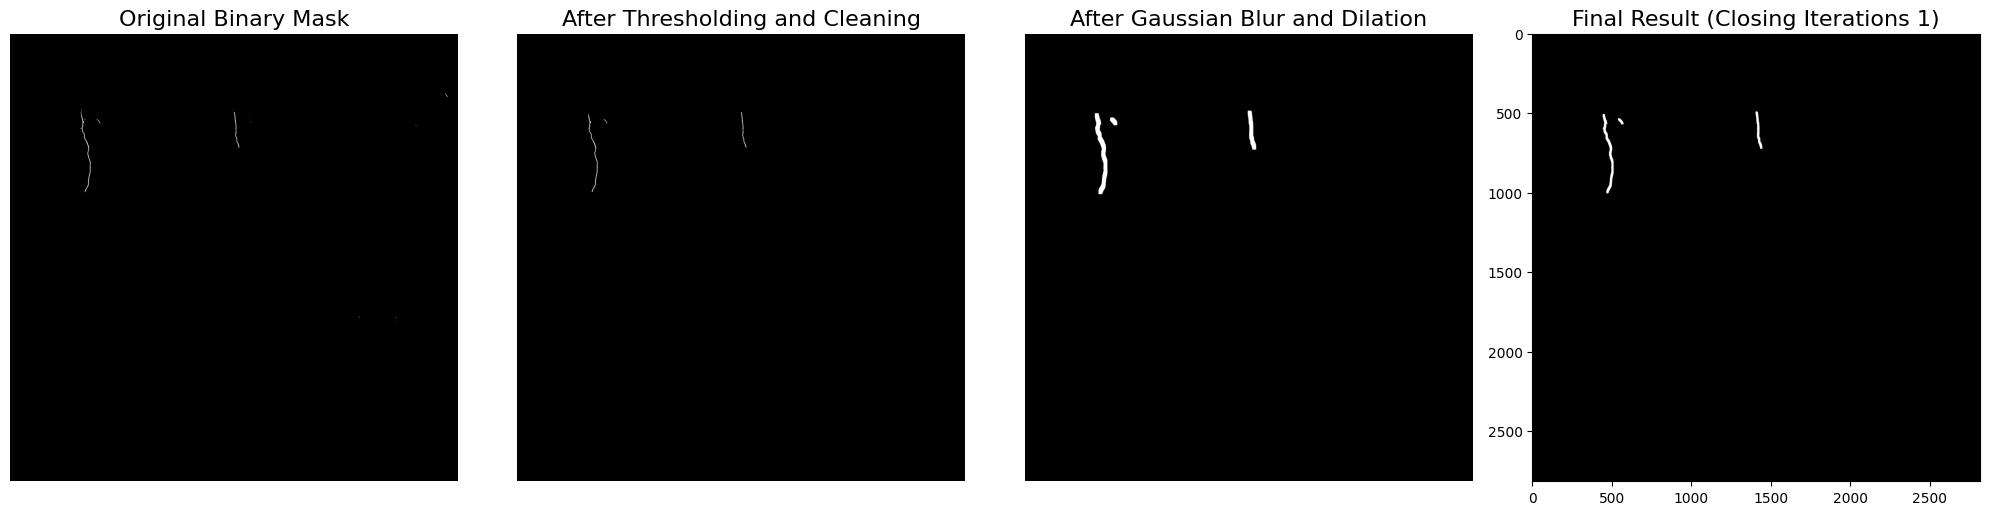

Processed test_image_1.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


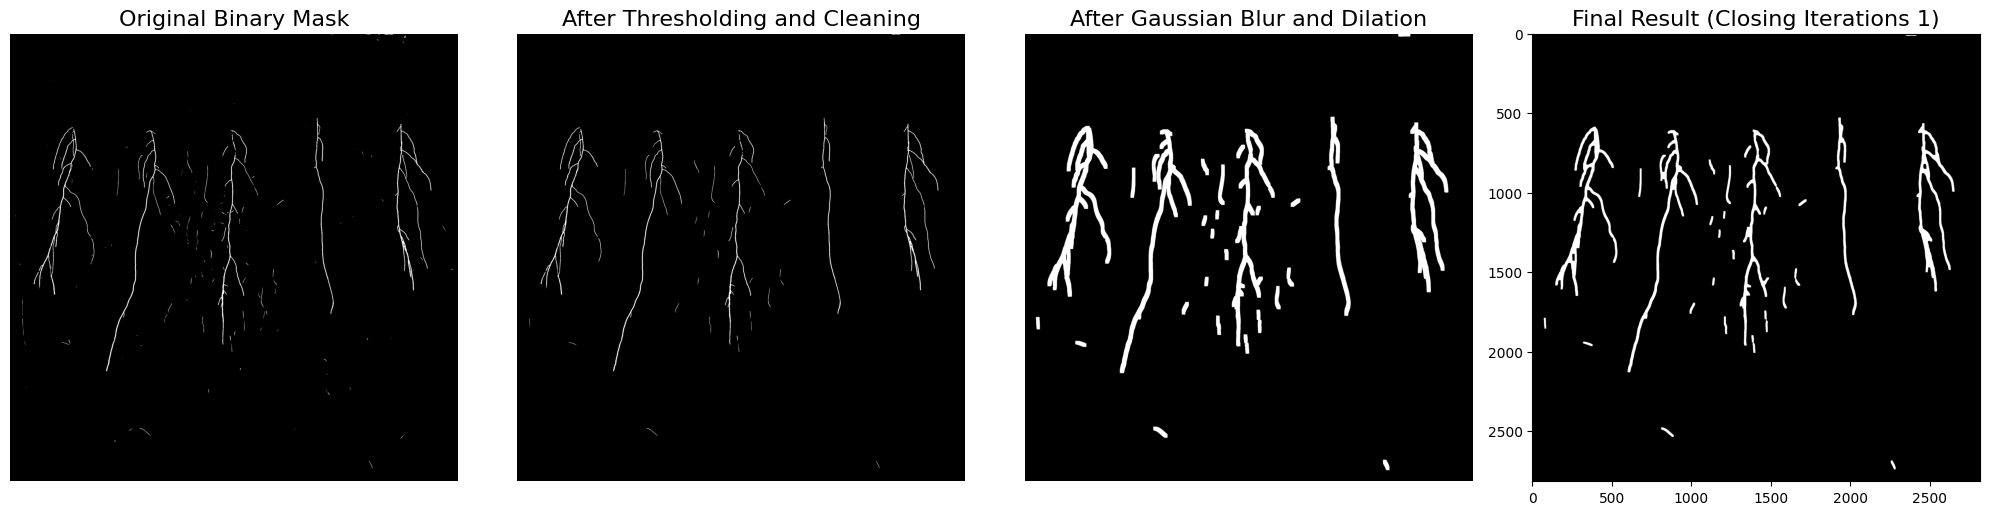

Processed test_image_10.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


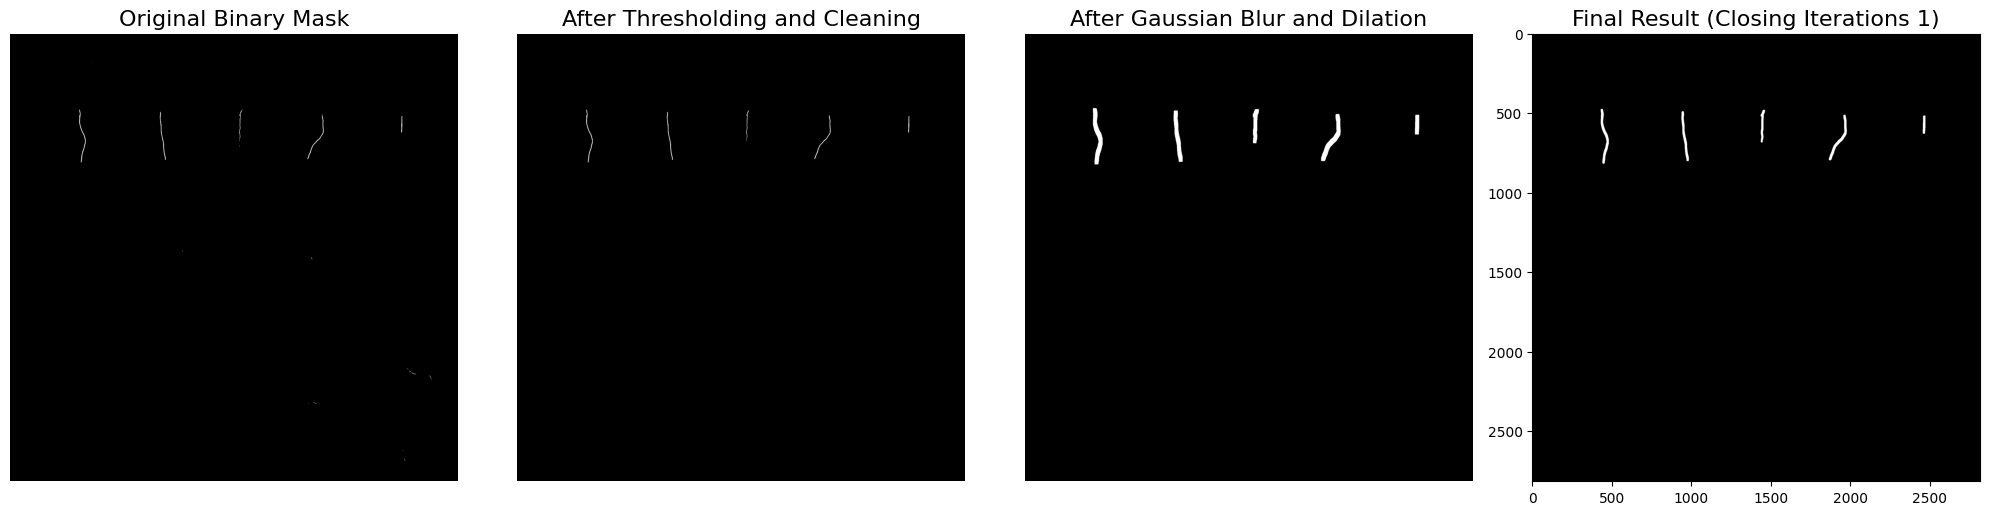

Processed test_image_4.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


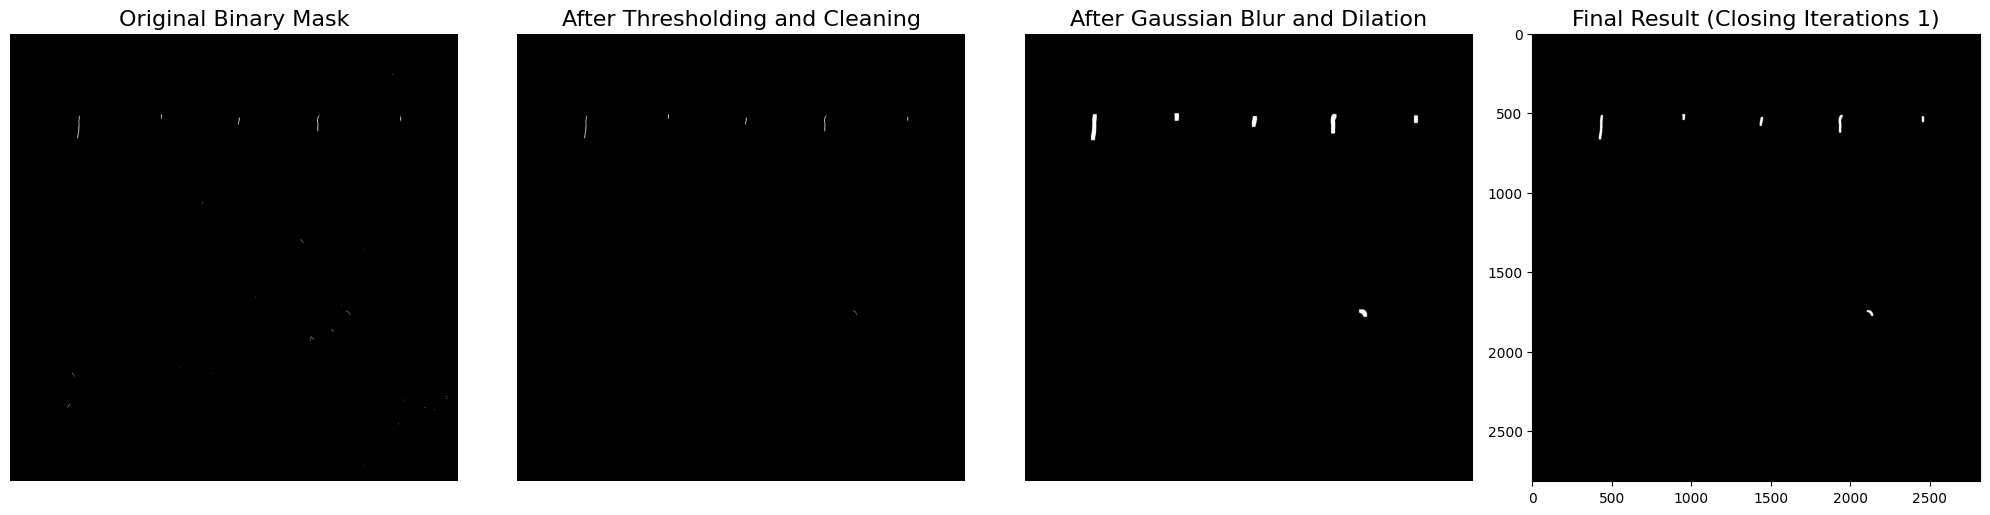

Processed test_image_3.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


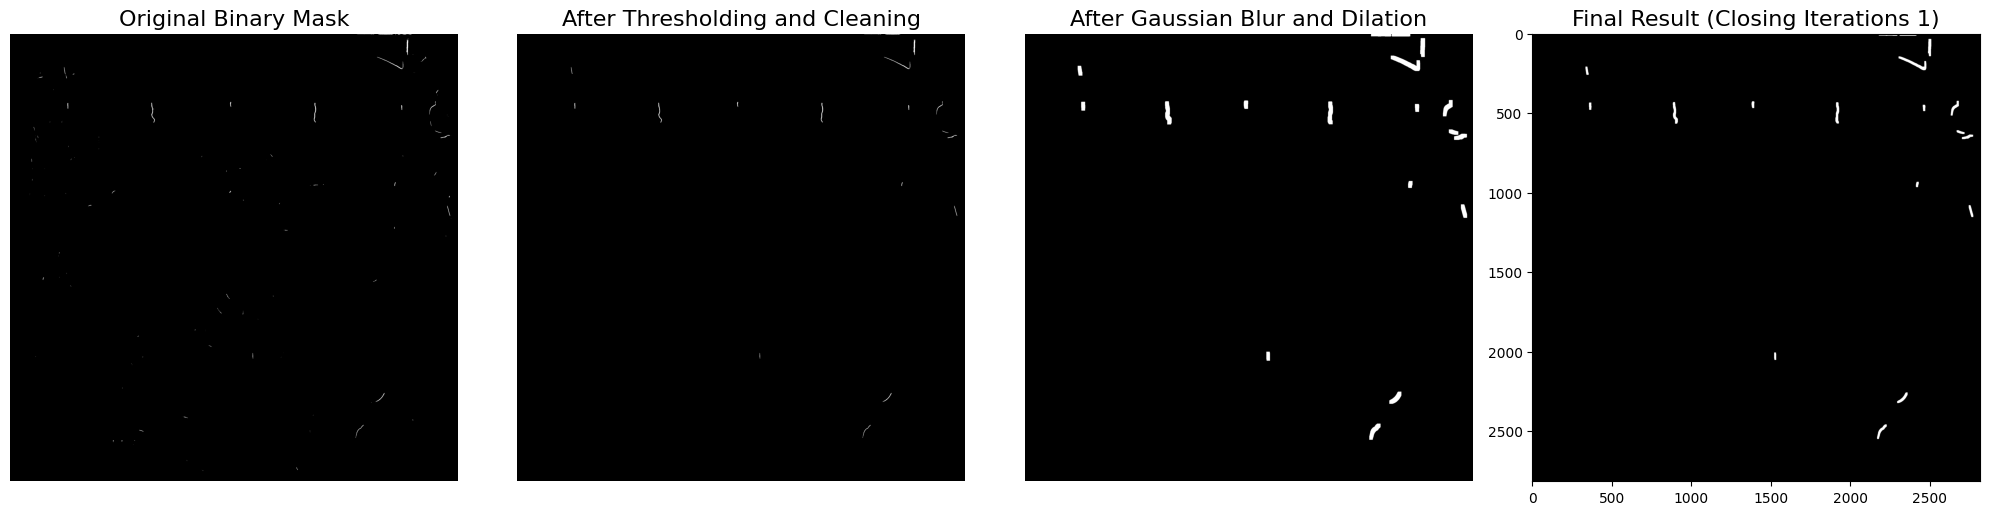

Processed test_image_14.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


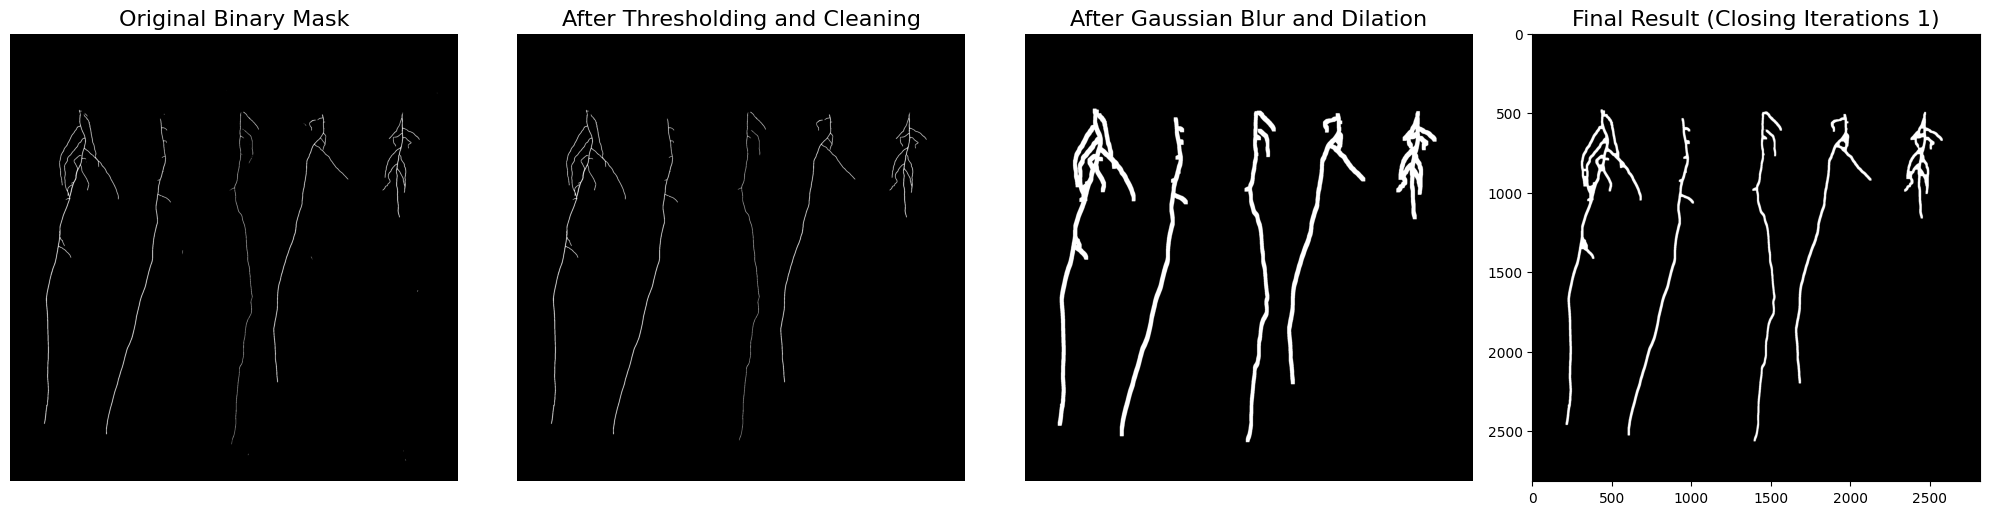

Processed test_image_8.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


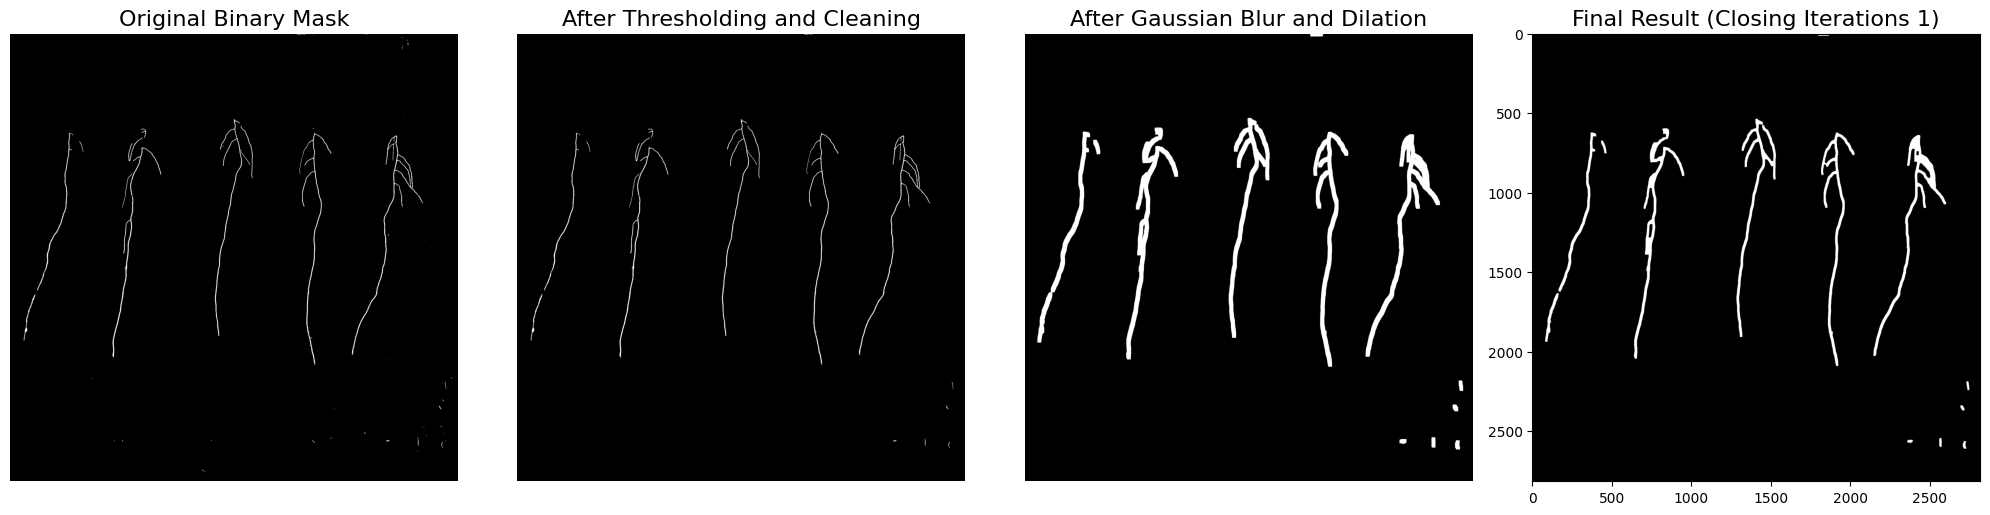

Processed test_image_11.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


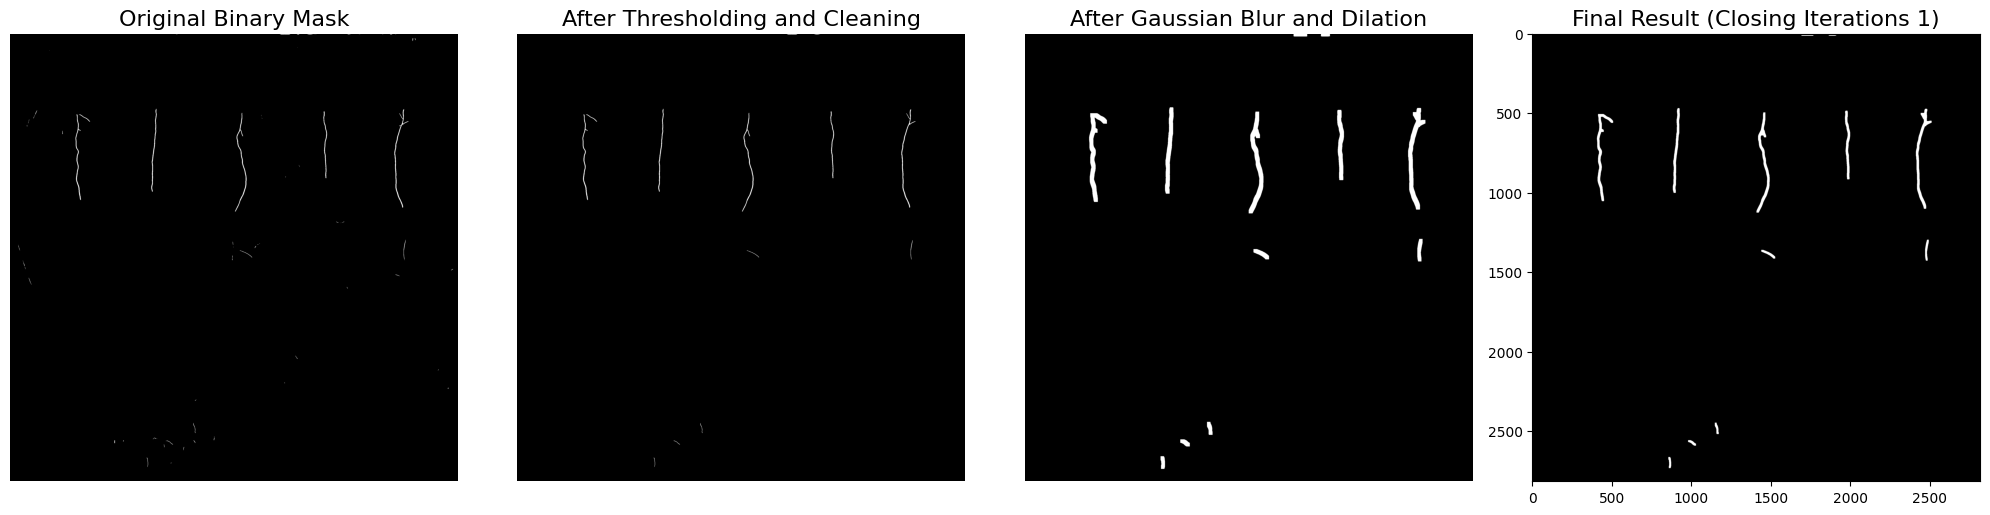

Processed test_image_9.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


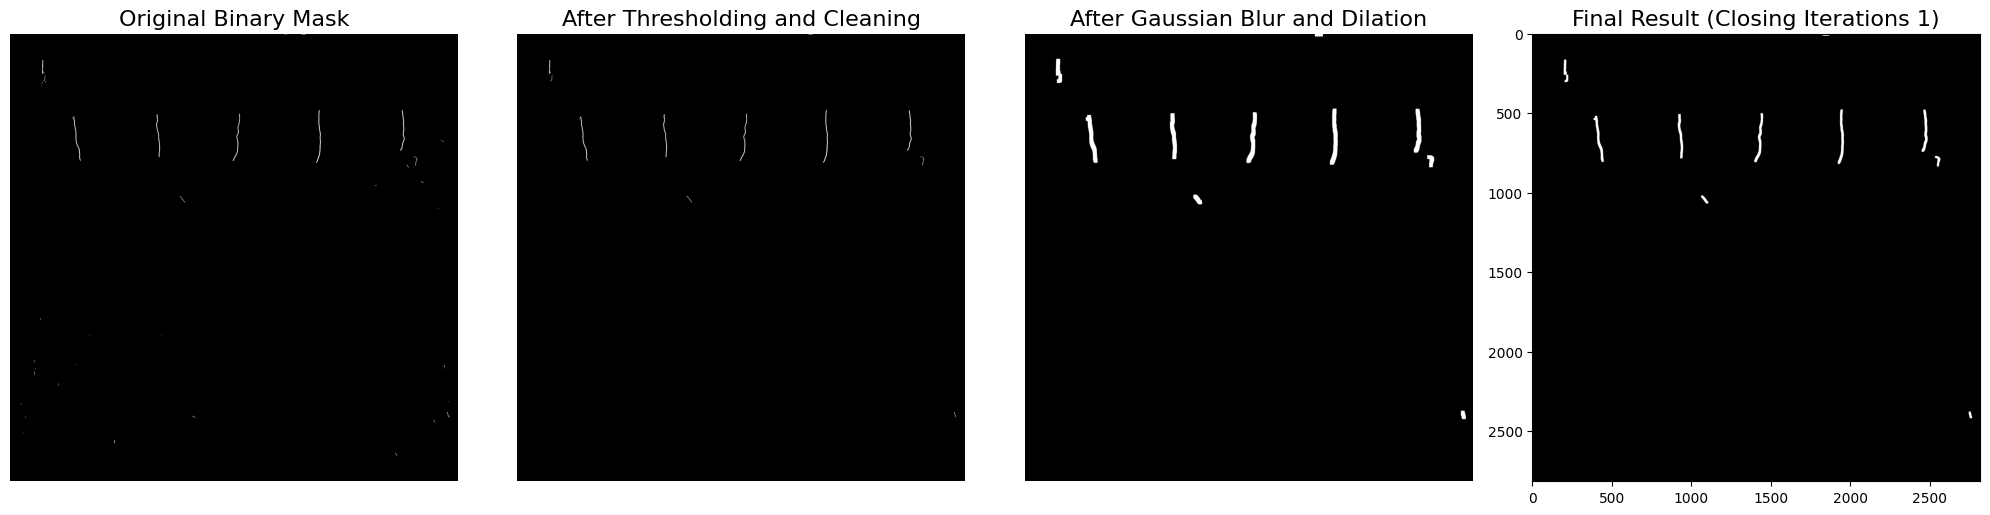

Processed test_image_15.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


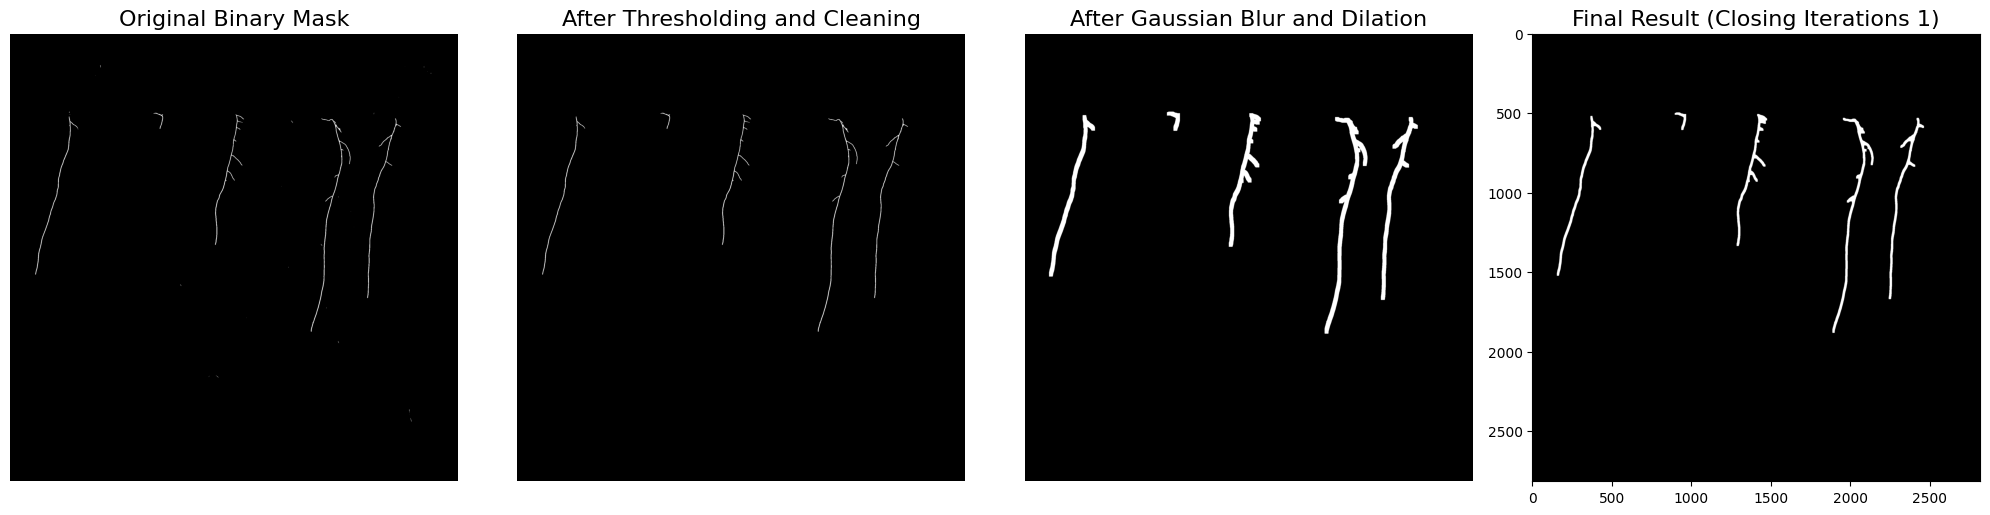

Processed test_image_2.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


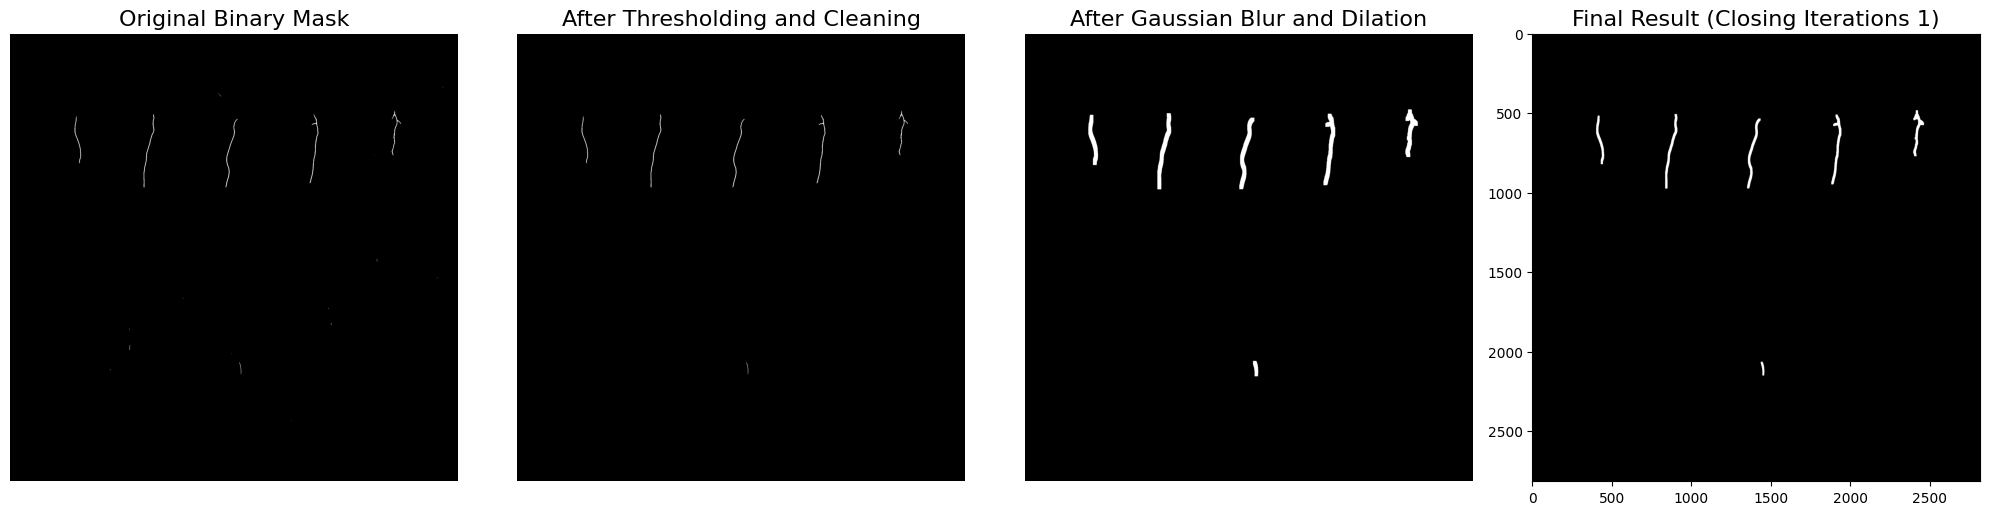

Processed test_image_6.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


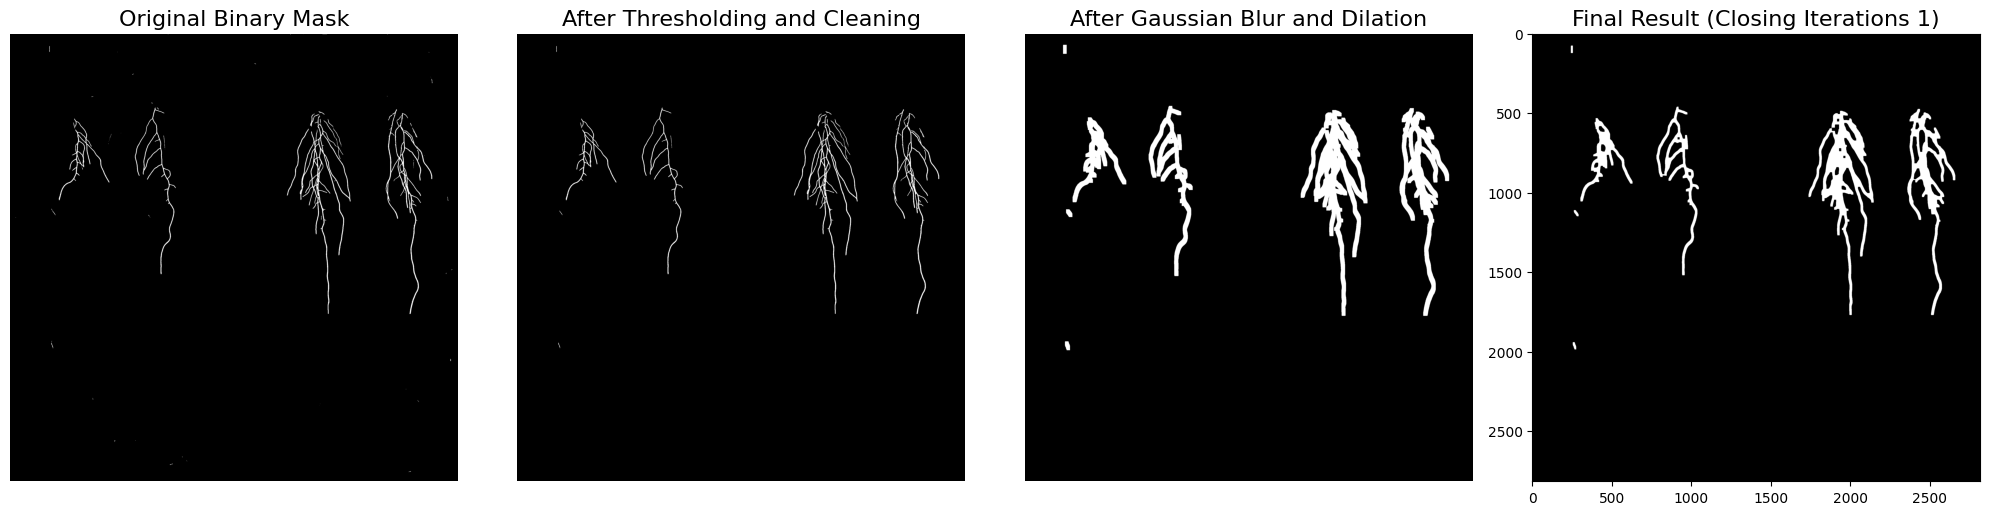

Processed test_image_18.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


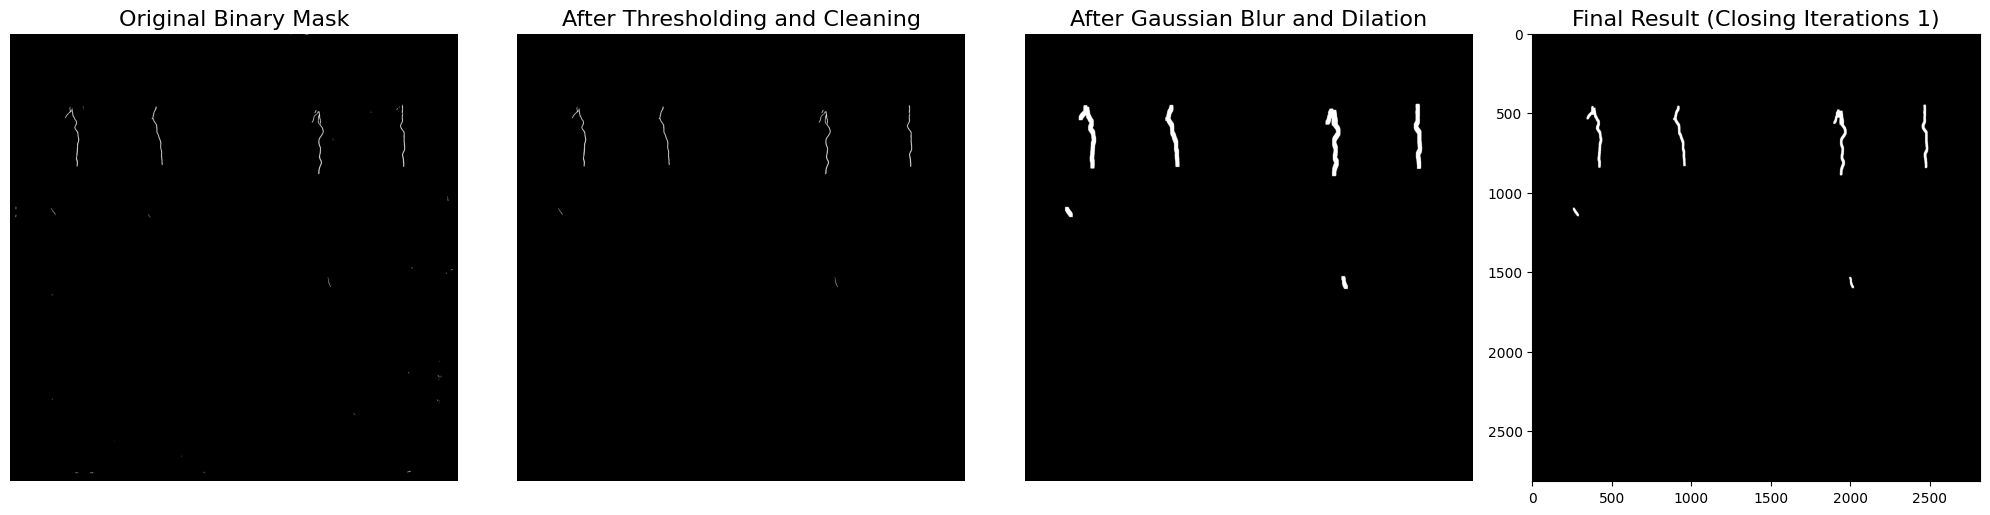

Processed test_image_16.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


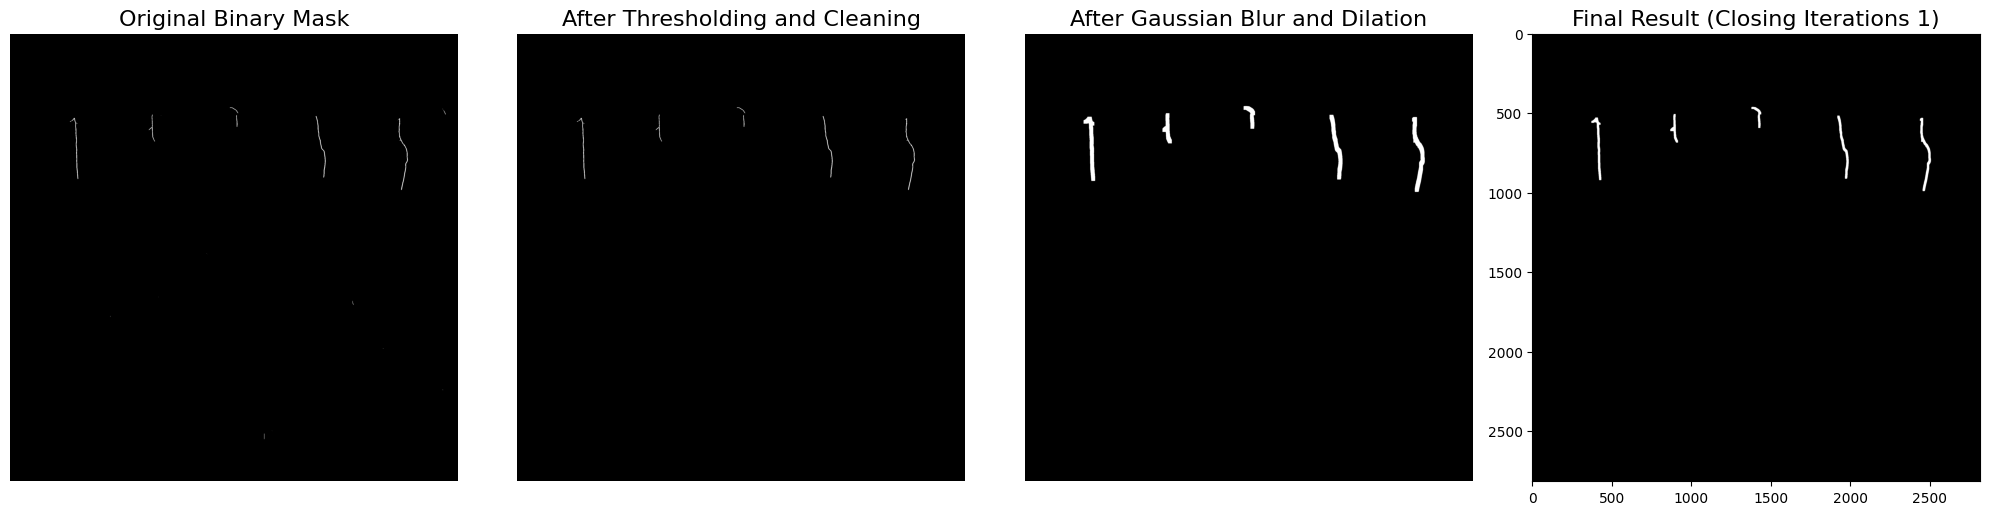

Processed test_image_7.png with Kernel Size = 3, Dilation Iterations = 4, Closing Iterations = 1: Threshold = 0.5, Min Object Size = 250


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# Adjustable parameters
threshold_value = 0.5       # Adjust threshold value
kernel_size = 3           # Set kernel size for morphological operations
closing_iterations = 1    # Number of iterations to apply morphological closing
dilation_iterations = 4   # Number of iterations to apply dilation
min_object_size = 250      # Adjust minimum object size for small object removal


# Process each binary mask in binary_predictions
processed_masks = []
for filename, binary_mask in binary_predictions:
    # Step 1: Apply thresholding
    _, thresholded_mask = cv2.threshold(binary_mask, threshold_value, 255, cv2.THRESH_BINARY)

    # Step 2: Remove small objects immediately after thresholding
    binary_mask_boolean = thresholded_mask > 0  # Convert to boolean (True for object pixels)
    cleaned_mask_after_thresholding = remove_small_objects(binary_mask_boolean, min_size=80)
    cleaned_mask_after_thresholding = (cleaned_mask_after_thresholding * 255).astype(np.uint8)  # Convert back to uint8

    # Step 3: Apply dilation for a specified number of iterations to connect components
    dilation_kernel = cleaned_mask_after_thresholding
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    dilated_mask = cleaned_mask_after_thresholding
    for i in range(dilation_iterations):
        dilated_mask = cv2.dilate(dilated_mask, dilation_kernel, iterations=1)

    

    final_connected_mask = None
    for i in range(closing_iterations):
        # Step 5: Apply morphological closing with the same kernel size for multiple iterations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        closed_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel, iterations=i+1)

        # Step 6: Remove small objects after morphological closing
        binary_mask_boolean = closed_mask > 0  # Convert to boolean (True for object pixels)
        cleaned_mask = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
        final_connected_mask = (cleaned_mask * 255).astype(np.uint8)  # Convert back to uint8

        # Store the result of the last iteration
        if i == closing_iterations - 1:
            processed_masks.append((filename, final_connected_mask))

    # Step 7: Perform connected components analysis before post-processing
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_connected_mask, connectivity=8)

    # Reconstruct the mask to retain only valid connected components
    connected_components_mask = np.zeros_like(final_connected_mask)
    for label in range(1, num_labels):  # Start from 1 to skip the background label
        if stats[label, cv2.CC_STAT_AREA] >= min_object_size:
            connected_components_mask[labels == label] = 255

    final_filtered_mask = connected_components_mask

    # Step 8: Post-processing with dilation followed by erosion (opening)
    post_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    post_dilated_mask = cv2.dilate(final_filtered_mask, post_dilation_kernel, iterations=1)
    post_eroded_mask = cv2.erode(post_dilated_mask, post_dilation_kernel, iterations=6)

    # Update the final cleaned mask after post-processing
    final_processed_mask = post_eroded_mask

    # Plot final result only
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.title("Original Binary Mask", fontsize=16)
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("After Thresholding and Cleaning", fontsize=16)
    plt.imshow(cleaned_mask_after_thresholding, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("After Gaussian Blur and Dilation", fontsize=16)
    plt.imshow(dilated_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(f"Final Result (Closing Iterations {closing_iterations})", fontsize=16)
    plt.imshow(final_processed_mask, cmap='gray')
    plt.axis('on')

    plt.tight_layout()
    plt.show()

    print(f"Processed {filename} with Kernel Size = {kernel_size}, Dilation Iterations = {dilation_iterations}, Closing Iterations = {closing_iterations}: Threshold = {threshold_value}, Min Object Size = {min_object_size}")


Filename: test_image_13.png | Number of connected components: 11


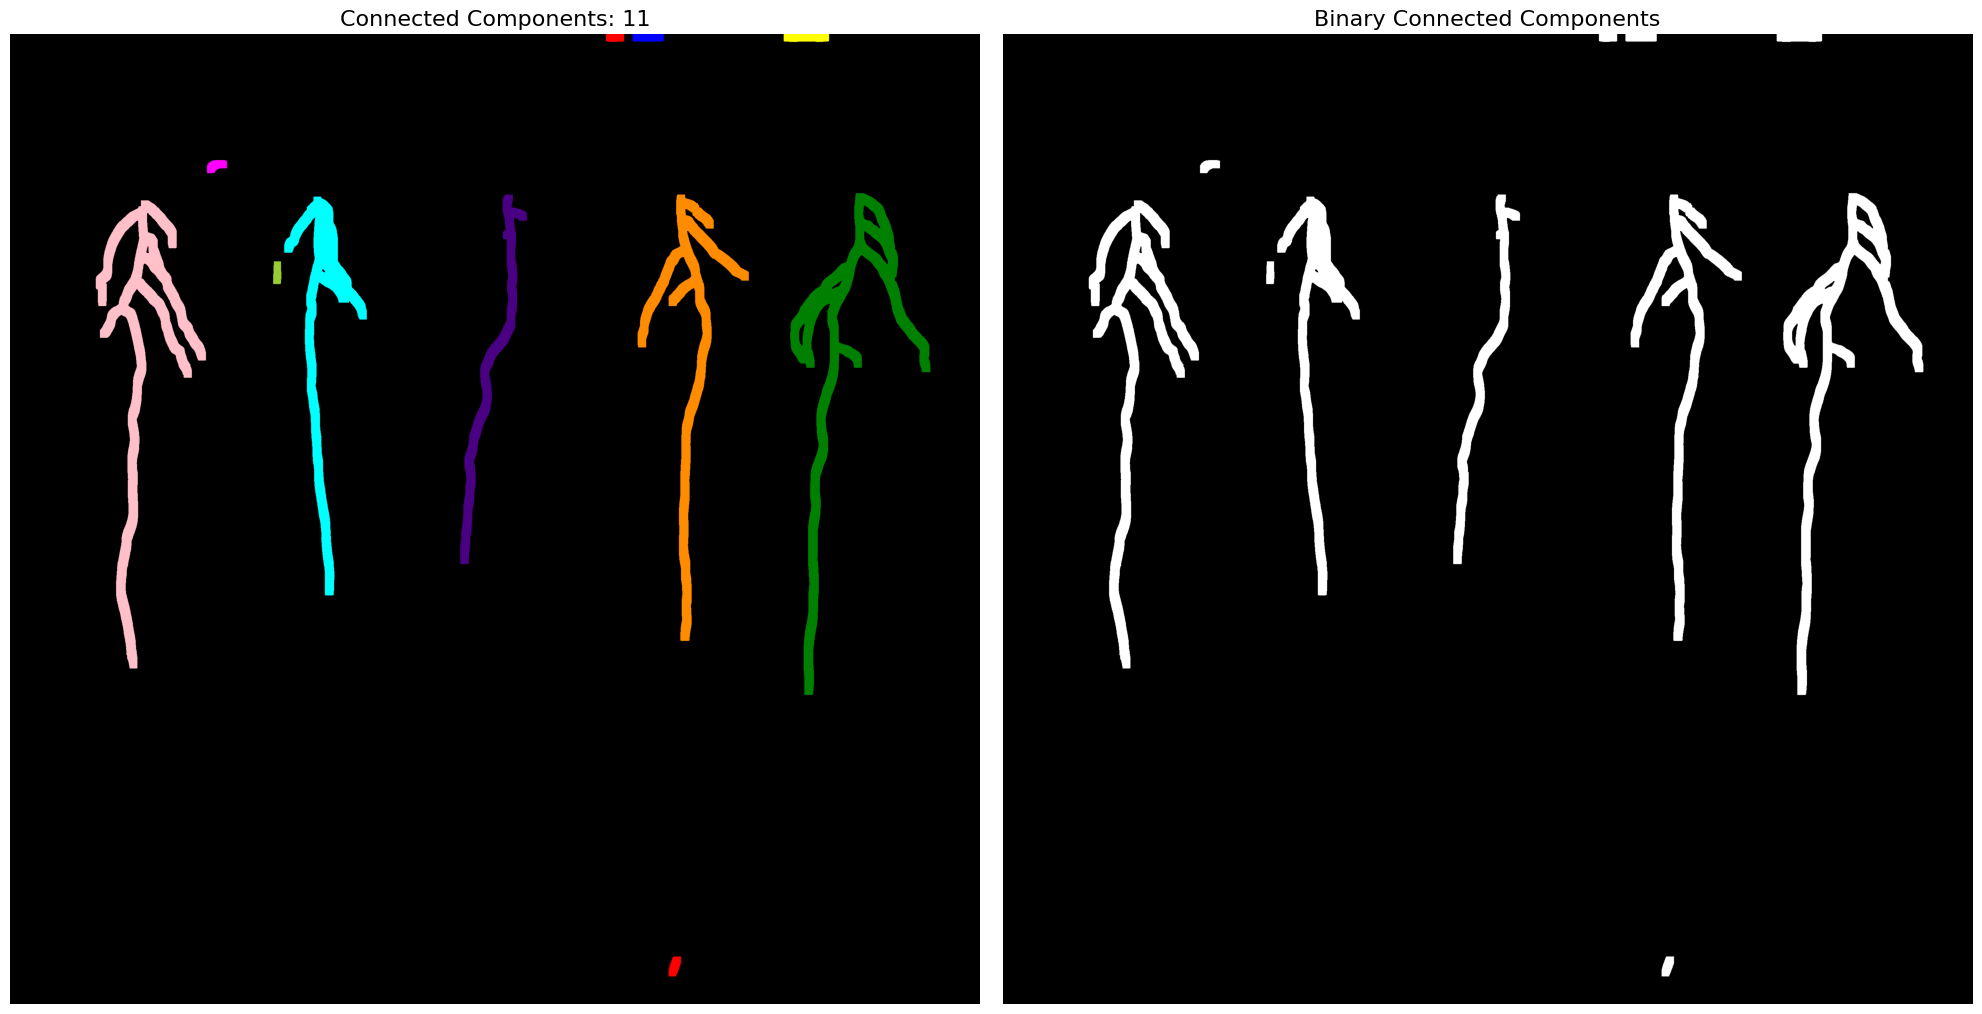

Filename: test_image_17.png | Number of connected components: 10


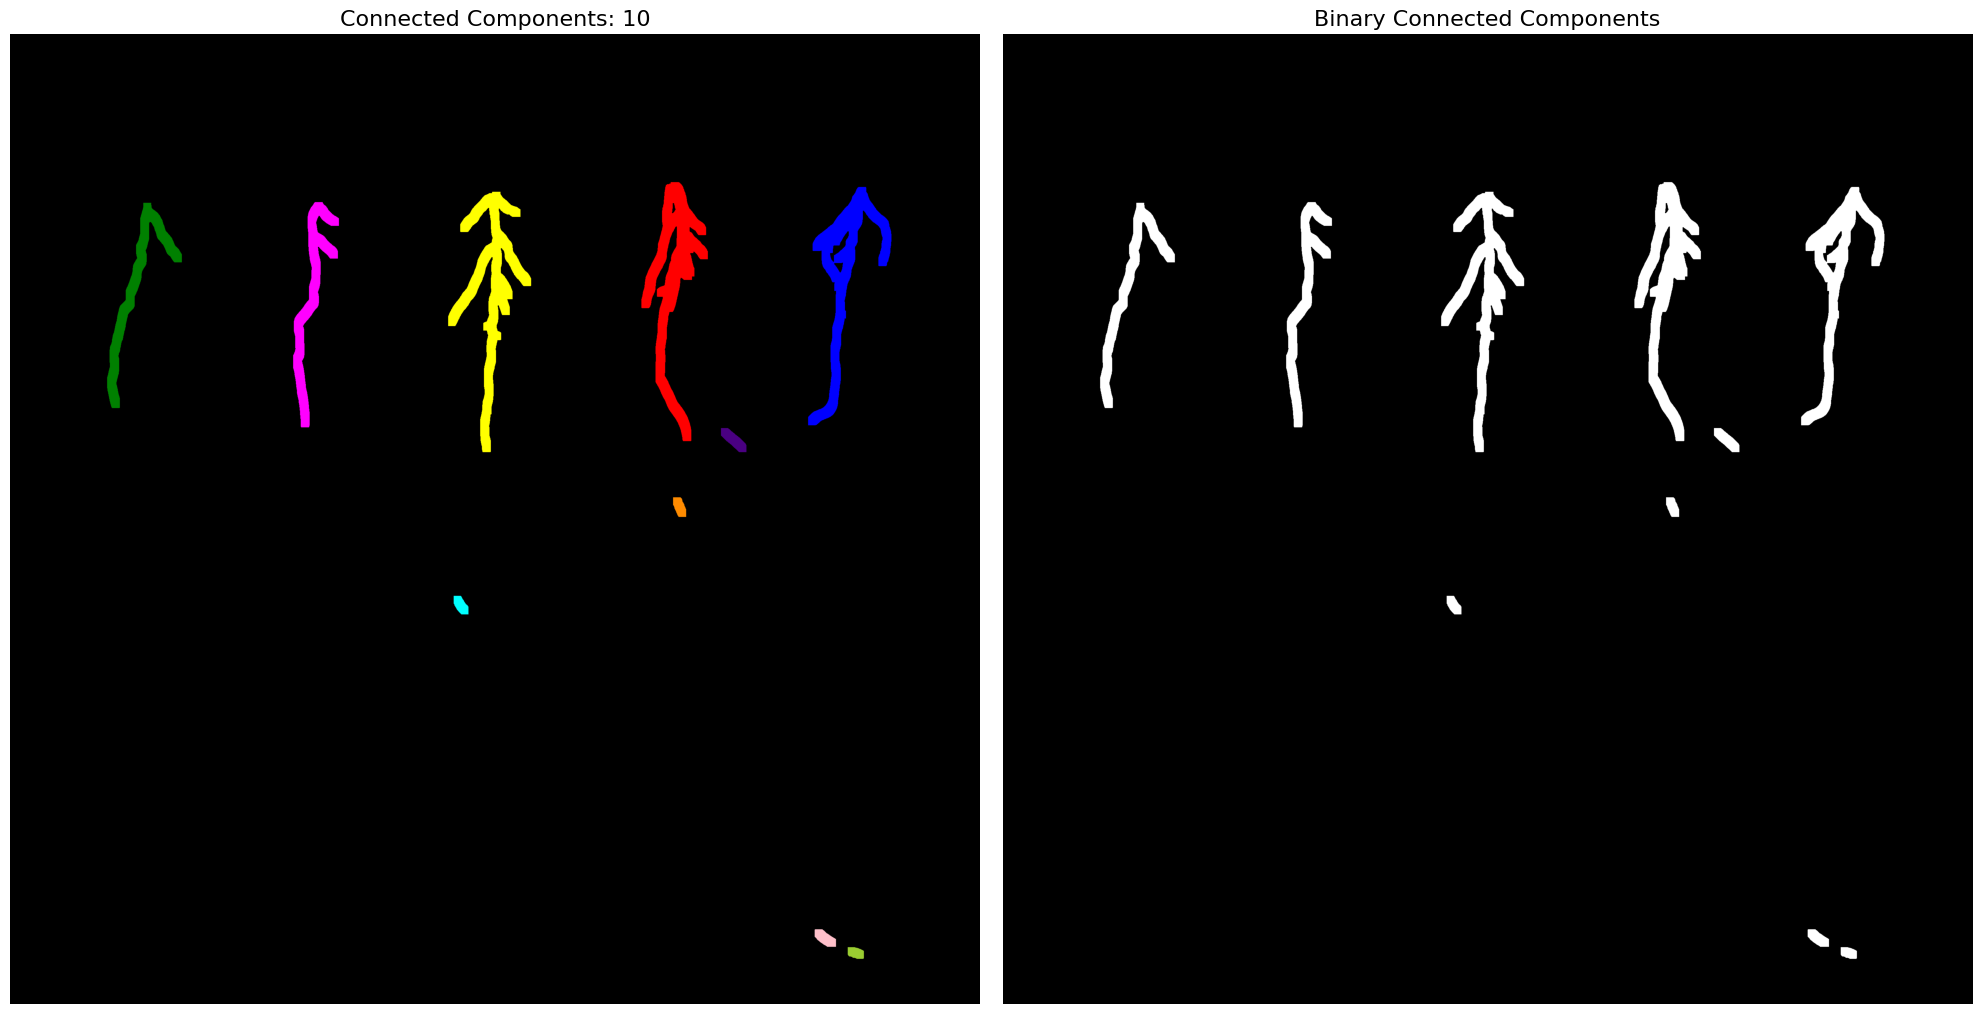

Filename: test_image_5.png | Number of connected components: 5


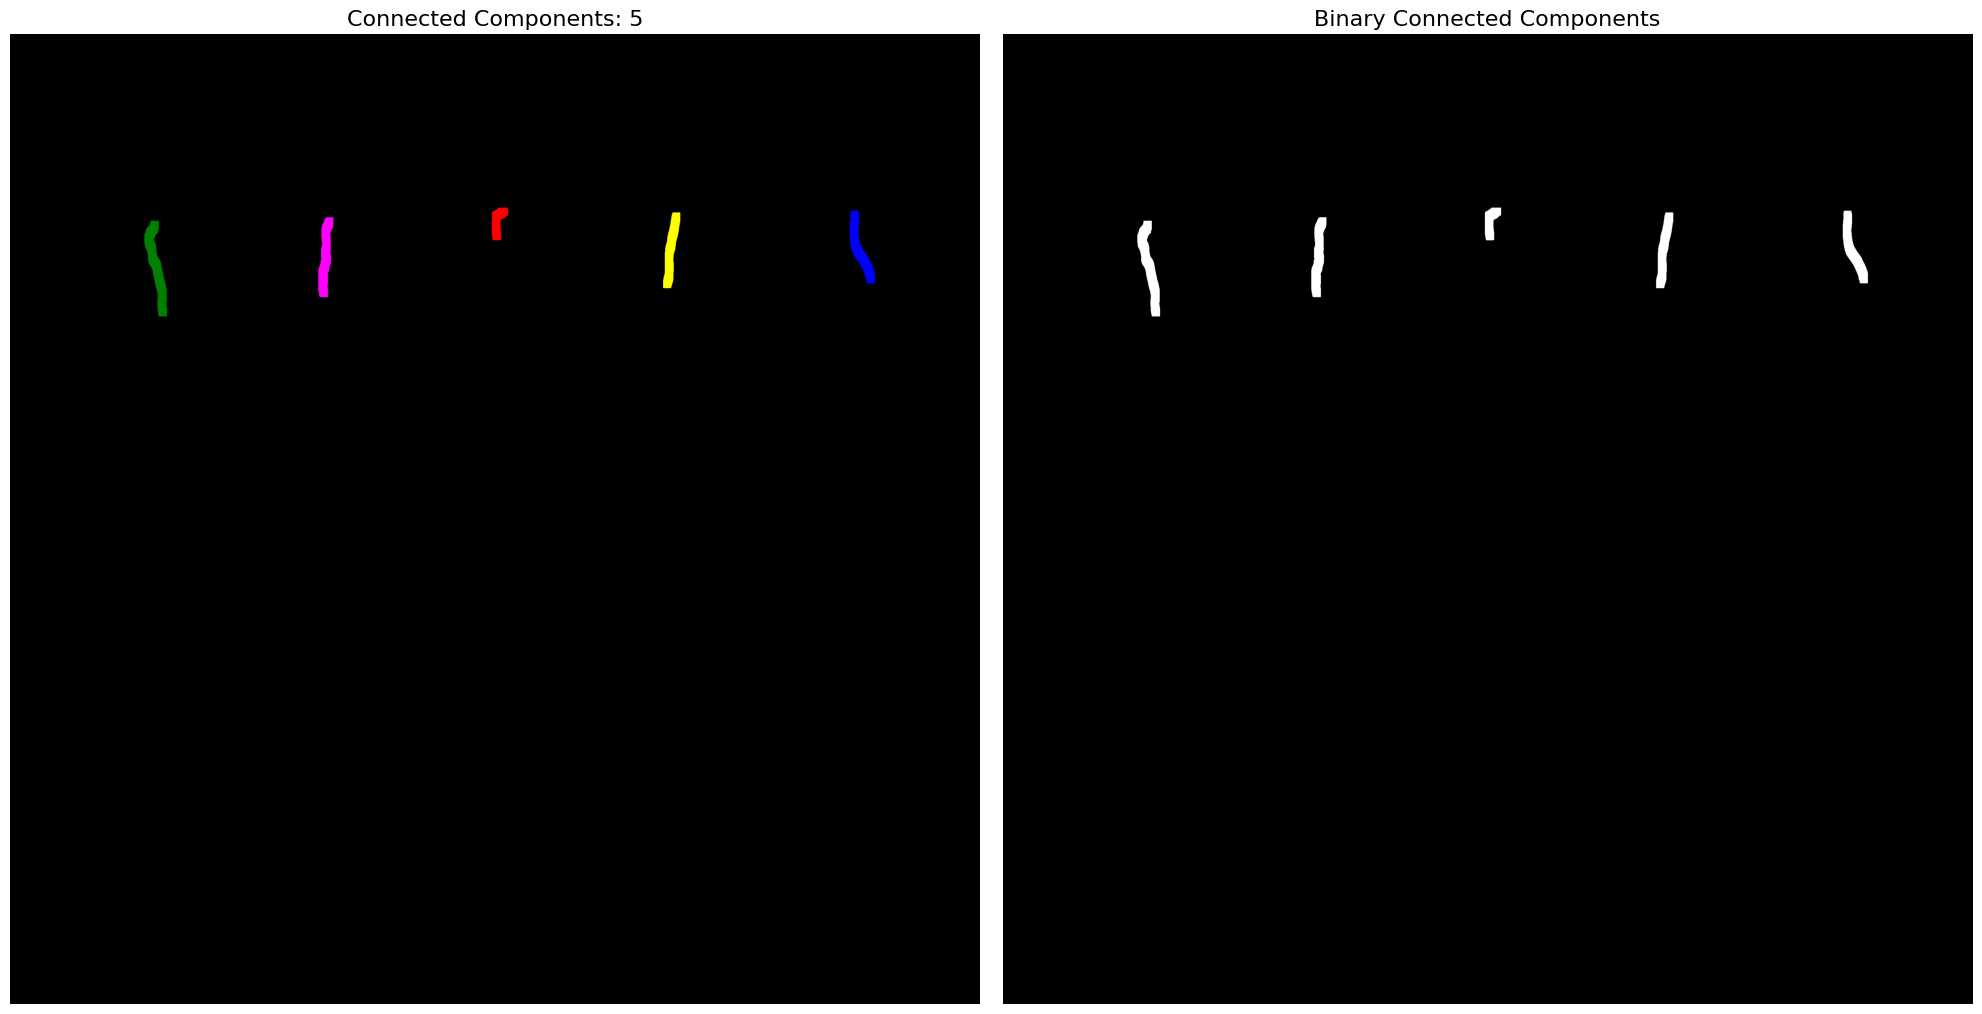

Filename: test_image_12.png | Number of connected components: 15


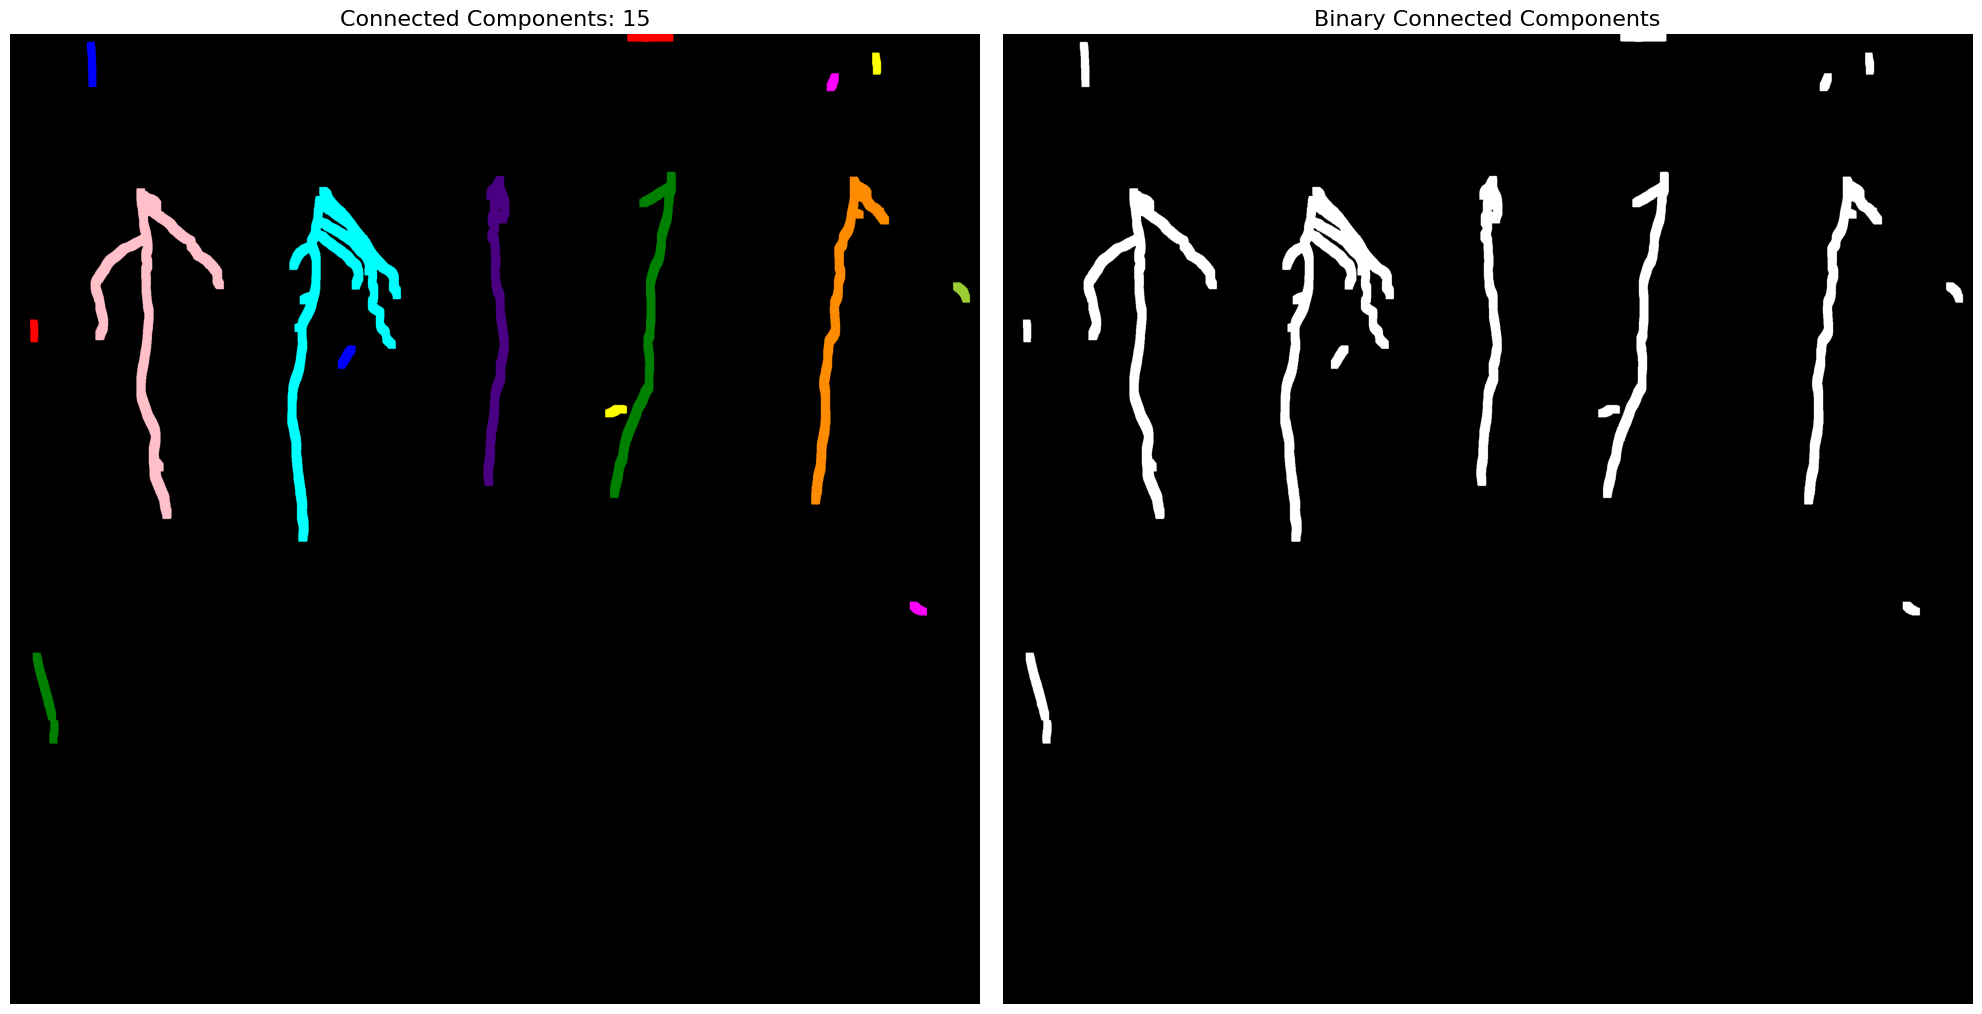

Filename: test_image_1.png | Number of connected components: 3


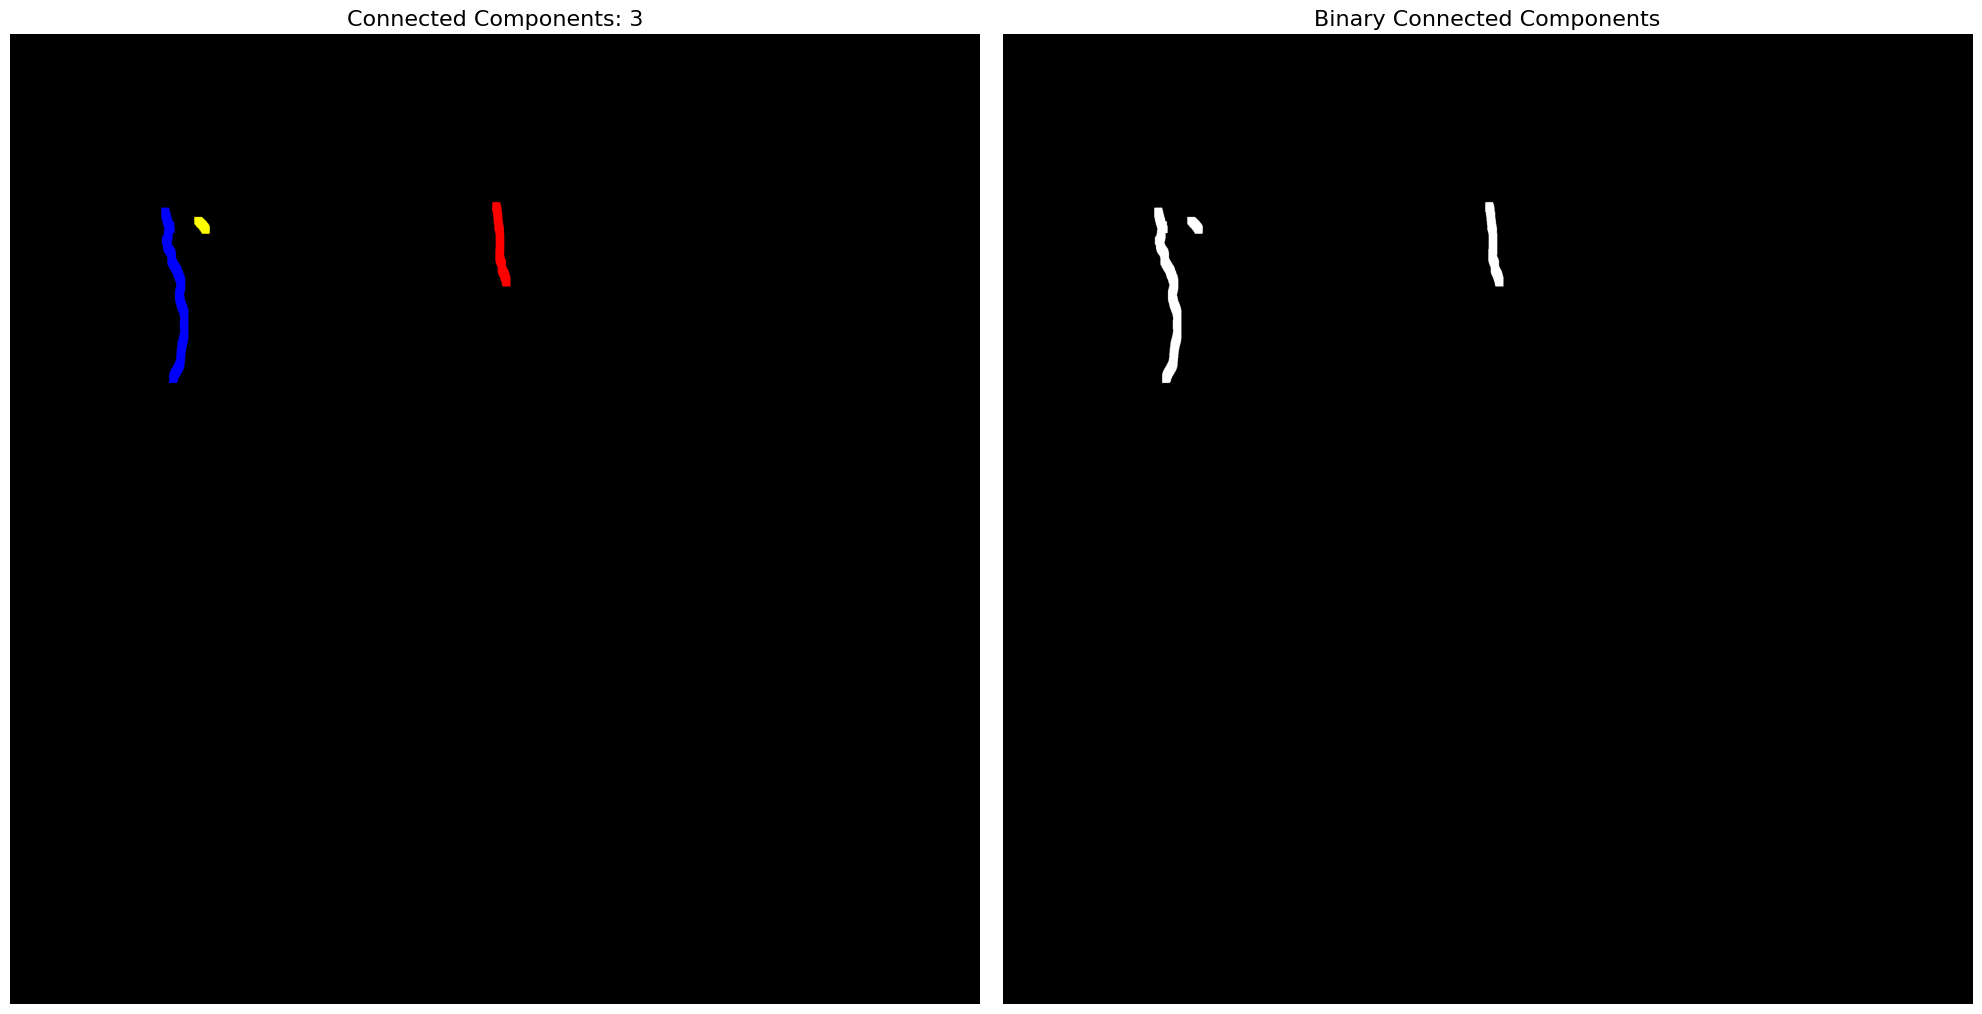

Filename: test_image_10.png | Number of connected components: 27


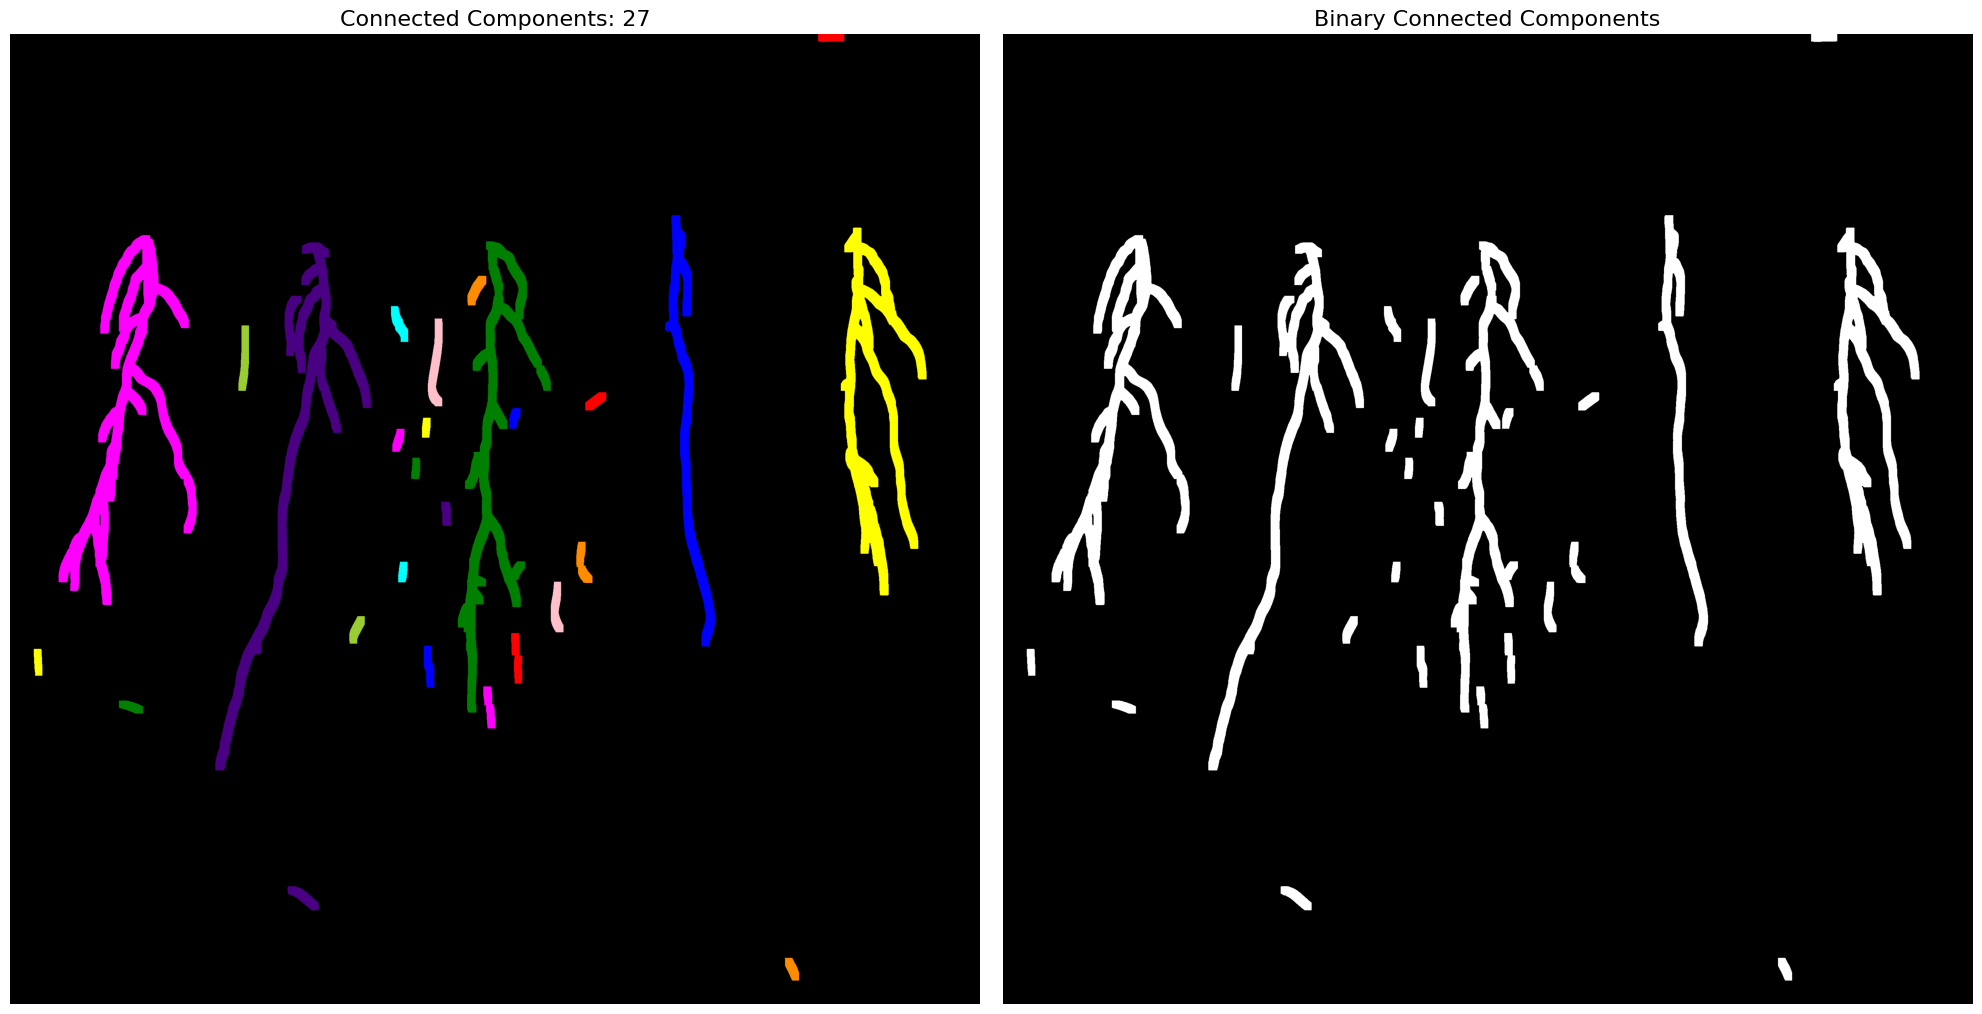

Filename: test_image_4.png | Number of connected components: 5


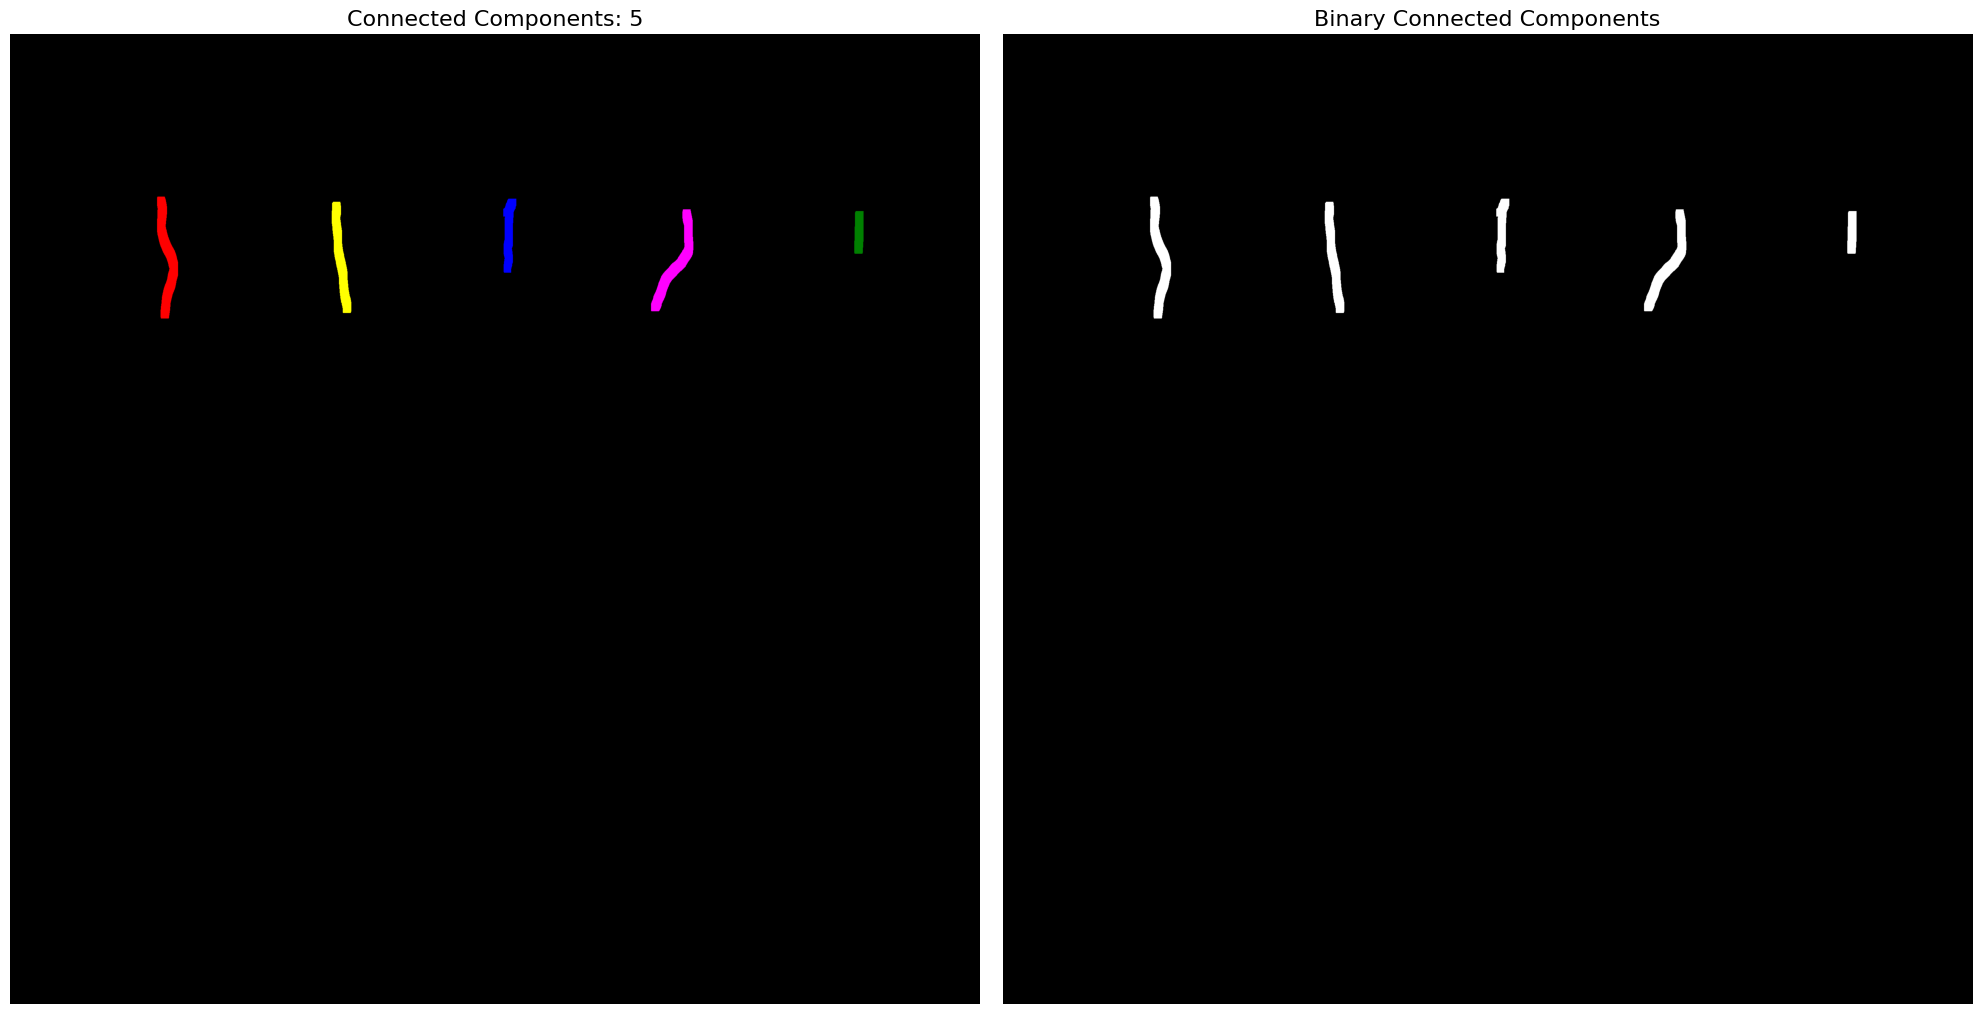

Filename: test_image_3.png | Number of connected components: 6


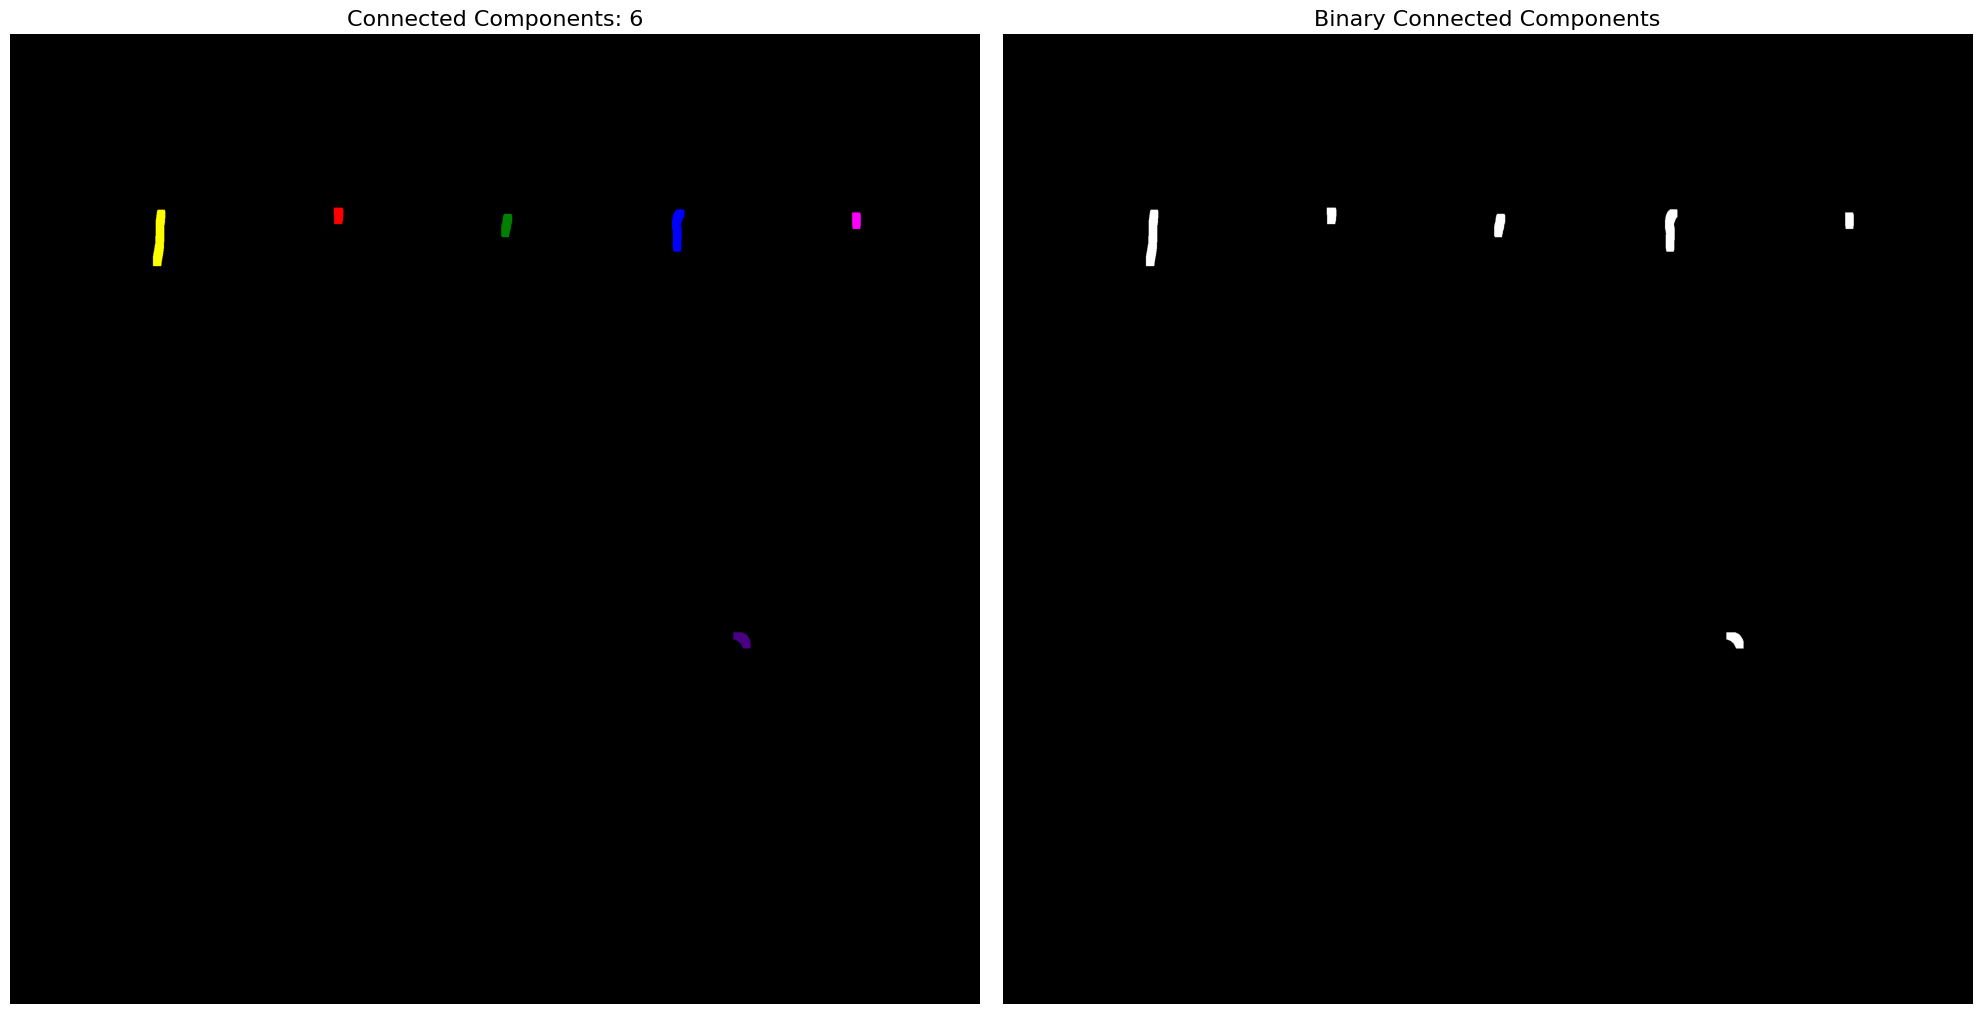

Filename: test_image_14.png | Number of connected components: 18


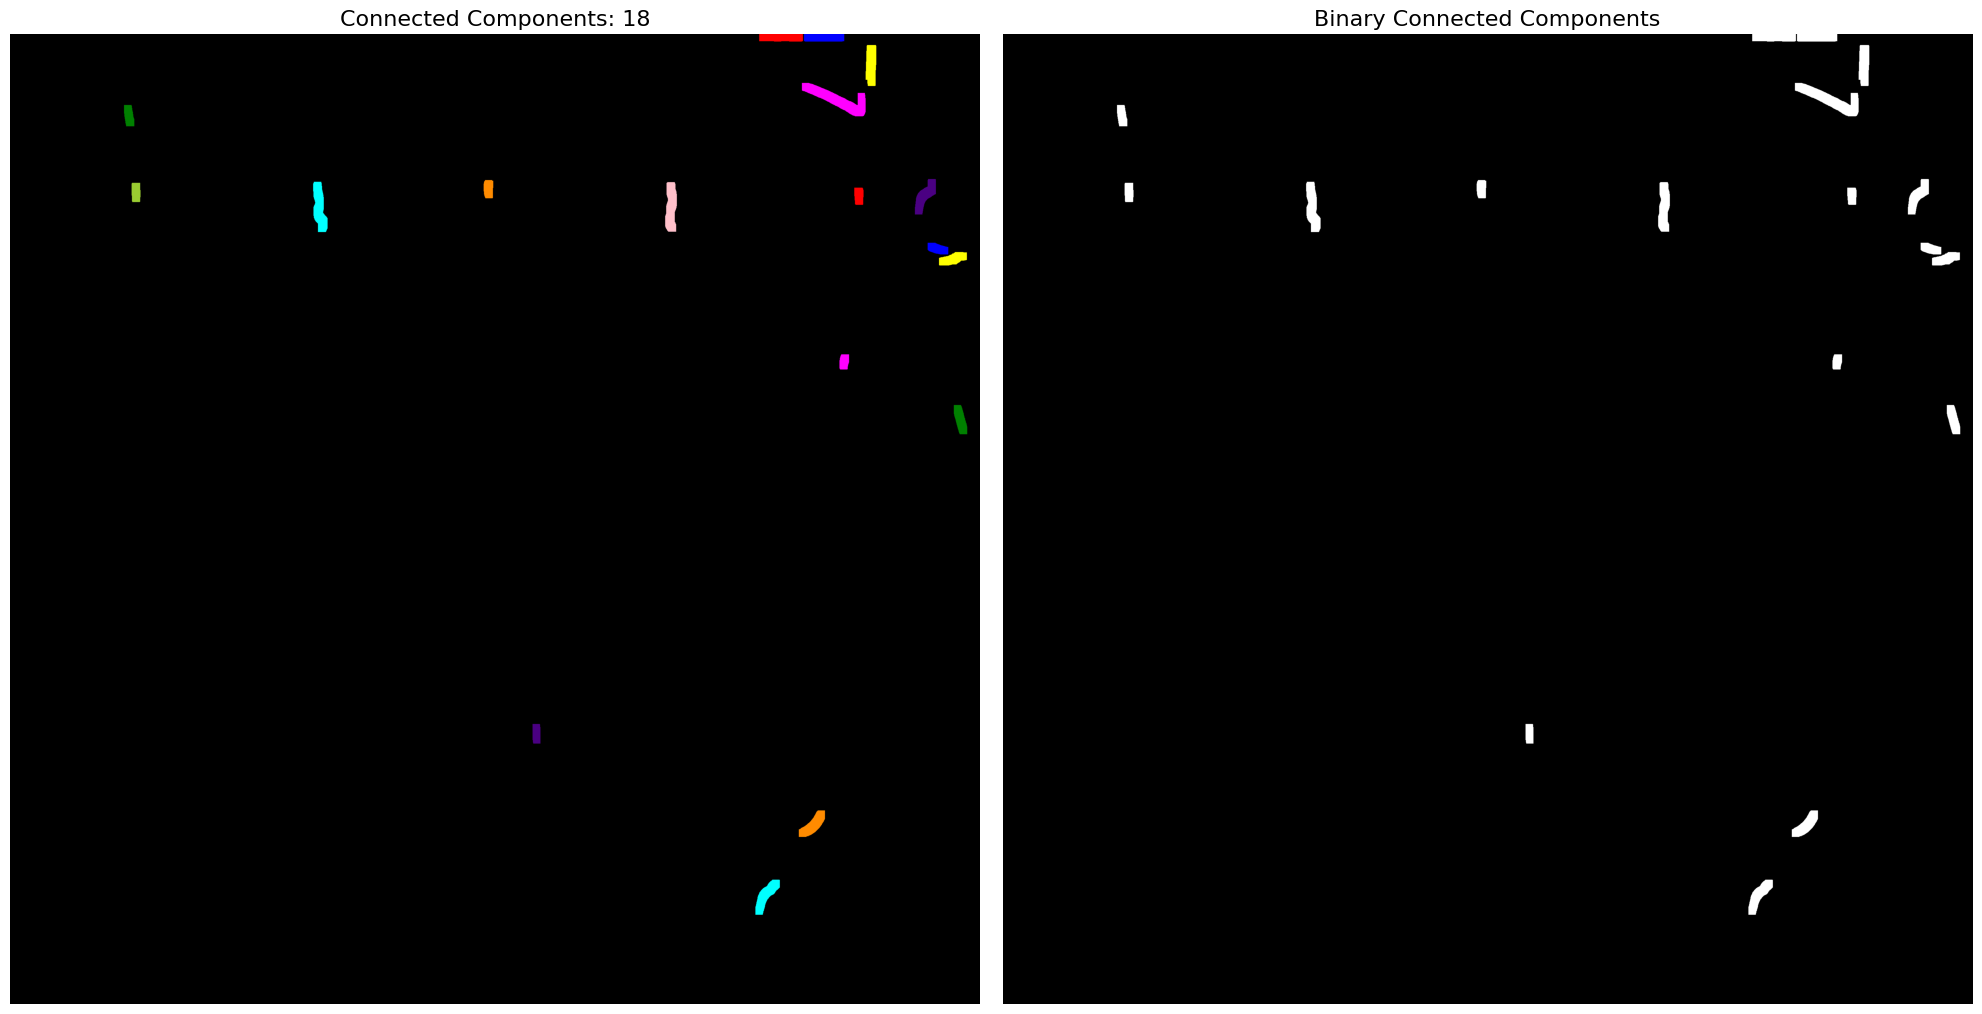

Filename: test_image_8.png | Number of connected components: 5


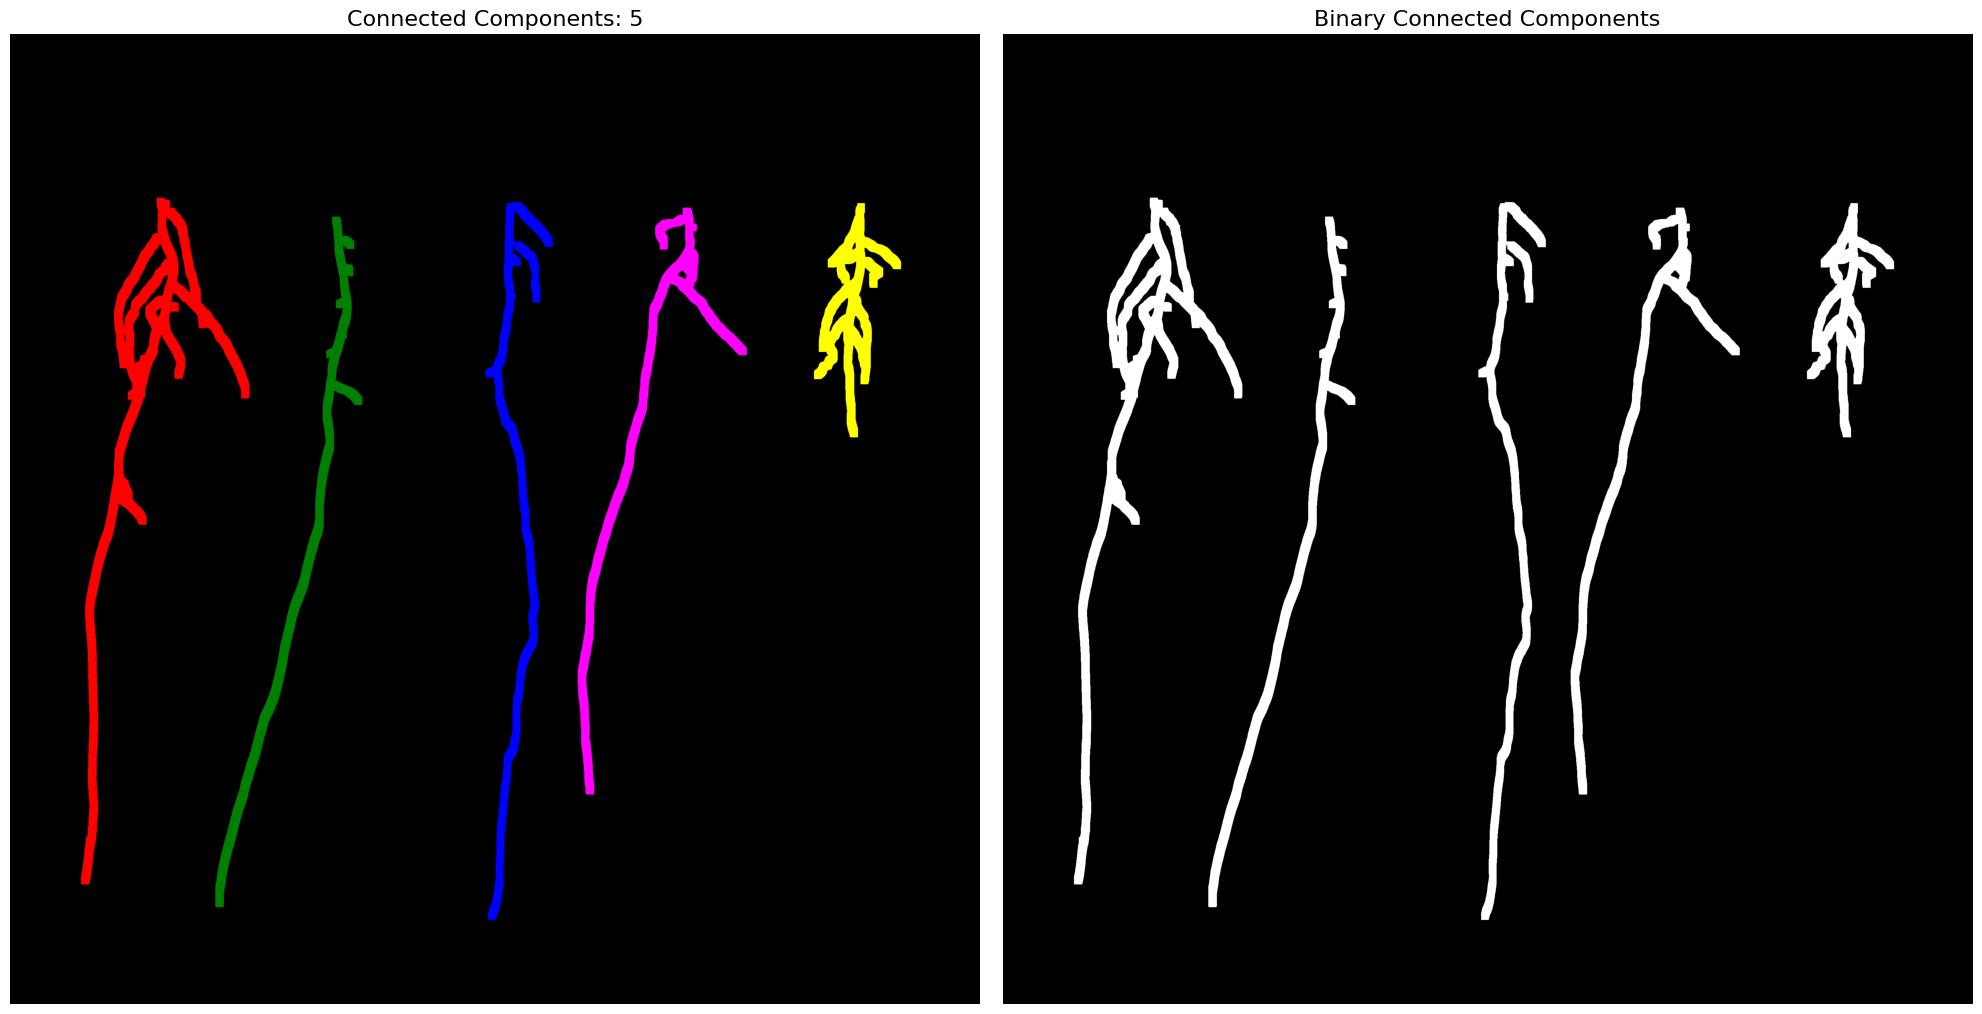

Filename: test_image_11.png | Number of connected components: 12


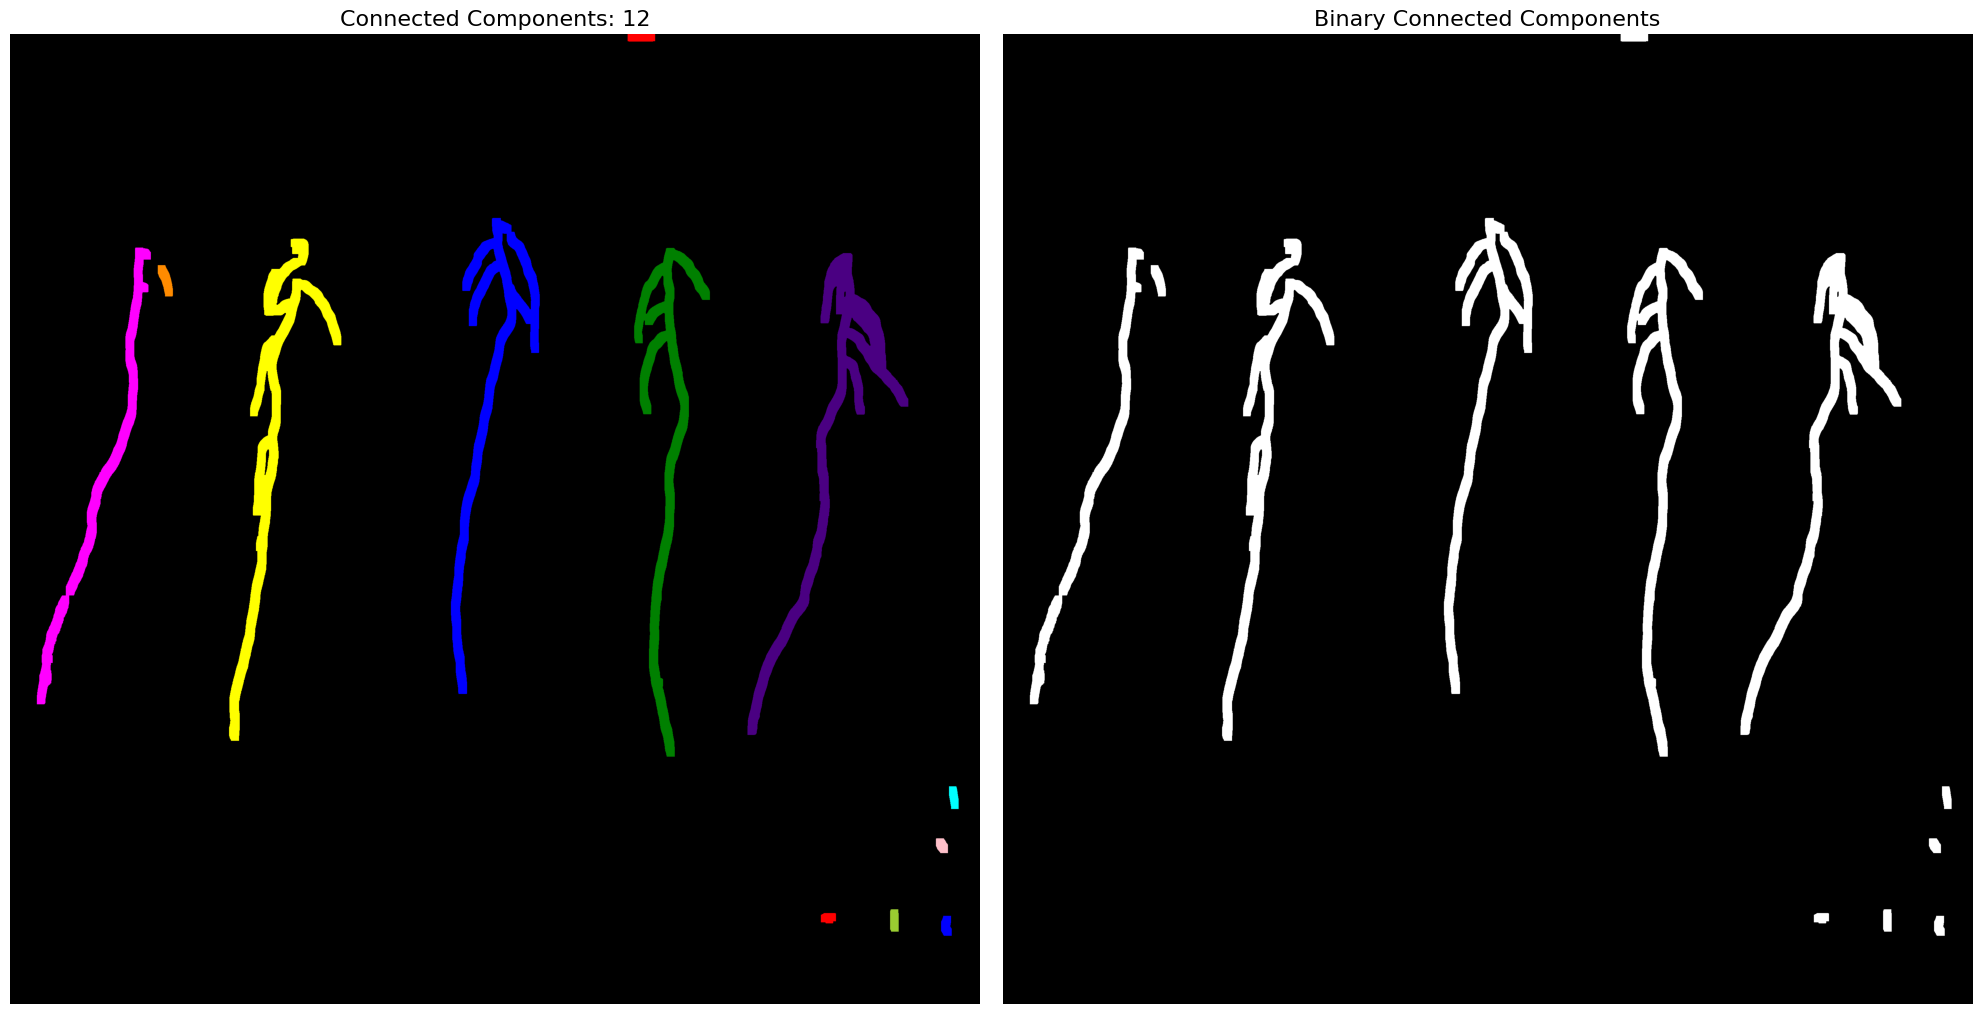

Filename: test_image_9.png | Number of connected components: 12


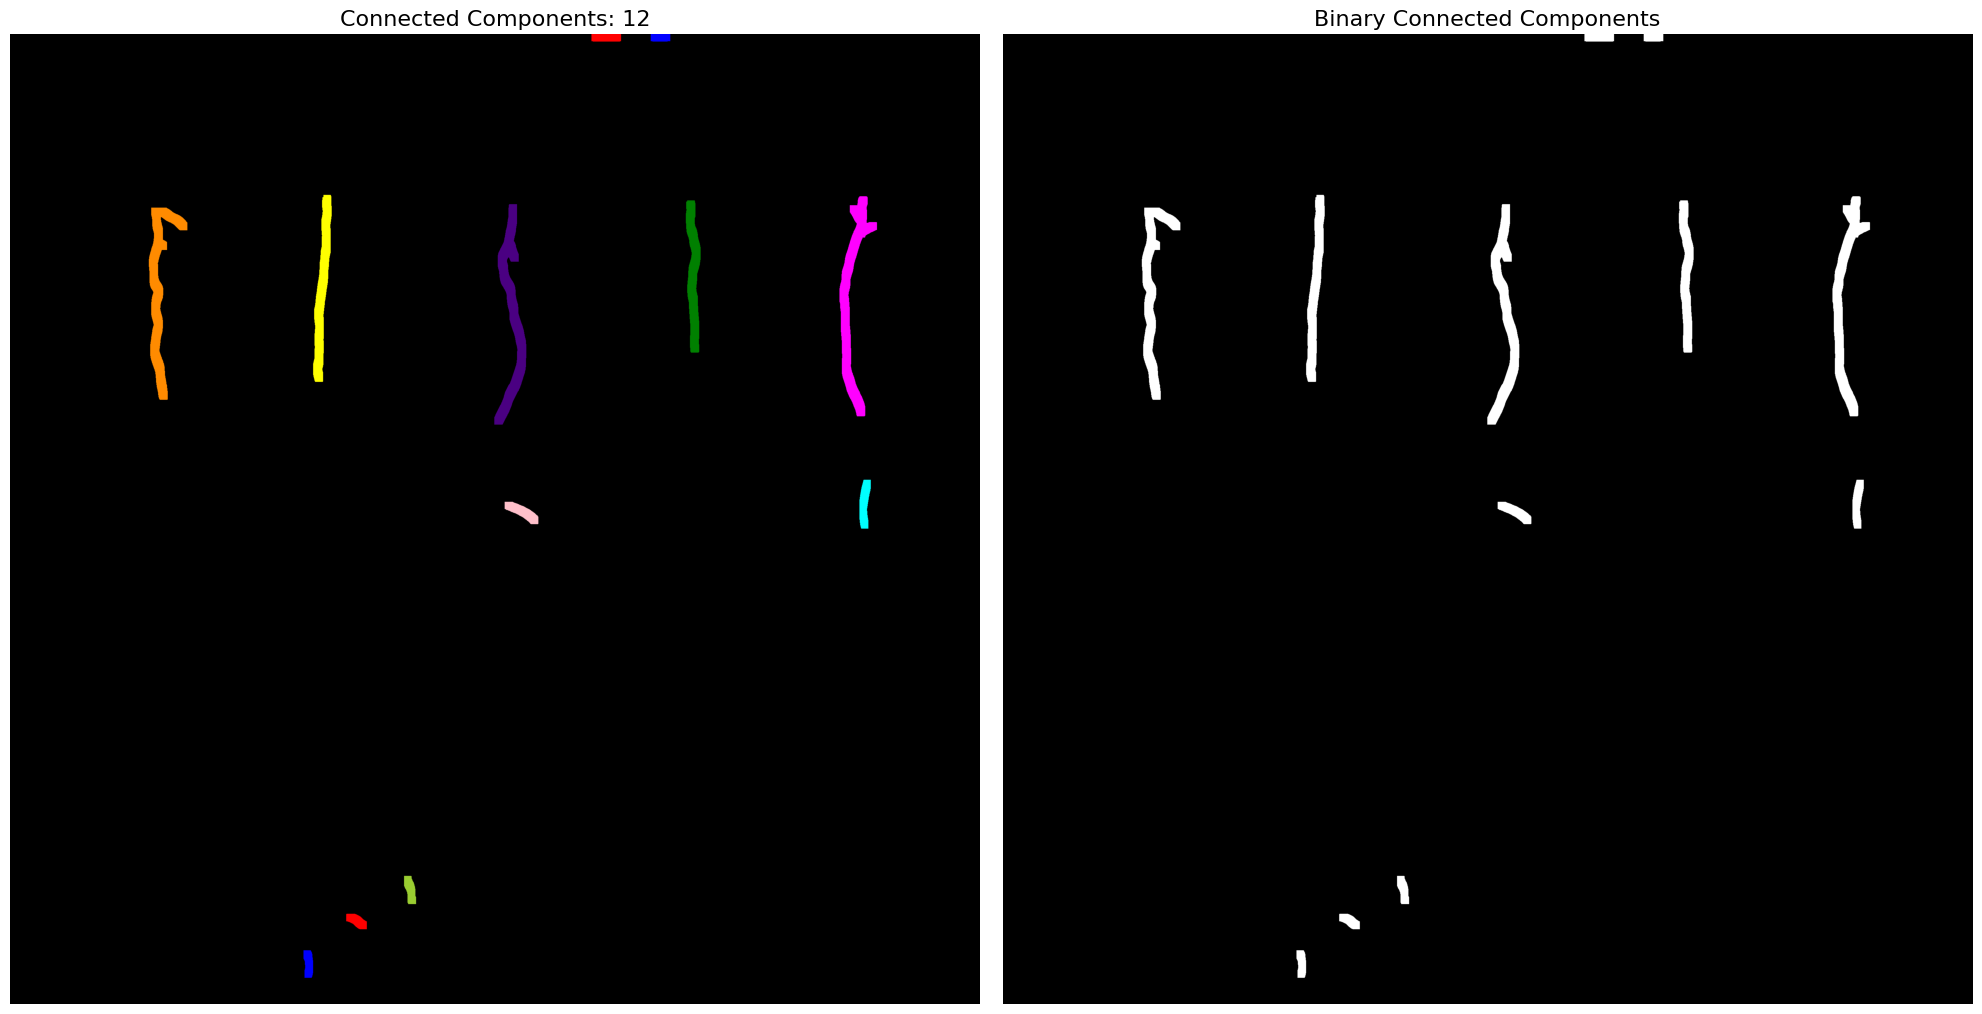

Filename: test_image_15.png | Number of connected components: 10


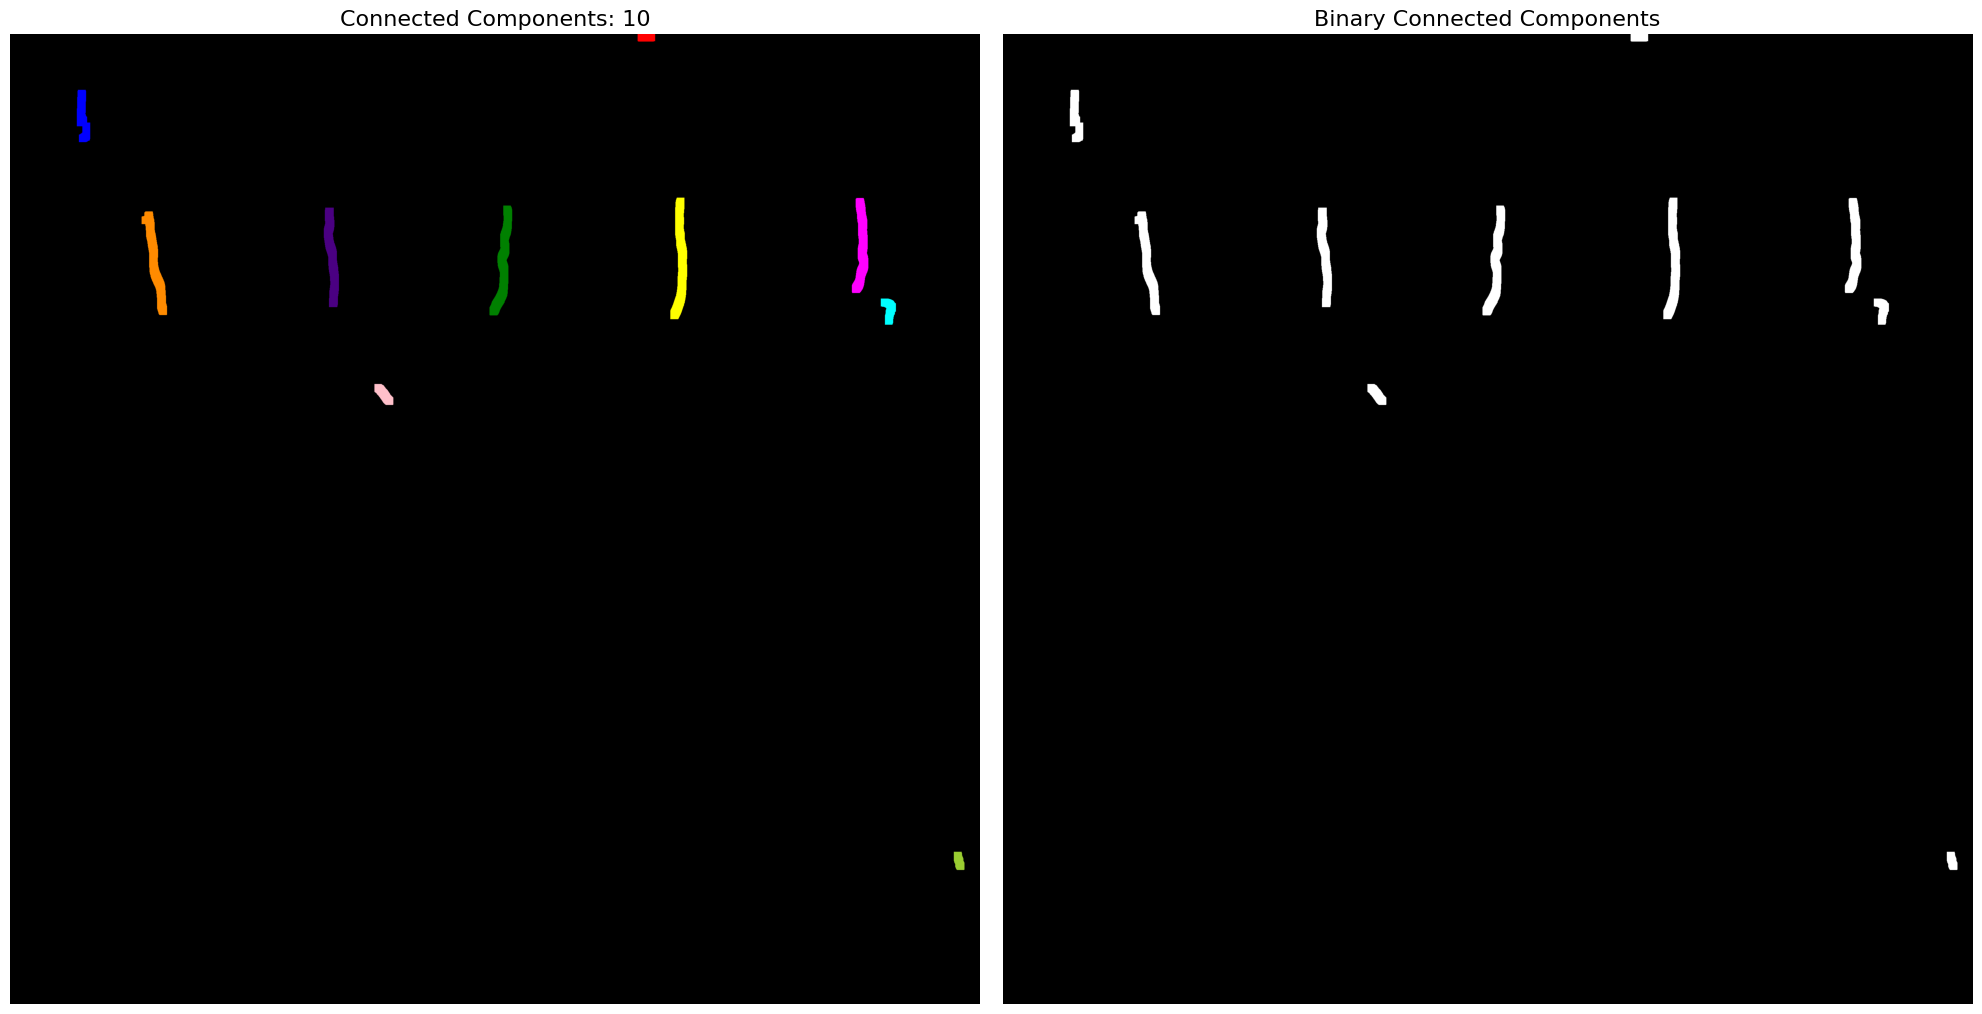

Filename: test_image_2.png | Number of connected components: 5


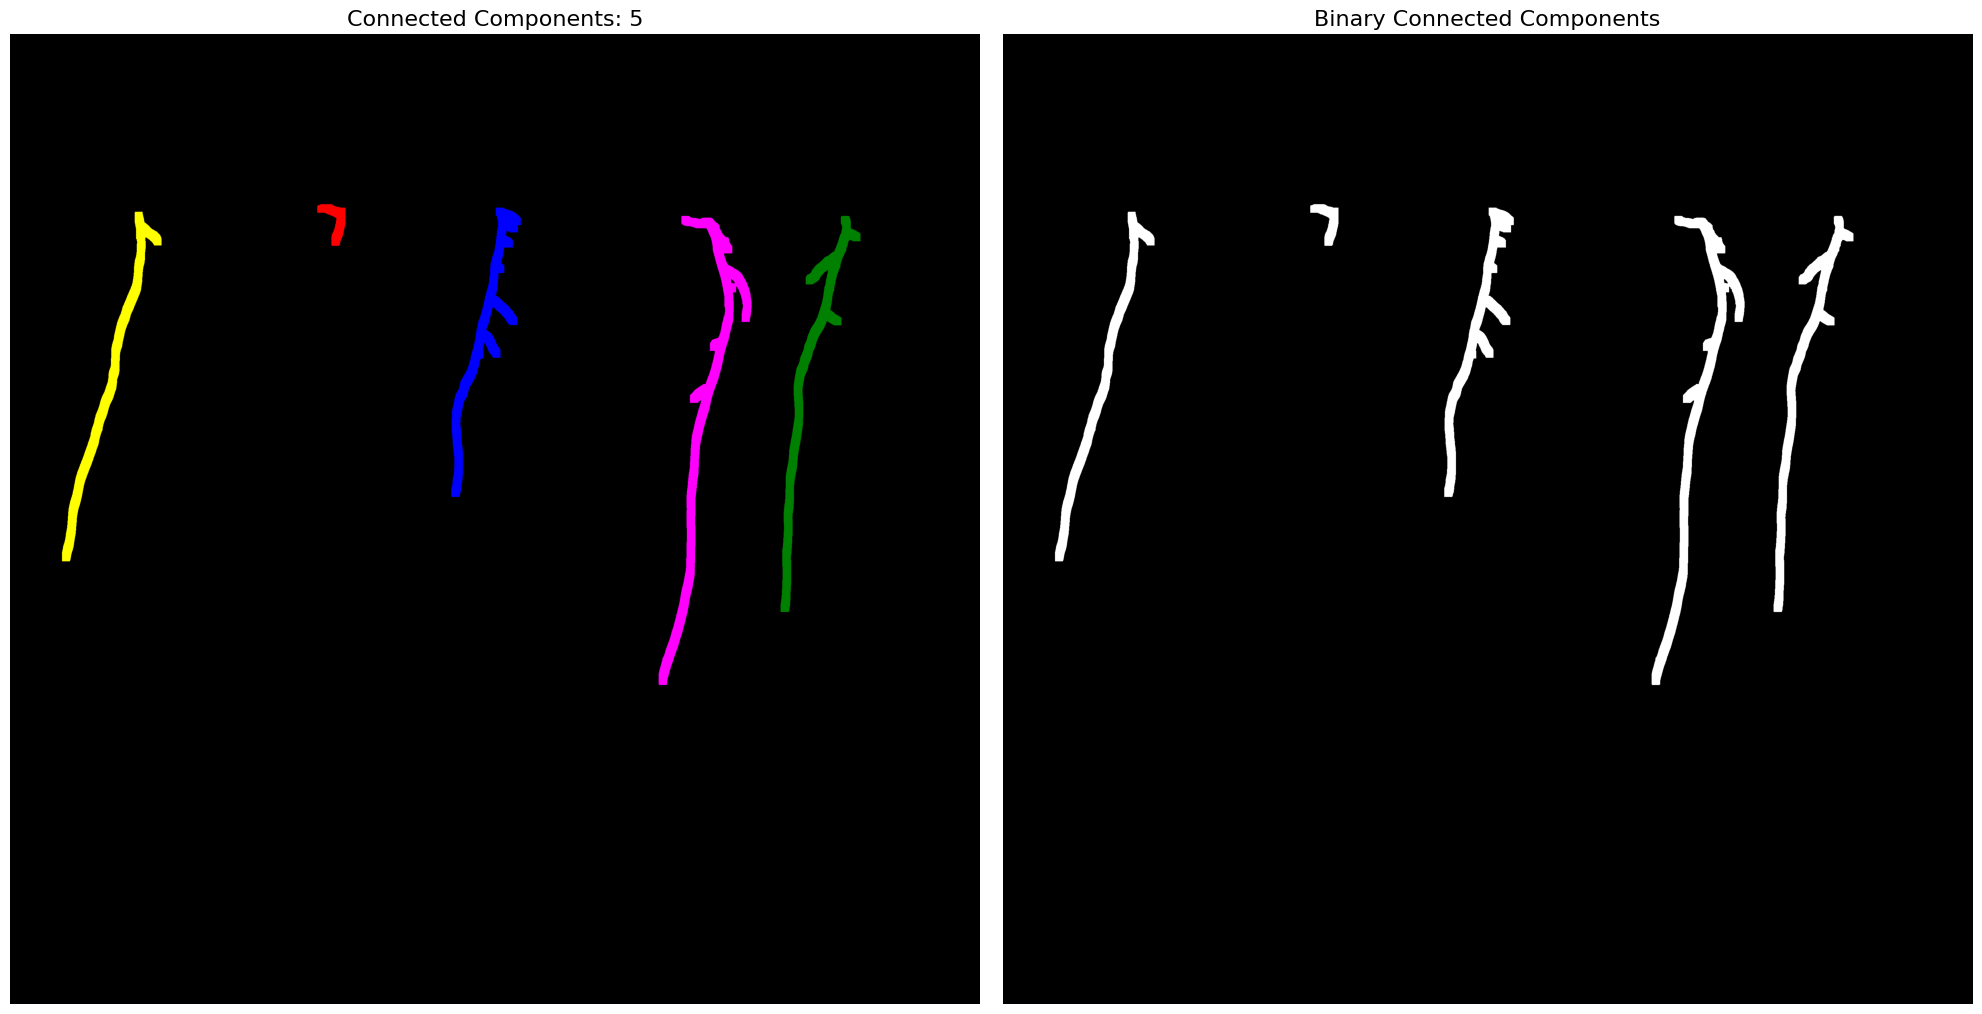

Filename: test_image_6.png | Number of connected components: 6


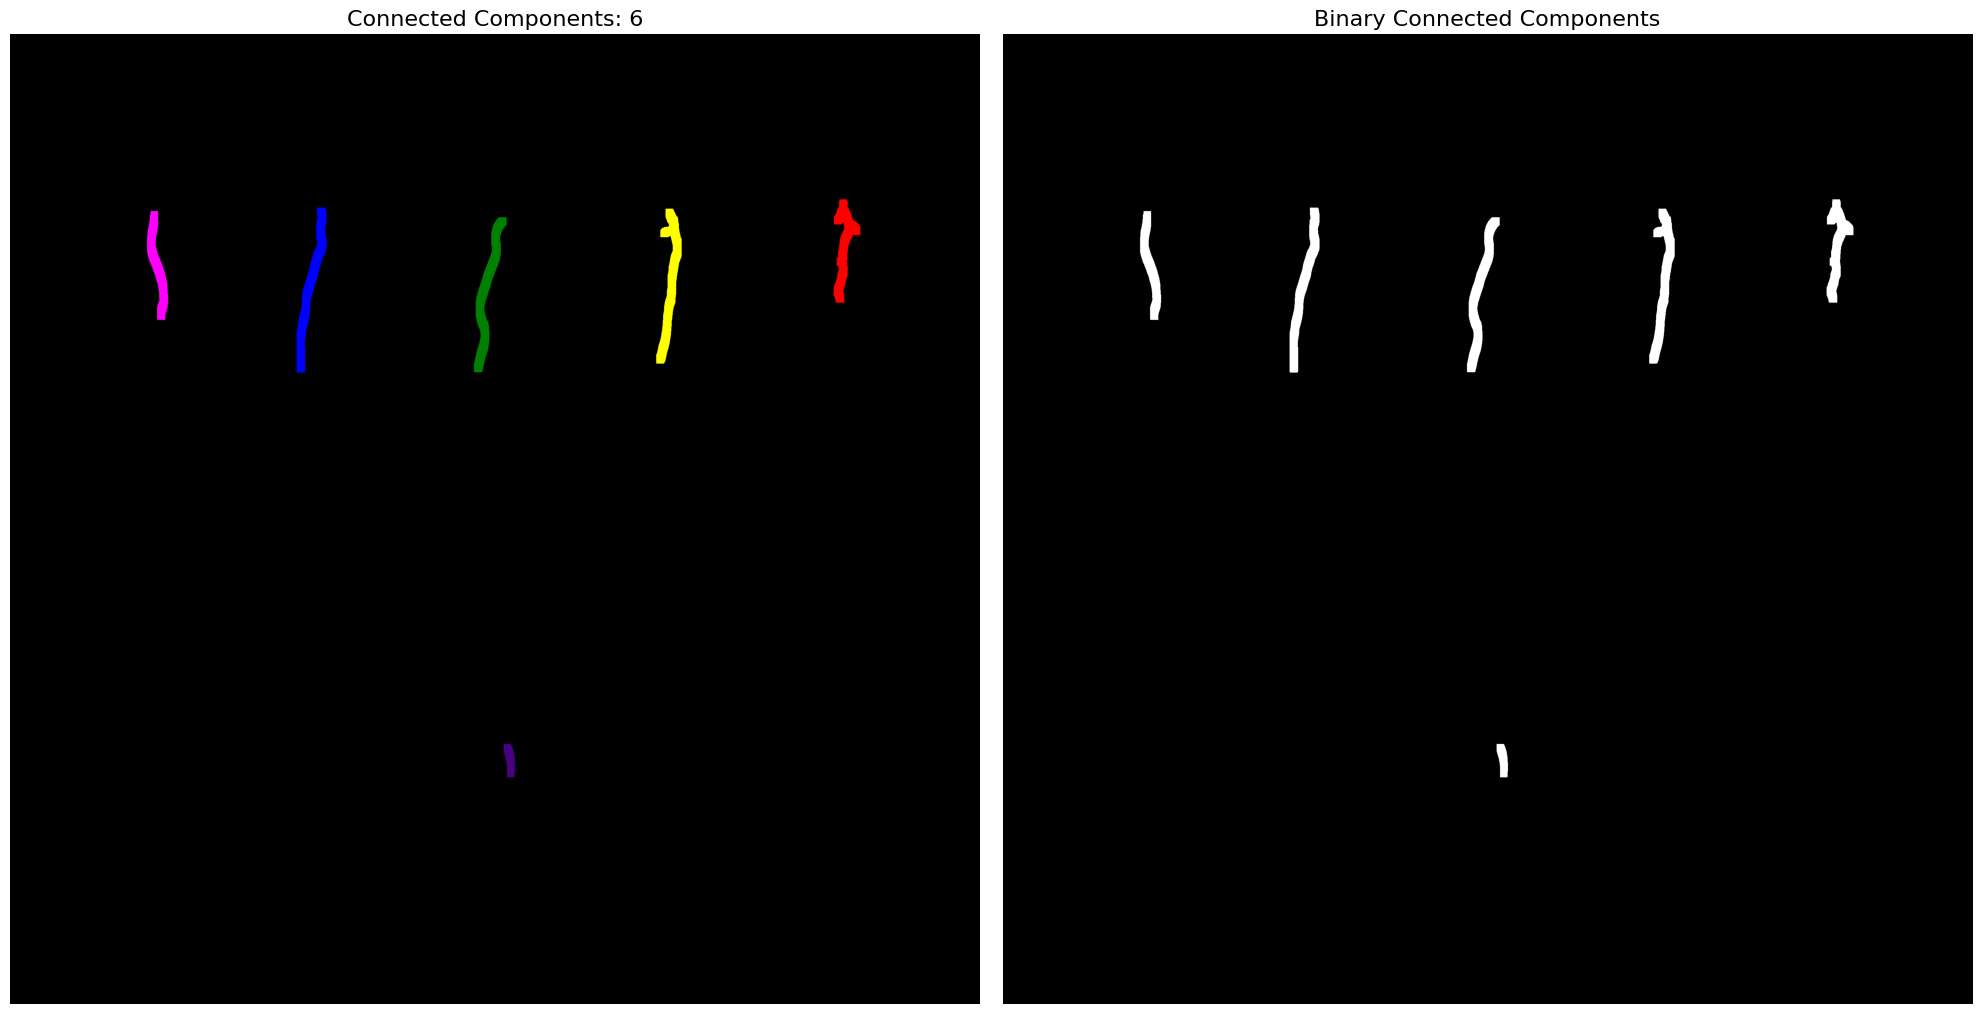

Filename: test_image_18.png | Number of connected components: 7


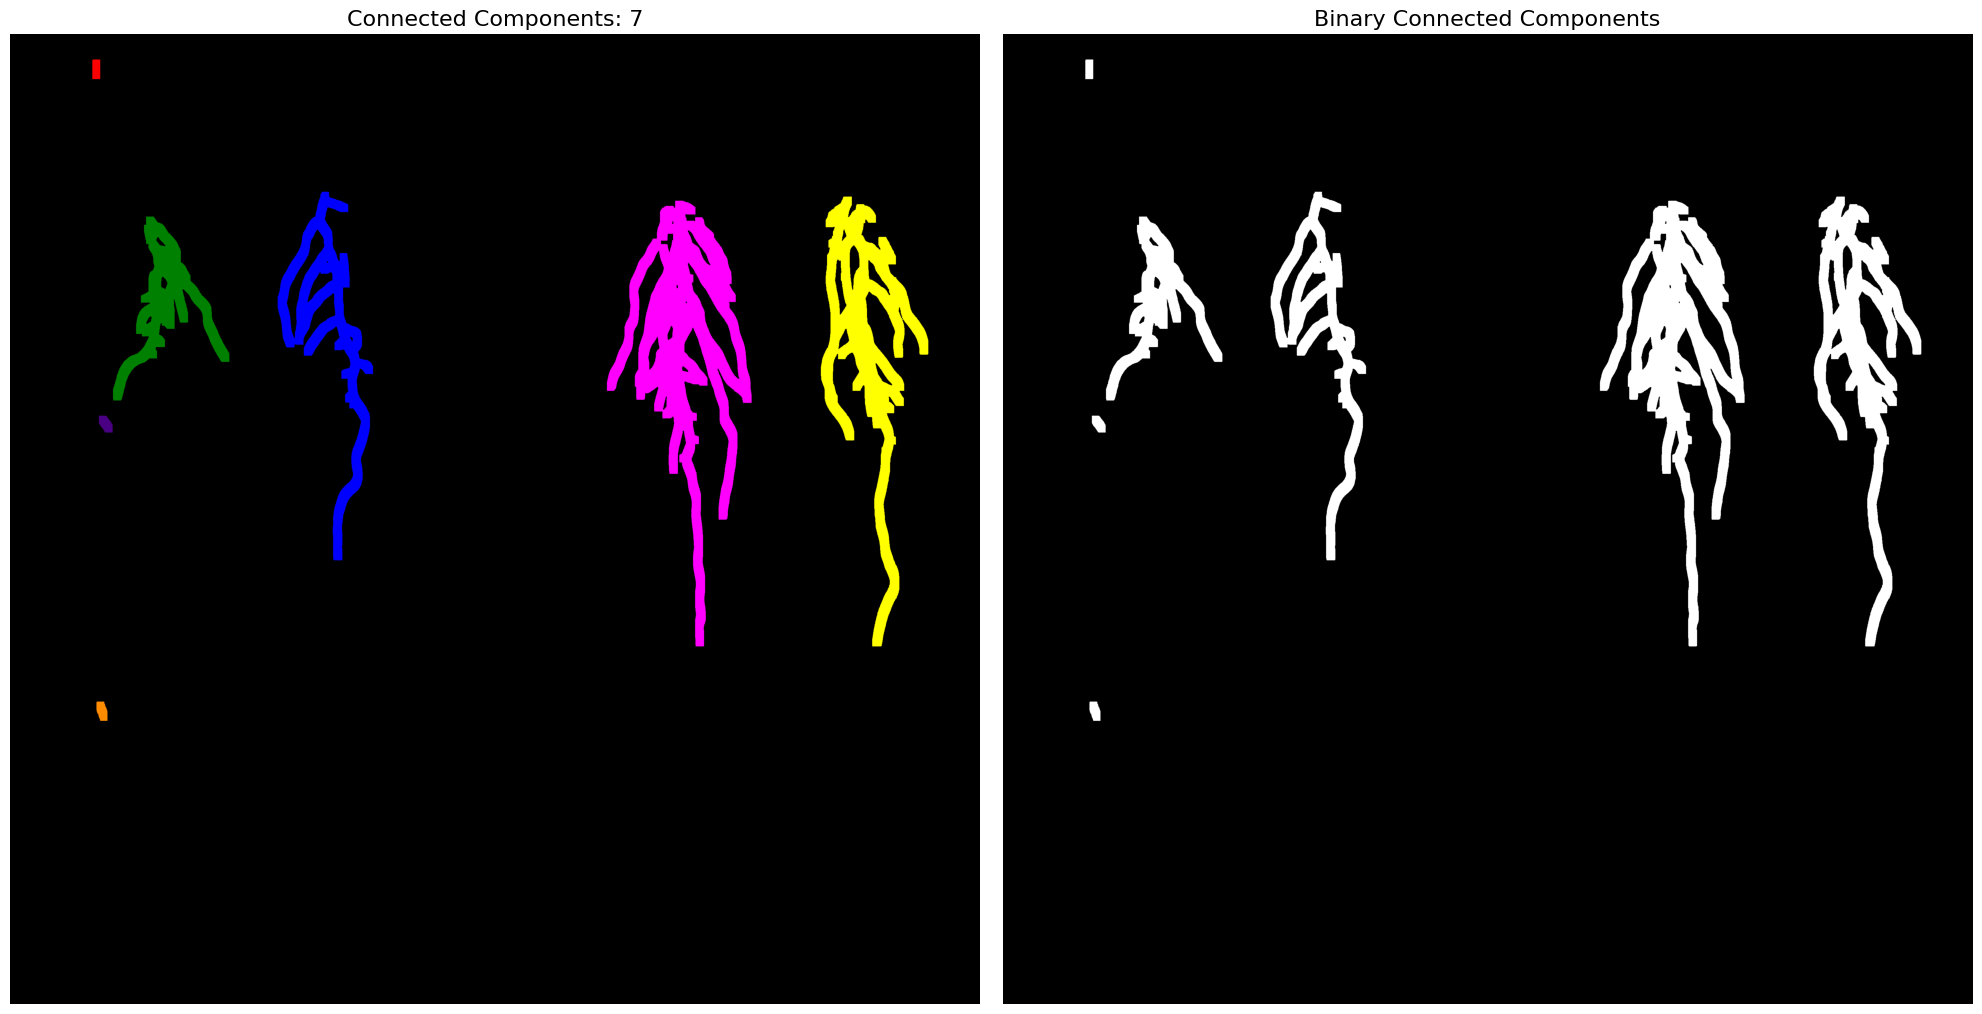

Filename: test_image_16.png | Number of connected components: 6


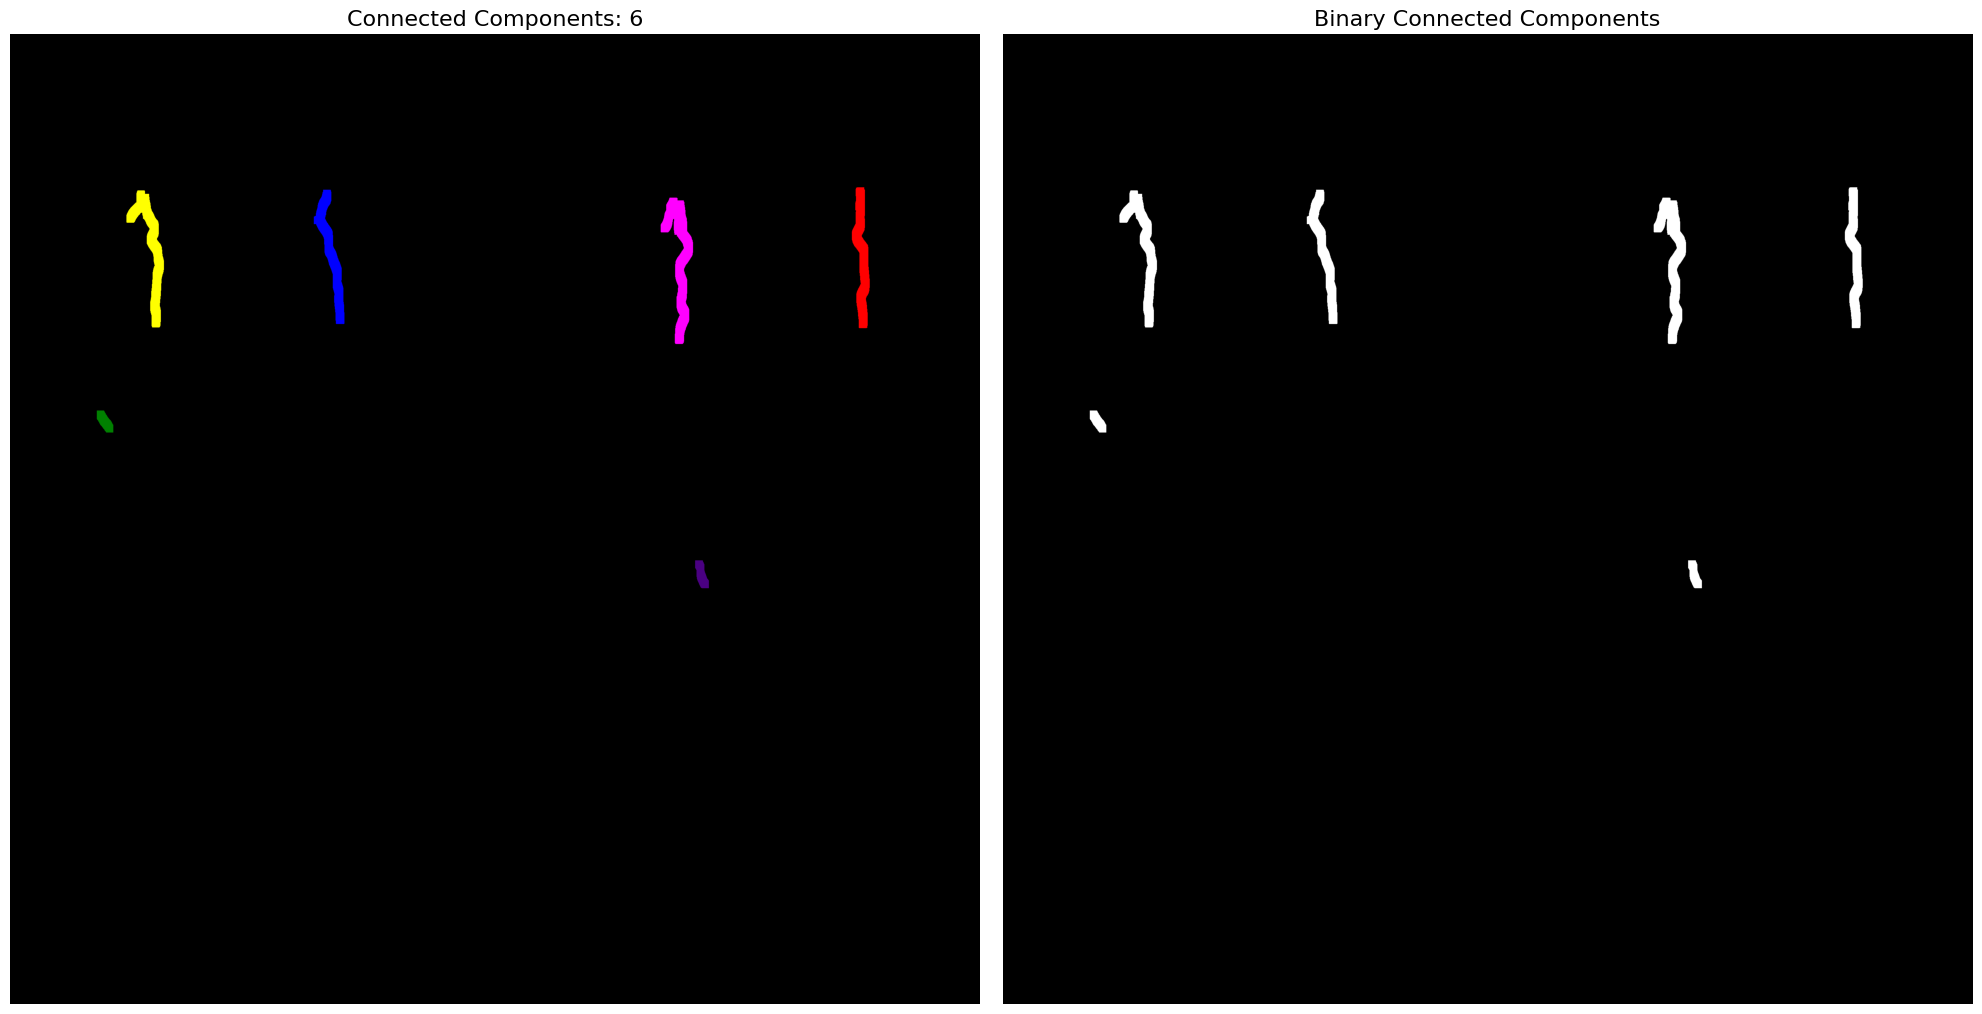

Filename: test_image_7.png | Number of connected components: 5


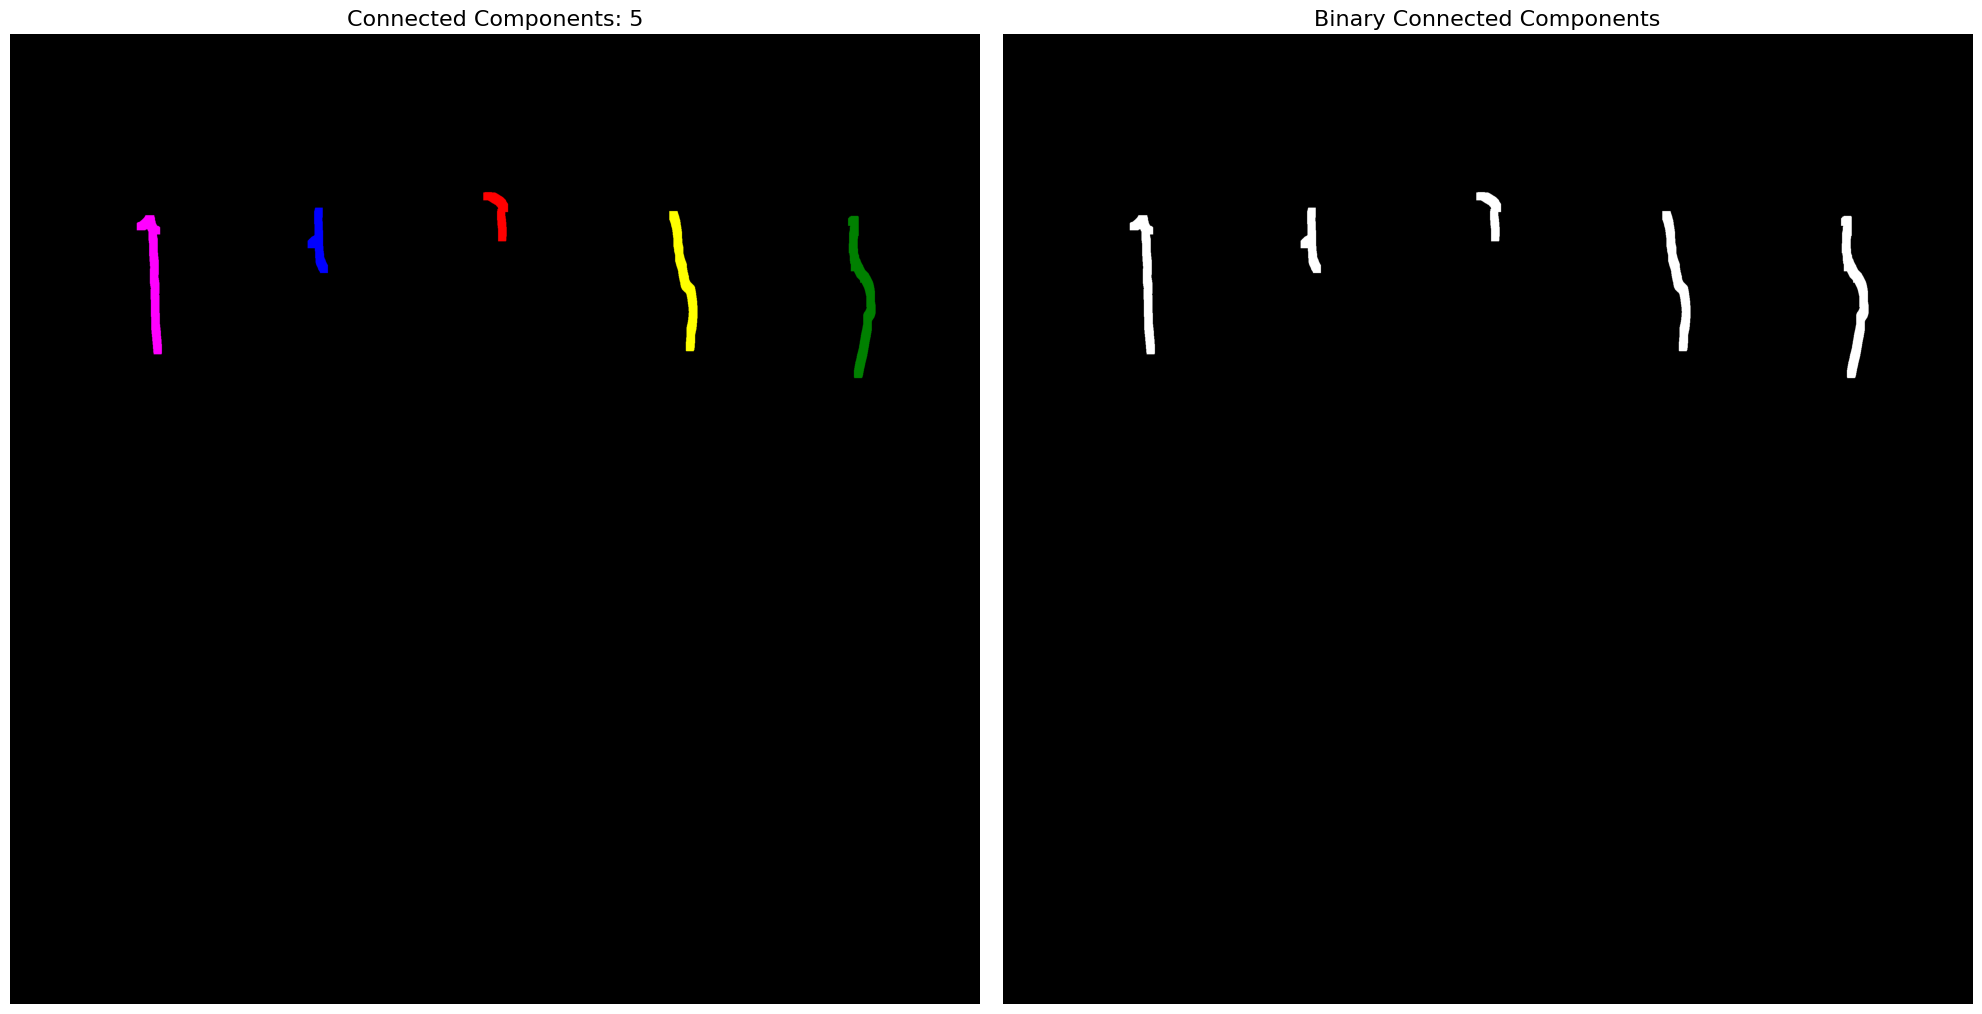

In [21]:
""
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Process connected components for each cleaned mask
for filename, final_processed_mask in processed_masks:
    # Step 1: Label connected components
    labeled_mask = label(final_processed_mask > 0)  # Ensure the mask is binary (True for foreground pixels)

    # Step 2: Count the number of connected components (excluding background)
    num_connected_components = labeled_mask.max()
    print(f"Filename: {filename} | Number of connected components: {num_connected_components}")

    # Step 3: Convert labeled mask to a color image for visualization
    colored_labels = label2rgb(labeled_mask, bg_label=0, bg_color=(0, 0, 0), colors=None)

    # Plot the labeled connected components
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Connected Components: {num_connected_components}", fontsize=16)
    plt.imshow(colored_labels)
    plt.axis('off')

    # Step 4: Convert labeled mask back to binary
    binary_labels = (labeled_mask > 0).astype(np.uint8) * 255  # Set all non-zero labels to 255

    # Plot the binary connected components
    plt.subplot(1, 2, 2)
    plt.title("Binary Connected Components", fontsize=16)
    plt.imshow(binary_labels, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
"" 

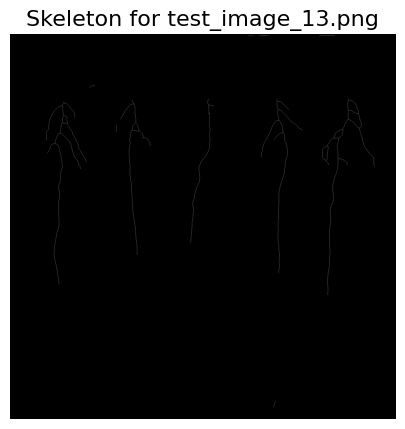

Branch data for test_image_13.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            6        34.414214            0   
1            1            3           39        72.414214            0   
2            2            5          110       114.242641            0   
3            3          243          263        46.798990            0   
4            4          264          292        10.656854            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               1773   
1               1.0                0.0                  9               1888   
2               1.0                0.0                  9               2368   
3               1.0                0.0                378                619   
4               1.0                0.0                473               2466   

   image-coord-dst-0  image-coord-dst-1

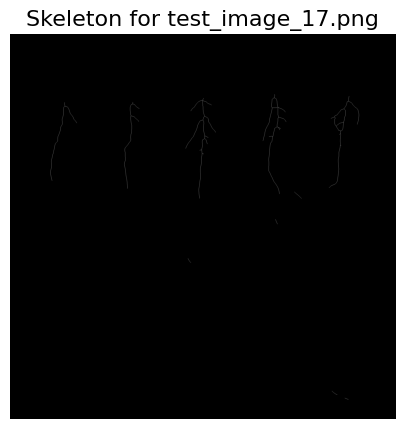

Branch data for test_image_17.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           38        27.899495            1   
1            1           14          184        39.071068            1   
2            0           38          707        88.112698            2   
3            0           38          649        82.870058            2   
4            2           50          126        18.899495            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                441               1929   
1               1.0                0.0                454               2474   
2               1.0                0.0                466               1928   
3               1.0                0.0                466               1928   
4               1.0                0.0                469               1412   

   image-coord-dst-0  image-coord-dst-1

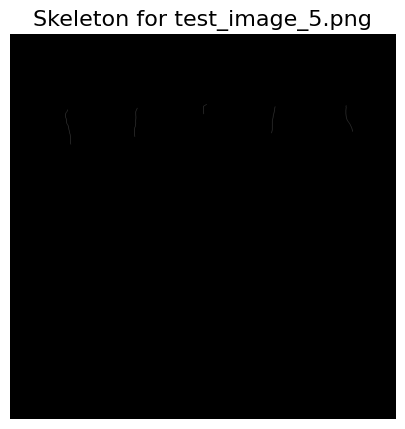

Branch data for test_image_5.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1          277        87.627417            0   
1            1           14          791       213.367532            0   
2            2           35          824       205.183766            0   
3            3           67          878       222.426407            0   
4            4          115          934       277.195959            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                514               1435   
1               1.0                0.0                522               2453   
2               1.0                0.0                530               1934   
3               1.0                0.0                541                929   
4               1.0                0.0                553                420   

   image-coord-dst-0  image-coord-dst-1 

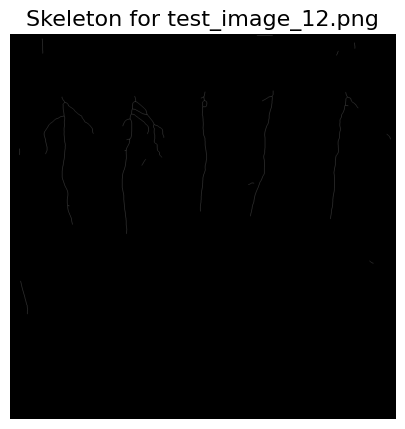

Branch data for test_image_12.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            2       115.414214            0   
1            1          116          286       110.485281            0   
2            2          146          232        45.485281            0   
3            3          251          300        37.798990            0   
4            4          302          418        45.313708            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               1916   
1               1.0                0.0                 34                234   
2               1.0                0.0                 63               2514   
3               1.0                0.0                124               2395   
4               1.0                0.0                414               1919   

   image-coord-dst-0  image-coord-dst-1

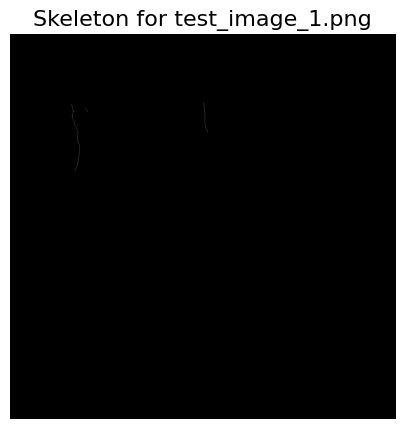

Branch data for test_image_1.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          472       235.254834            0   
1            1           16          140        54.970563            1   
2            2           73          162        36.698485            0   
3            1          140          229        38.656854            2   
4            1          140          155         7.242641            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                498               1411   
1               1.0                0.0                514                451   
2               1.0                0.0                542                546   
3               1.0                0.0                564                461   
4               1.0                0.0                564                461   

   image-coord-dst-0  image-coord-dst-1 

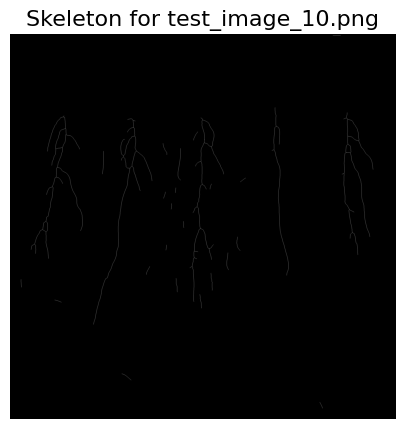

Branch data for test_image_10.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1           56        57.828427            0   
1            1           58          802       143.798990            1   
2            2           96          220        42.313708            1   
3            3          141          171        10.656854            1   
4            3          171         3405       311.421356            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               2412   
1               1.0                0.0                537               1934   
2               1.0                0.0                574               2460   
3               1.0                0.0                597                394   
4               1.0                0.0                606                390   

   image-coord-dst-0  image-coord-dst-1

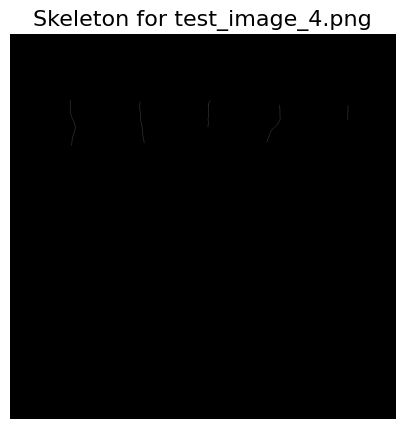

Branch data for test_image_4.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0         1217       360.166522            0   
1            1            7           92        35.142136            1   
2            2           25         1200       316.325902            0   
3            1           92           95         7.414214            1   
4            1           92          858       170.798990            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                482                438   
1               1.0                0.0                487               1460   
2               1.0                0.0                496                949   
3               1.0                0.0                517               1449   
4               1.0                0.0                517               1449   

   image-coord-dst-0  image-coord-dst-1 

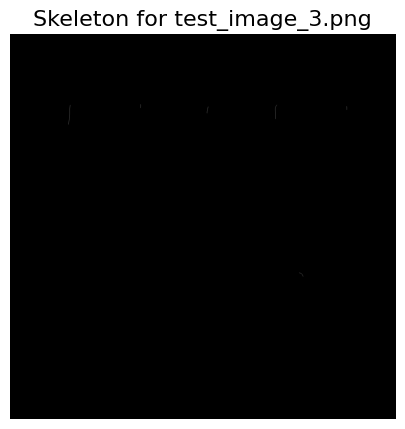

Branch data for test_image_3.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           91        27.656854            0   
1            1            5          309       110.455844            0   
2            2            6          349       148.213203            0   
3            3           36          150        27.242641            0   
4            4           47          224        52.556349            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                514                951   
1               1.0                0.0                518               1947   
2               1.0                0.0                519                440   
3               1.0                0.0                528               2457   
4               1.0                0.0                531               1446   

   image-coord-dst-0  image-coord-dst-1 

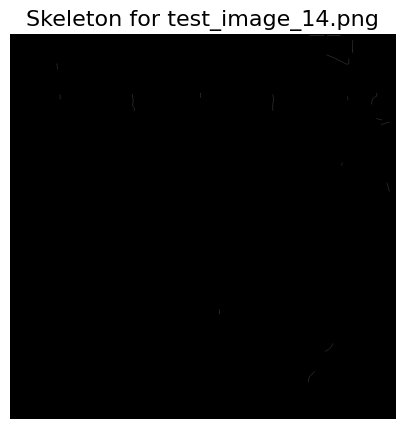

Branch data for test_image_14.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            4       108.414214            0   
1            1            3          111        98.414214            0   
2            2          208          284        76.242641            1   
3            2          284          288         4.828427            1   
4            2          284          308        21.828427            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               2292   
1               1.0                0.0                  9               2412   
2               1.0                0.0                 44               2501   
3               1.0                0.0                119               2498   
4               1.0                0.0                119               2498   

   image-coord-dst-0  image-coord-dst-1

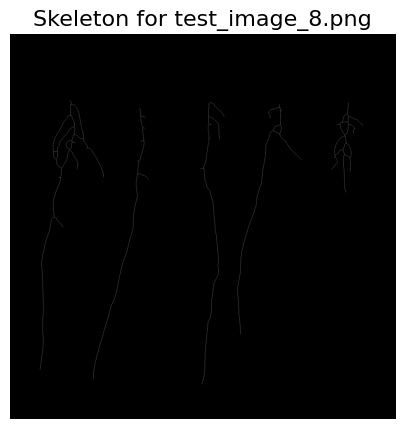

Branch data for test_image_8.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           90        34.313708            1   
1            1           18           23         2.000000            1   
2            2           21          709        90.384776            1   
3            1           23          965       149.379726            1   
4            1           23          980       120.899495            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                485                438   
1               1.0                0.0                500               1469   
2               1.0                0.0                501               2470   
3               1.0                0.0                502               1469   
4               1.0                0.0                502               1469   

   image-coord-dst-0  image-coord-dst-1 

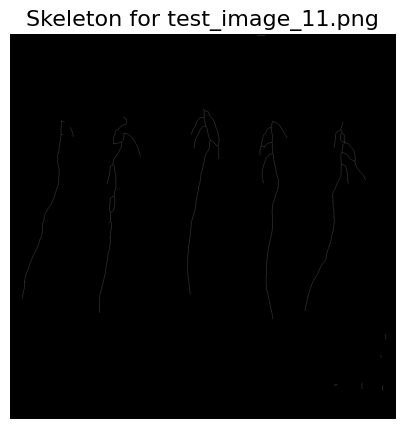

Branch data for test_image_11.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            2        61.414214            0   
1            1           62           78        18.899495            1   
2            1           78         2744       318.521861            2   
3            1           78          202        49.899495            2   
4            2          194         2442       270.208153            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               1863   
1               1.0                0.0                545               1413   
2               1.0                0.0                561               1418   
3               1.0                0.0                561               1418   
4               1.0                0.0                607                824   

   image-coord-dst-0  image-coord-dst-1

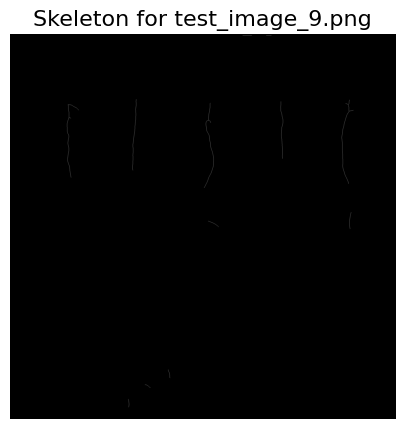

Branch data for test_image_9.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            4        67.414214            0   
1            1            3           70        38.414214            0   
2            2          107         2713       538.639610            0   
3            3          112          235        38.556349            1   
4            4          136         2370       435.396970            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               1764   
1               1.0                0.0                  9               1907   
2               1.0                0.0                477                920   
3               1.0                0.0                481               2476   
4               1.0                0.0                493               1977   

   image-coord-dst-0  image-coord-dst-1 

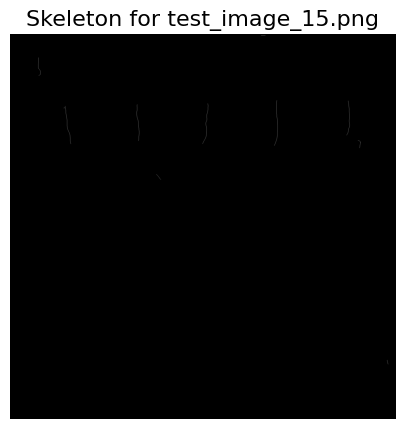

Branch data for test_image_15.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1            2        32.414214            0   
1            1           33          169       146.941125            0   
2            2          171         1656       346.740115            0   
3            3          175         1363       269.396970            0   
4            4          214         1628       319.438600            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  9               1863   
1               1.0                0.0                172                209   
2               1.0                0.0                485               1947   
3               1.0                0.0                488               2467   
4               1.0                0.0                508               1443   

   image-coord-dst-0  image-coord-dst-1

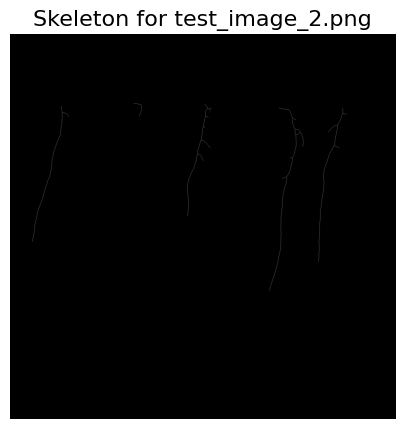

Branch data for test_image_2.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0           21          602       152.254834            0   
1            1           47          185        41.870058            1   
2            2           79          391        51.556349            1   
3            3          124          685       153.053824            1   
4            4          125          469        44.485281            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                508                901   
1               1.0                0.0                515               1420   
2               1.0                0.0                526                374   
3               1.0                0.0                540               1961   
4               1.0                0.0                540               2424   

   image-coord-dst-0  image-coord-dst-1 

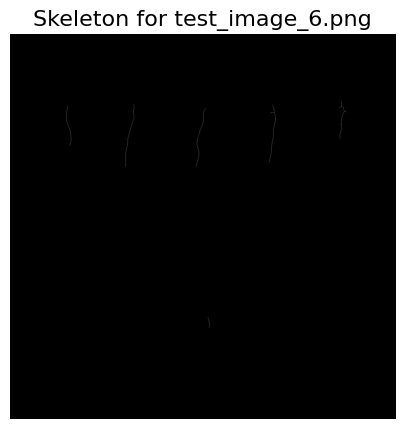

Branch data for test_image_6.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           73        41.485281            1   
1            1           24         1960       488.066017            0   
2            2           35          318        58.384776            1   
3            3           49         1526       314.953319            0   
4            0           73          146        23.970563            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                490               2419   
1               1.0                0.0                514                902   
2               1.0                0.0                519               1914   
3               1.0                0.0                524                418   
4               1.0                0.0                529               2419   

   image-coord-dst-0  image-coord-dst-1 

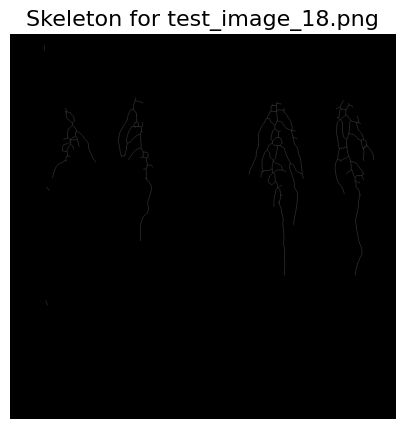

Branch data for test_image_18.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           35        35.828427            0   
1            1           36           62        22.242641            1   
2            2           53          403        61.941125            1   
3            1           62          163        64.041631            1   
4            1           62          555        69.627417            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 84                251   
1               1.0                0.0                467                916   
2               1.0                0.0                483               2432   
3               1.0                0.0                488                913   
4               1.0                0.0                488                913   

   image-coord-dst-0  image-coord-dst-1

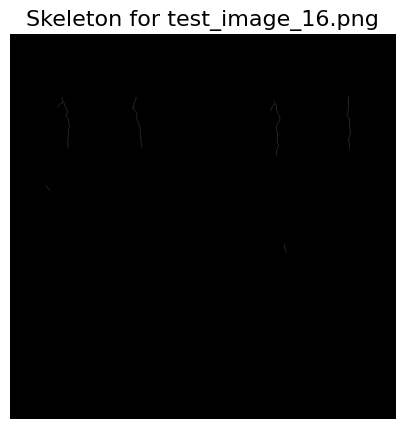

Branch data for test_image_16.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          143        47.656854            1   
1            1            8          383        85.698485            1   
2            2           10          135        40.313708            1   
3            3           84          215        28.727922            1   
4            2          135          362        56.183766            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                454               2470   
1               1.0                0.0                462                920   
2               1.0                0.0                463                381   
3               1.0                0.0                487               1926   
4               1.0                0.0                500                385   

   image-coord-dst-0  image-coord-dst-1

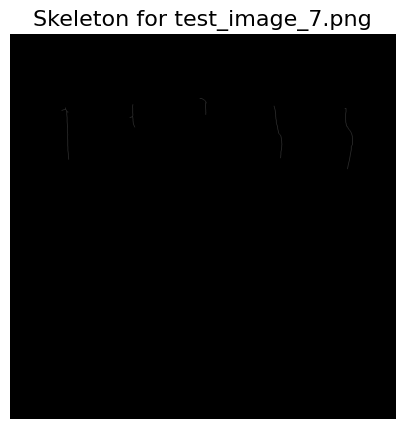

Branch data for test_image_7.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           54        63.526912            1   
1            0           54           59         4.414214            1   
2            0           54          435        91.142136            1   
3            1           69          497        94.727922            1   
4            2           93         1500       410.580736            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                471               1384   
1               1.0                0.0                503               1429   
2               1.0                0.0                503               1429   
3               1.0                0.0                514                897   
4               1.0                0.0                525               1926   

   image-coord-dst-0  image-coord-dst-1 

In [22]:
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import matplotlib.pyplot as plt

# Process skeletonization for each binary connected component
skeleton_results = []
for filename, final_processed_mask in processed_masks:
    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(final_processed_mask > 0)  # Ensure mask is binary (True for foreground)

    # Step 2: Convert the skeletonized object into a skan Skeleton object
    skeleton_data = Skeleton(skeleton_object)

    # Step 3: Summarize the skeleton's branch data
    branch_data = summarize(skeleton_data)

    # Append results for further use
    skeleton_results.append((filename, skeleton_object, branch_data))

    # Plot the skeletonized mask
    plt.figure(figsize=(10, 5))
    plt.title(f"Skeleton for {filename}", fontsize=16)
    plt.imshow(skeleton_object, cmap='gray')
    plt.axis('off')
    plt.show()

    # Display branch data
    print(f"Branch data for {filename}:")
    print(branch_data.head())  # Display the first few rows of branch data

Processing test_image_13.png...


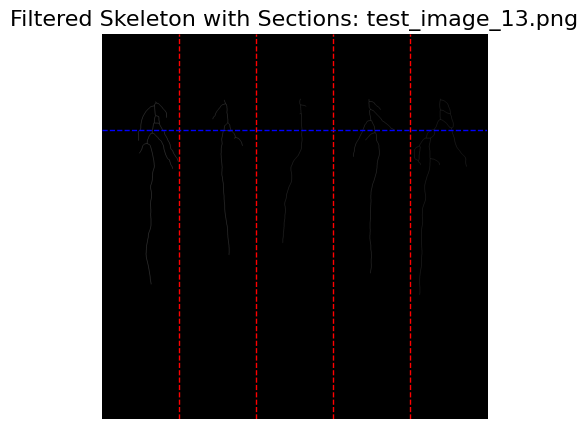

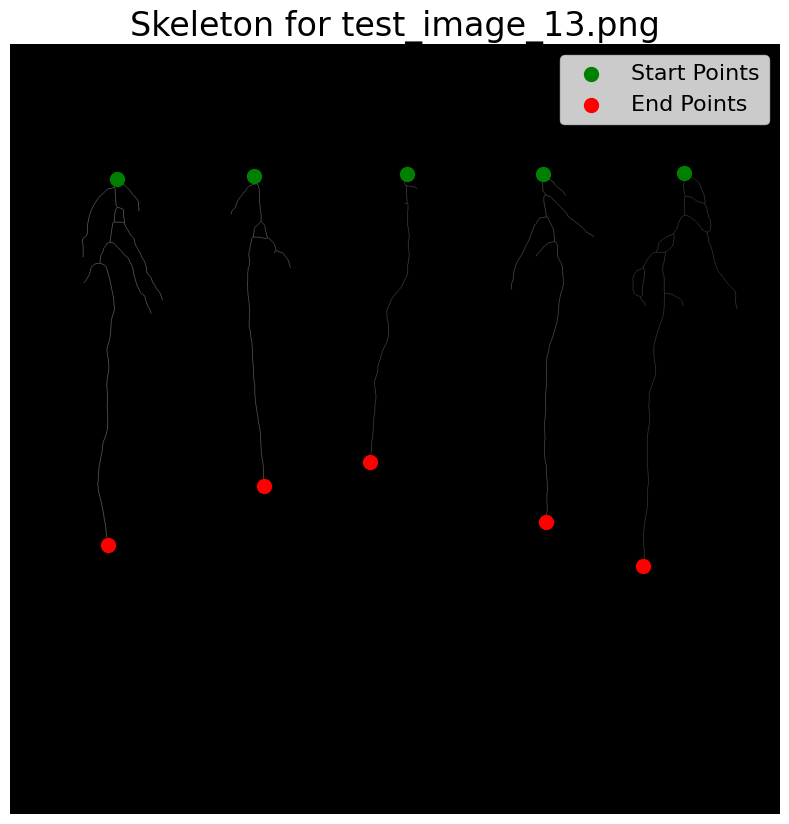

Processing test_image_17.png...


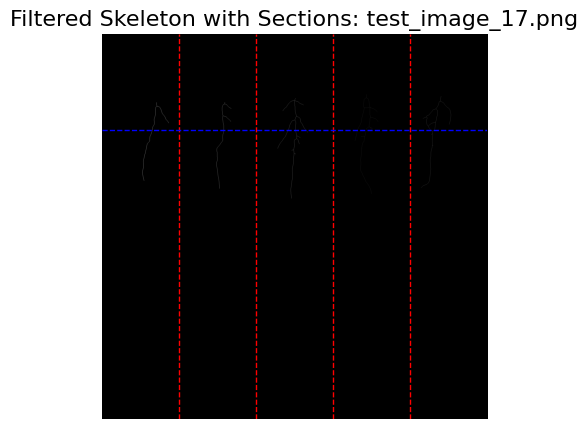

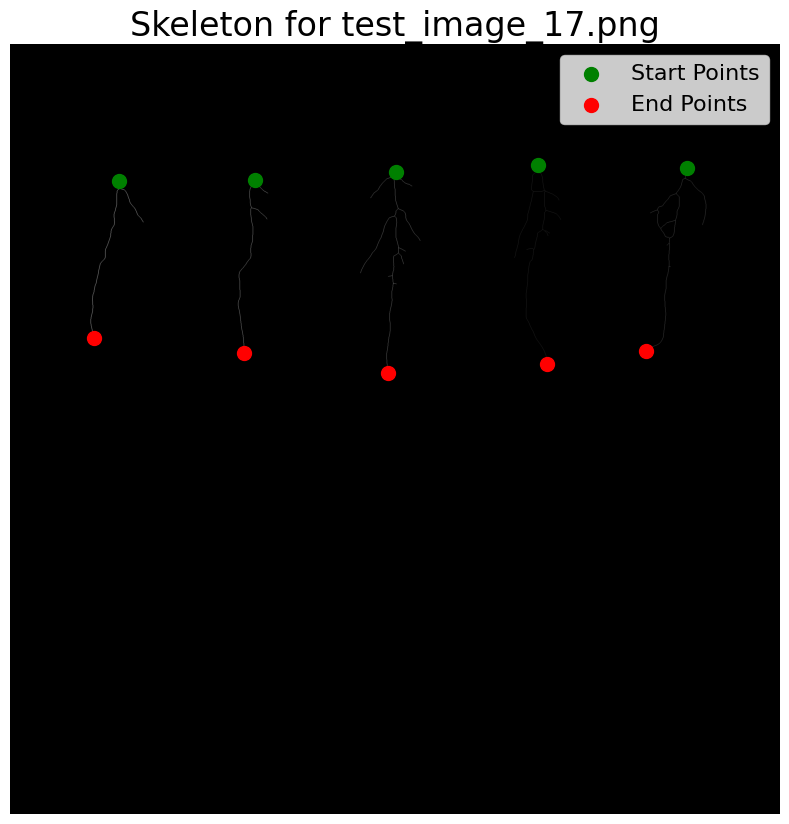

Processing test_image_5.png...


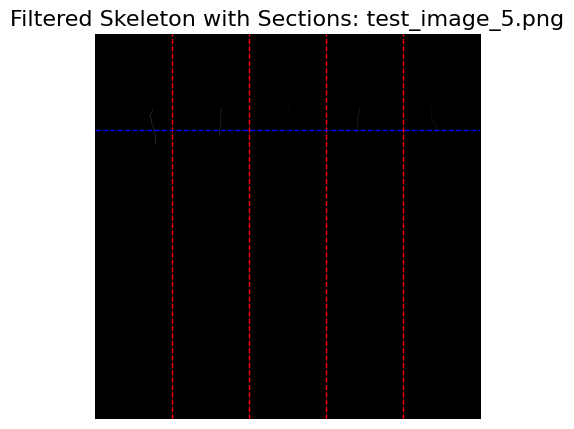

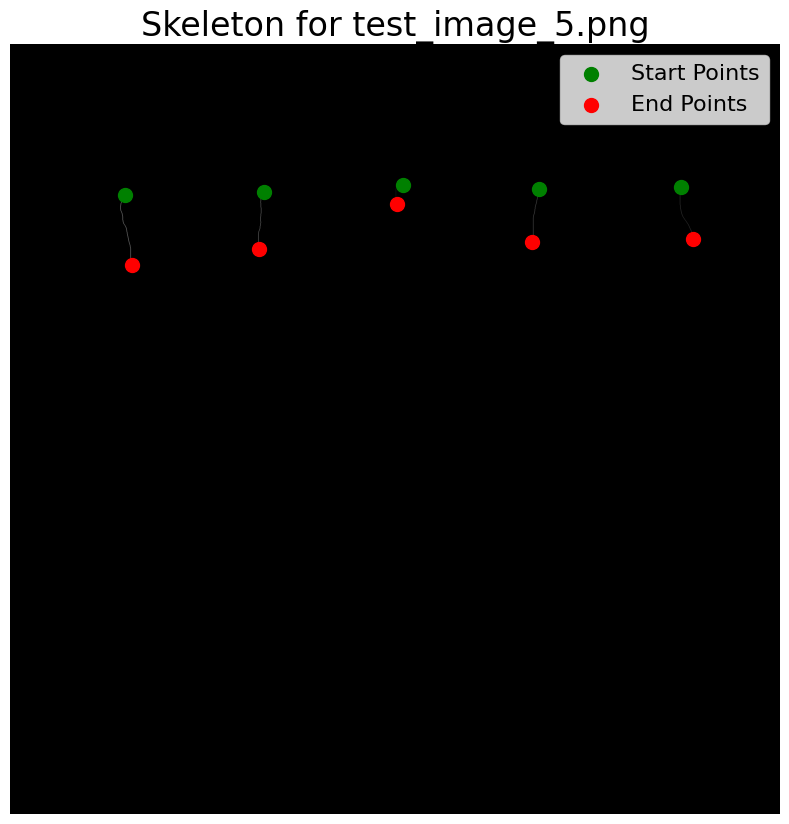

Processing test_image_12.png...


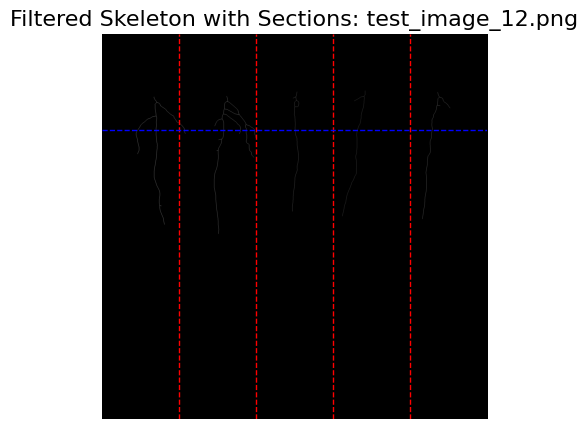

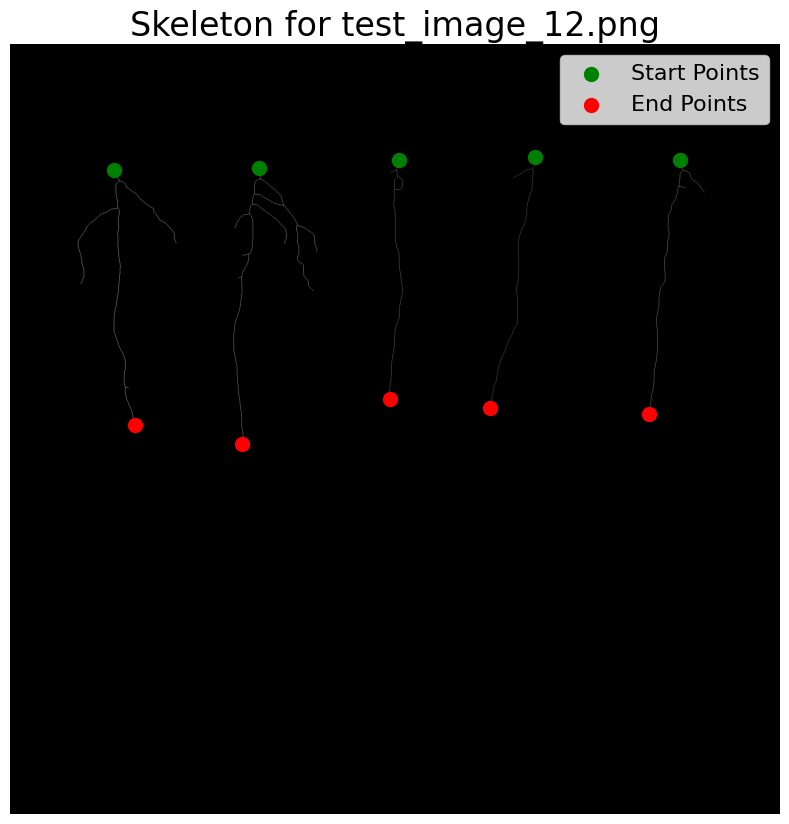

Processing test_image_1.png...


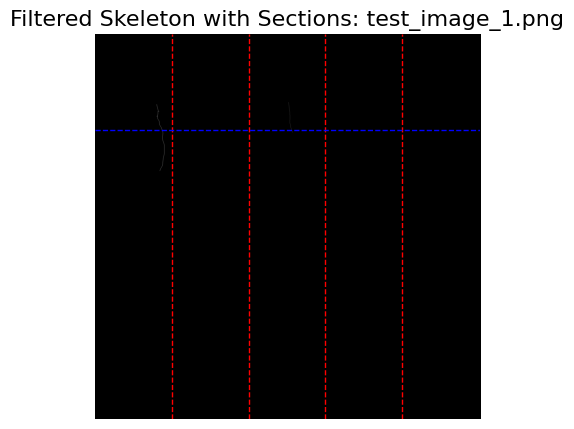

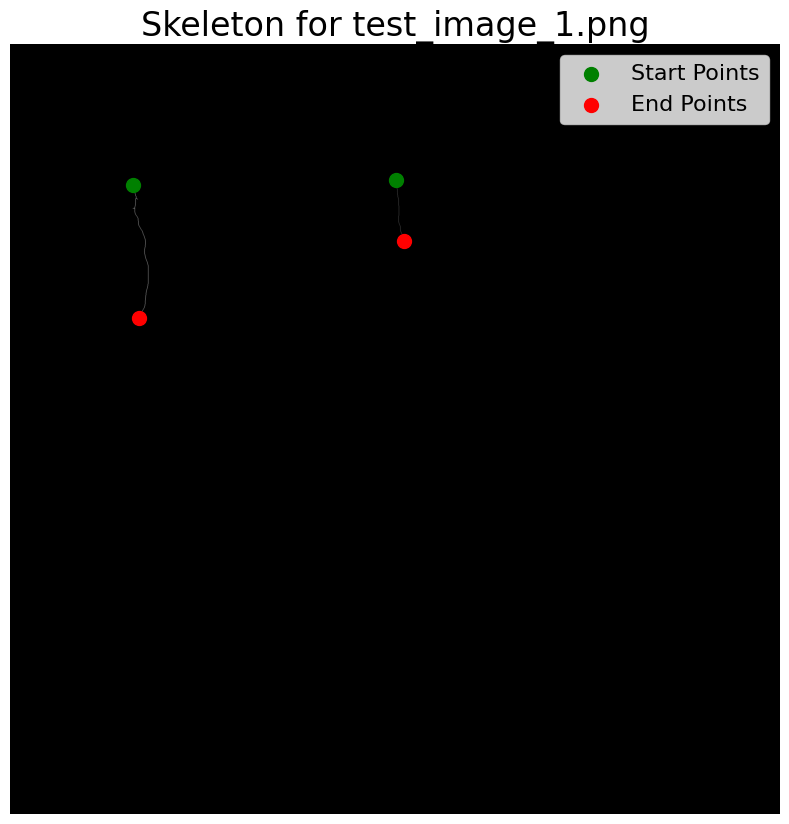

Processing test_image_10.png...


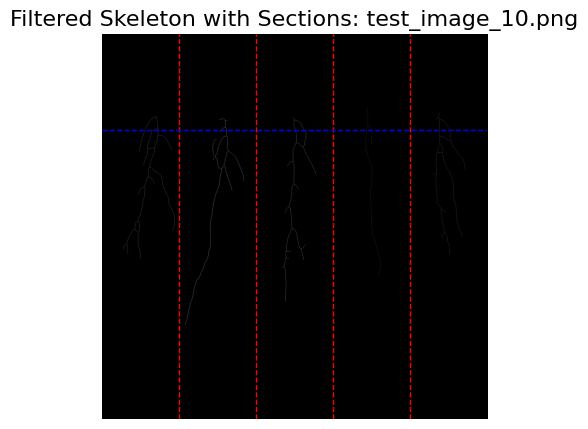

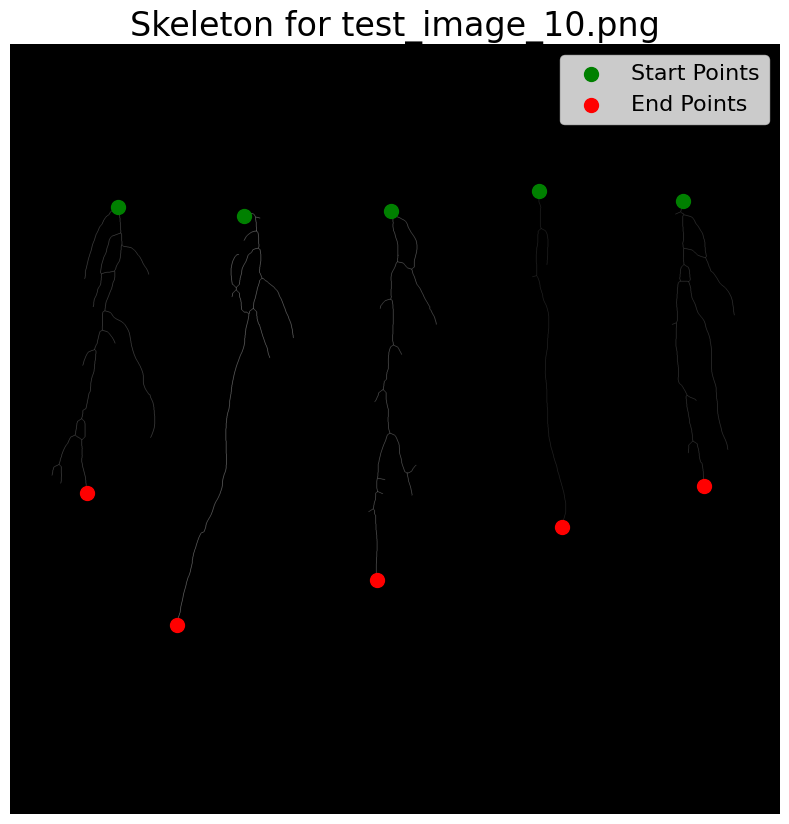

Processing test_image_4.png...


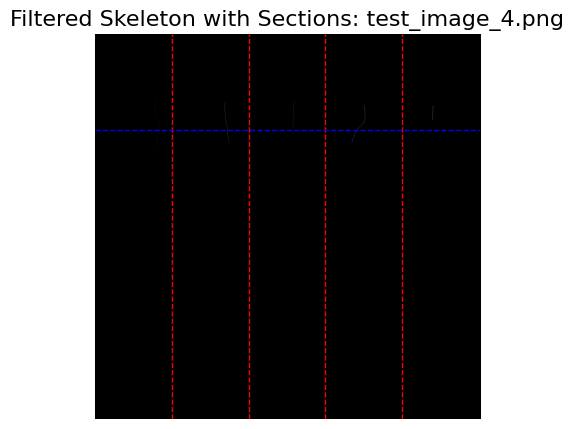

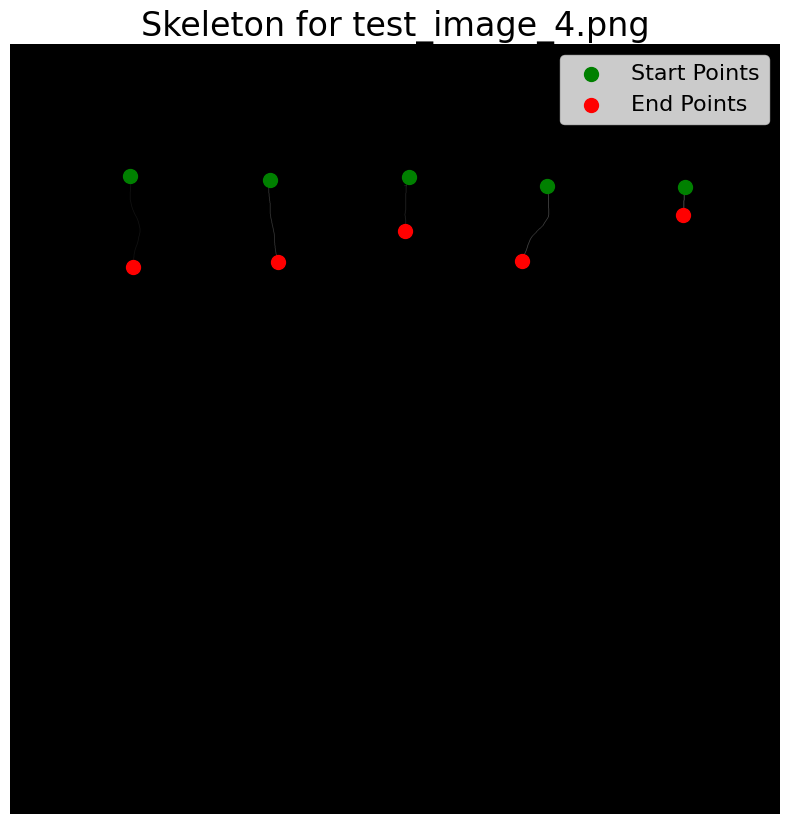

Processing test_image_3.png...


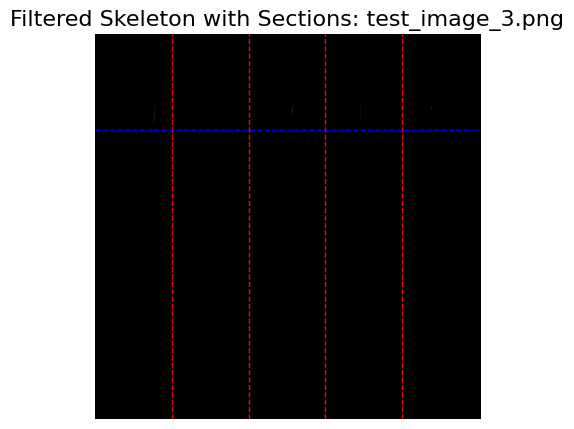

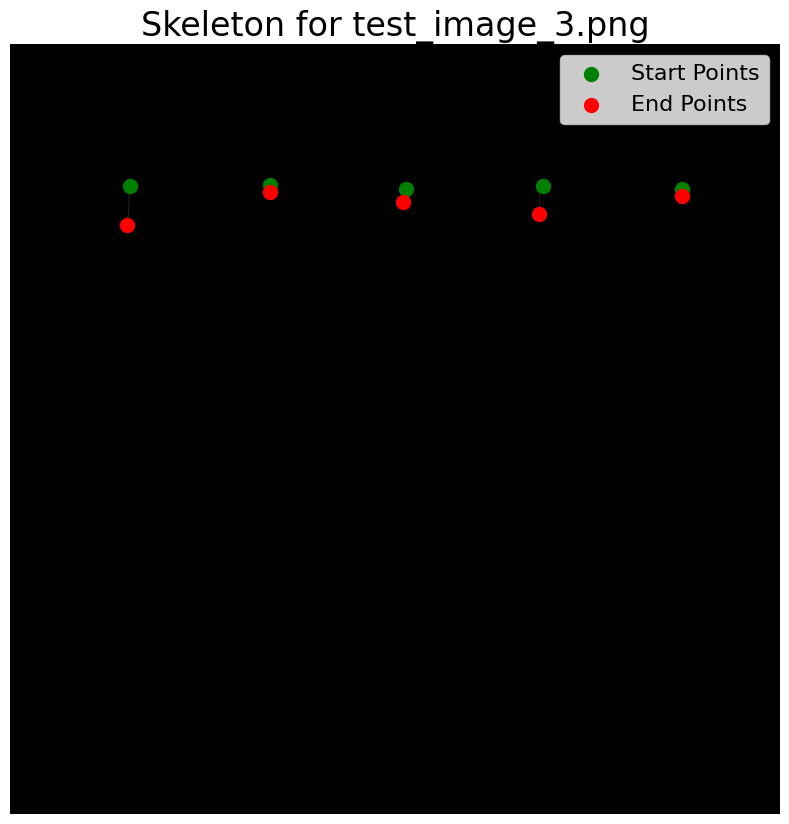

Processing test_image_14.png...


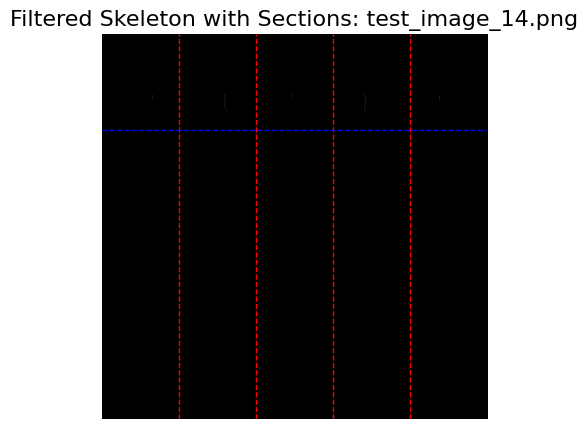

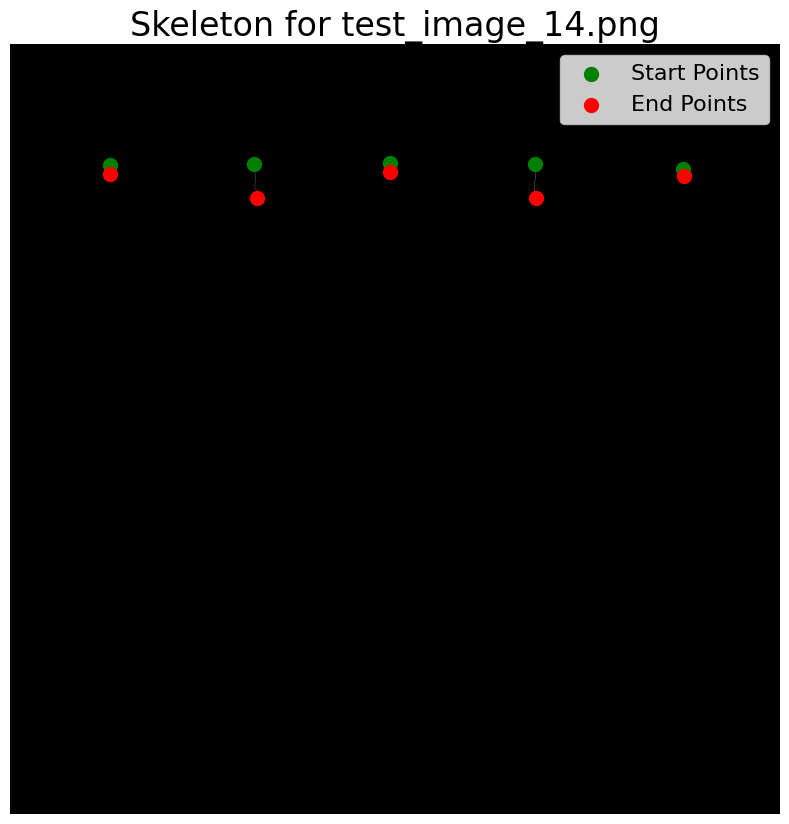

Processing test_image_8.png...


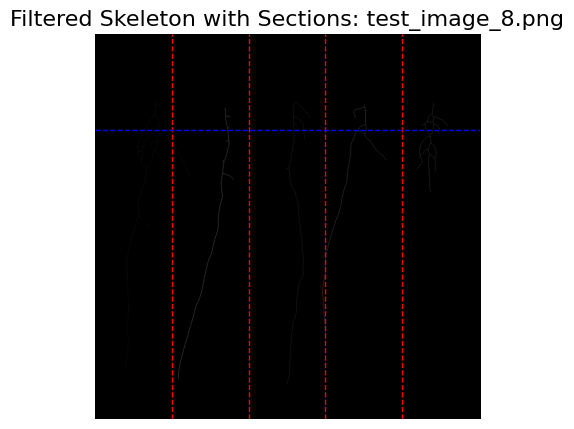

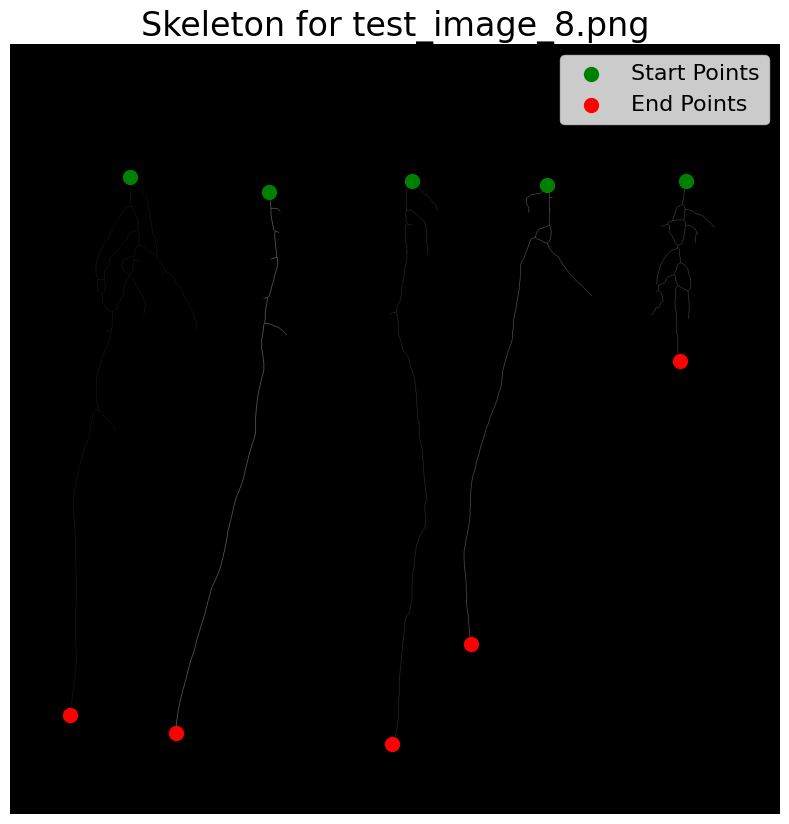

Processing test_image_11.png...


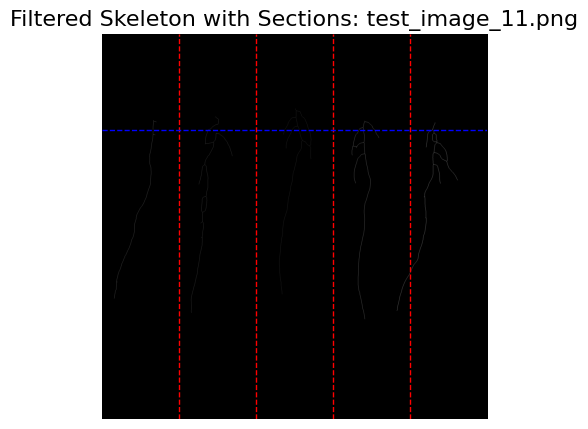

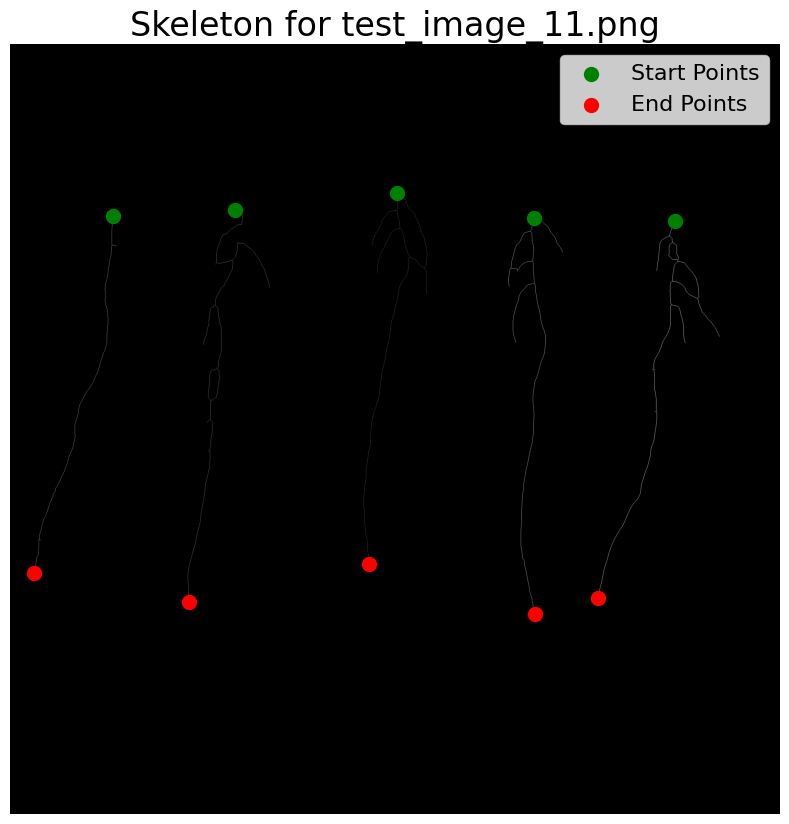

Processing test_image_9.png...


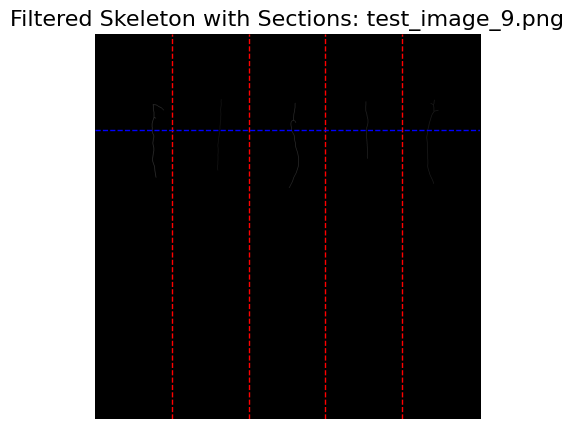

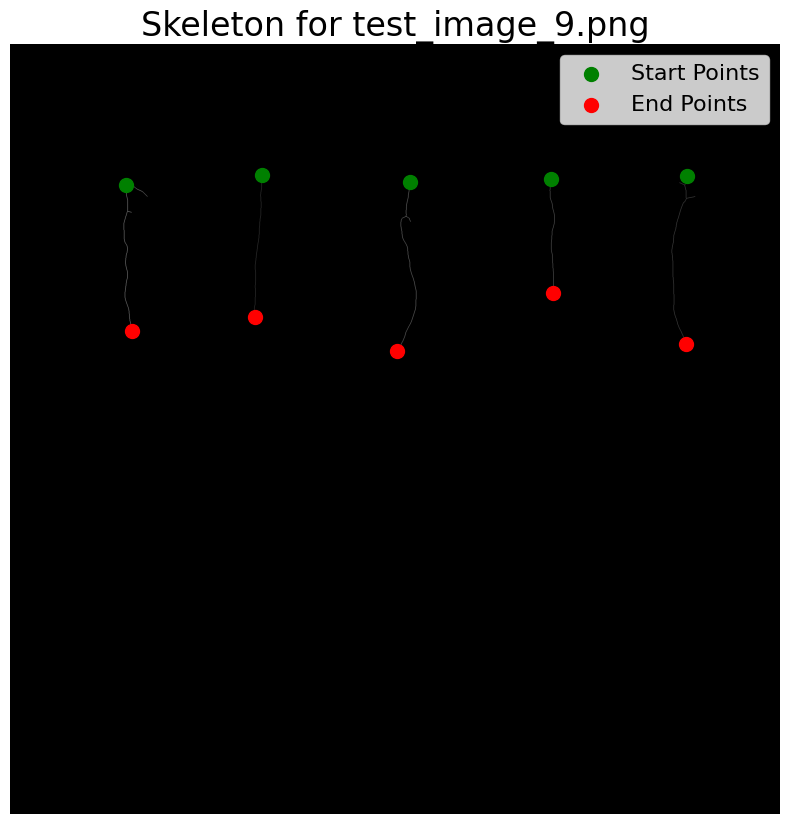

Processing test_image_15.png...


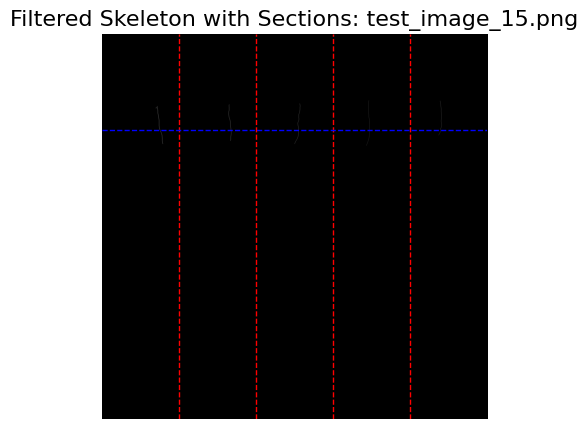

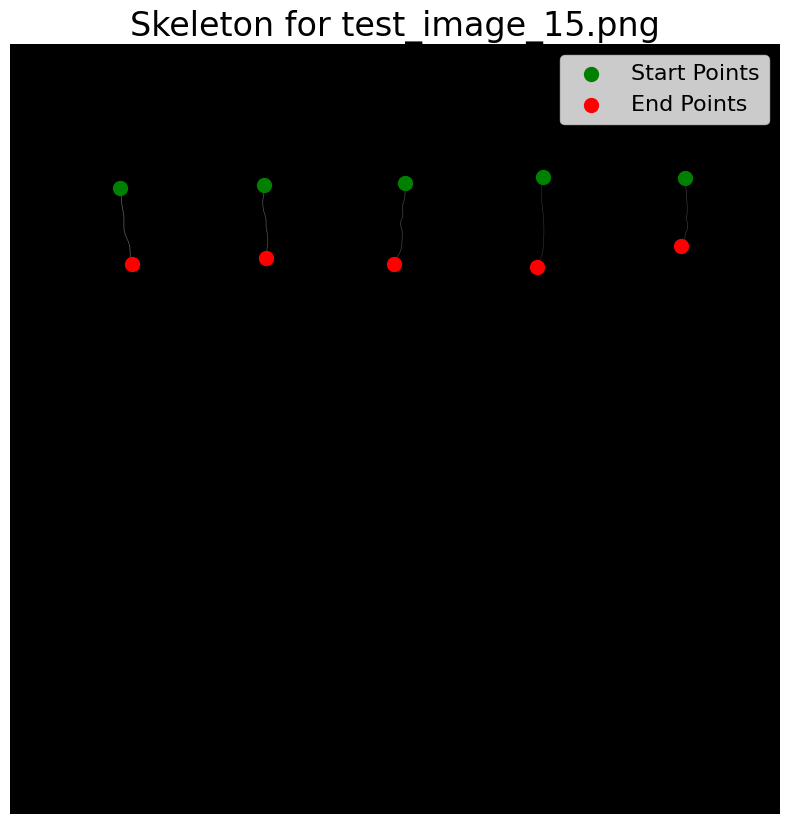

Processing test_image_2.png...


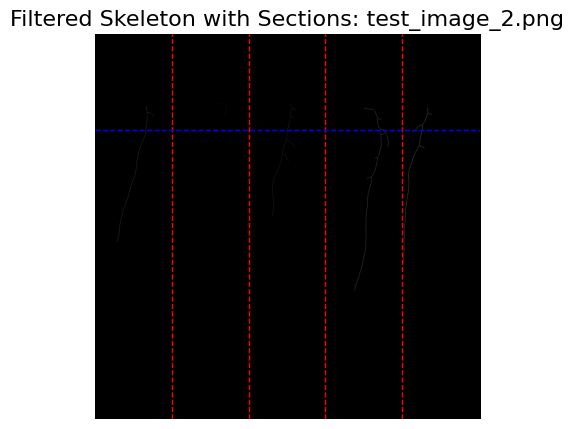

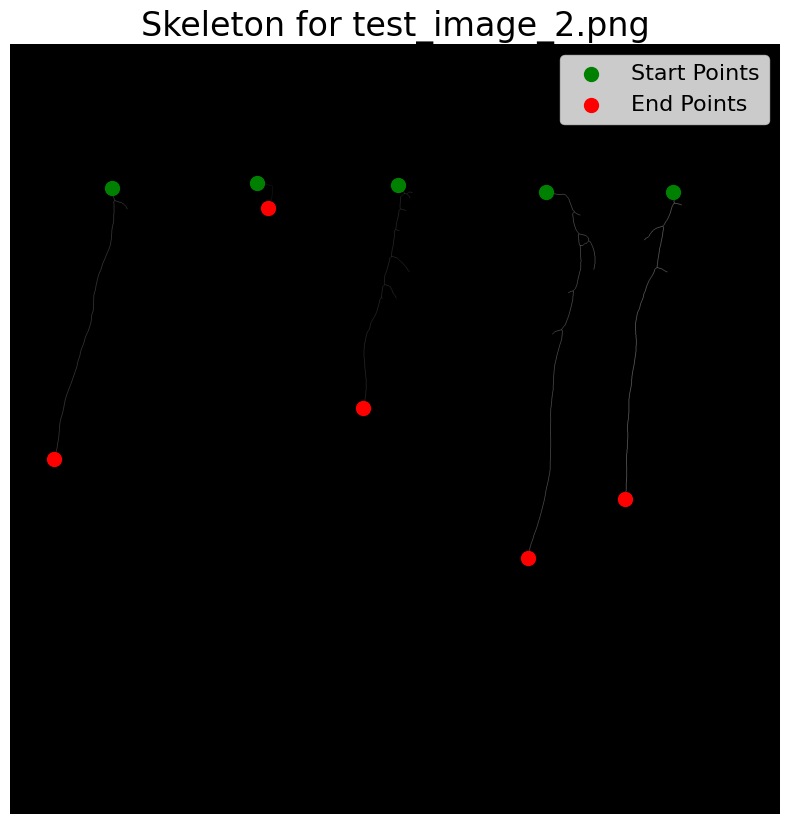

Processing test_image_6.png...


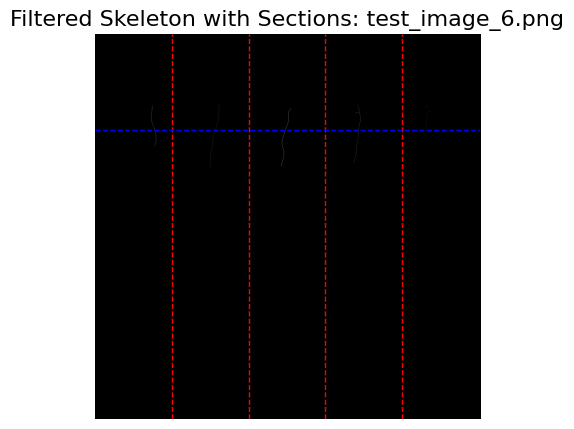

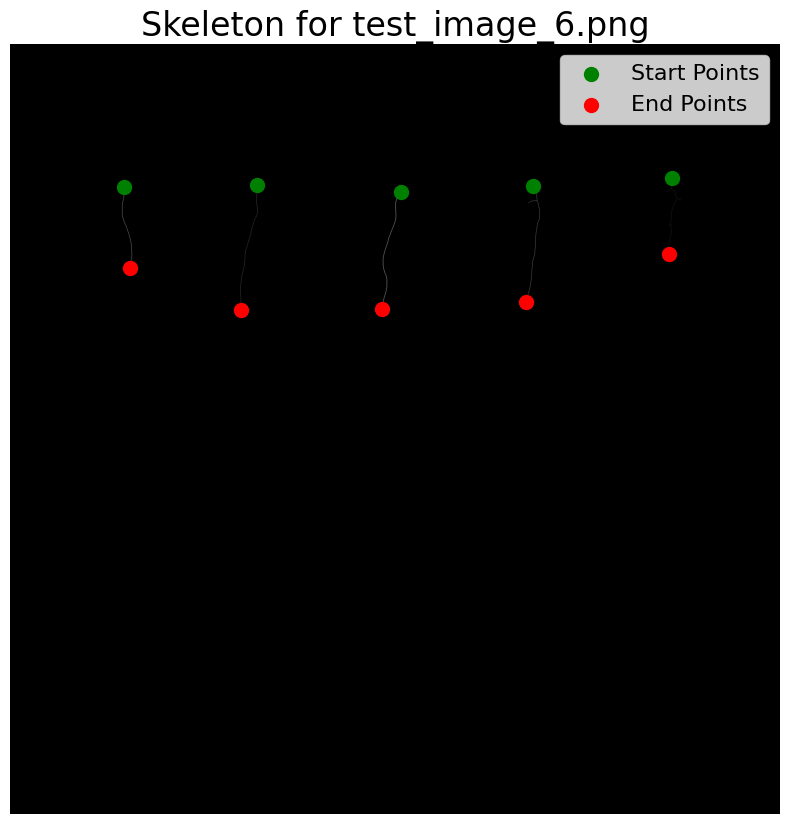

Processing test_image_18.png...


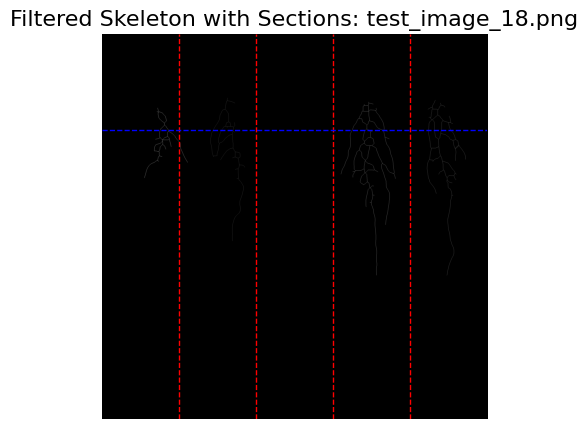

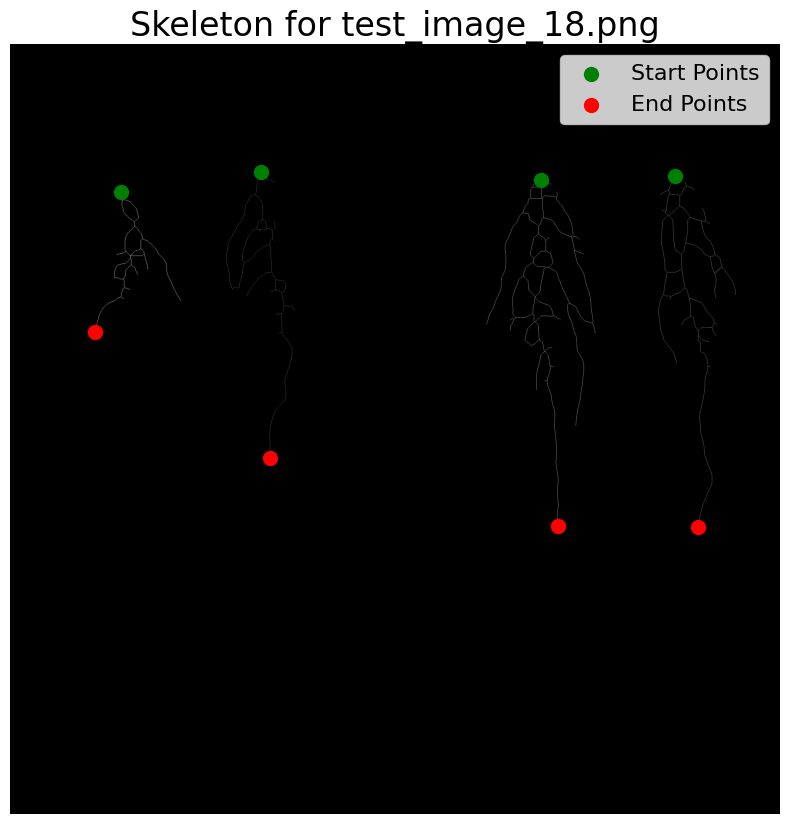

Processing test_image_16.png...


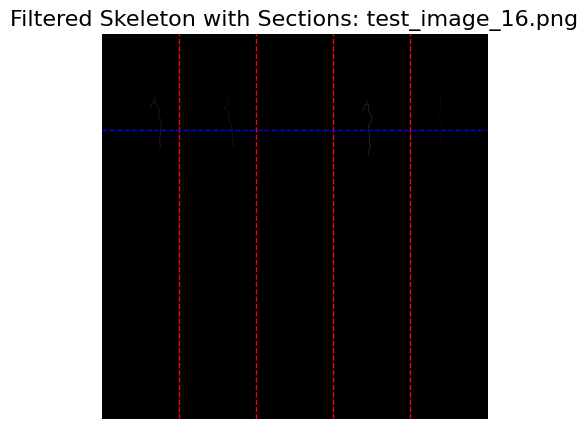

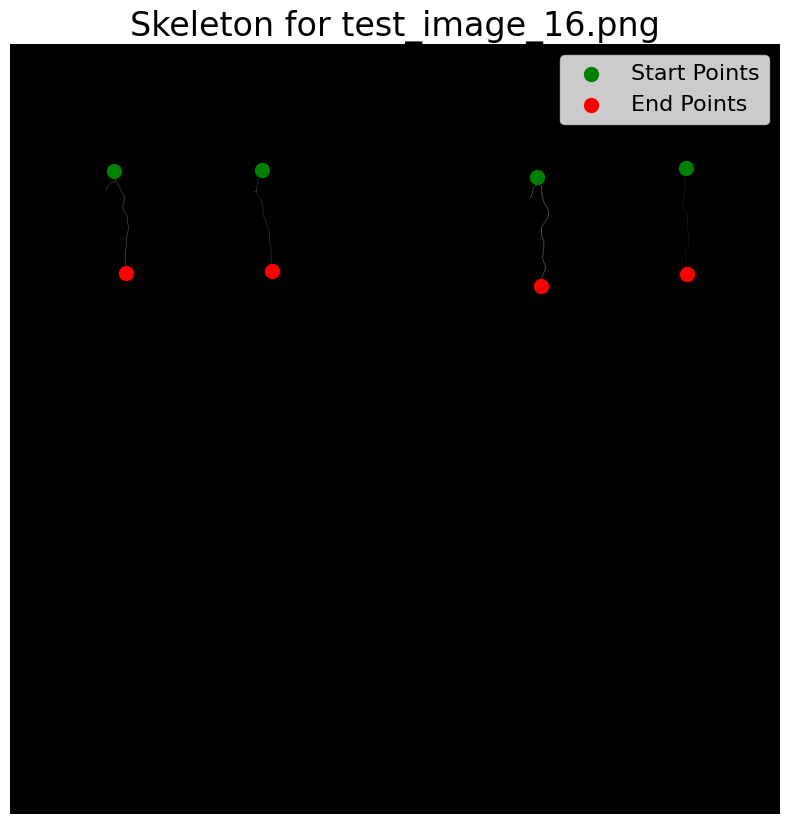

Processing test_image_7.png...


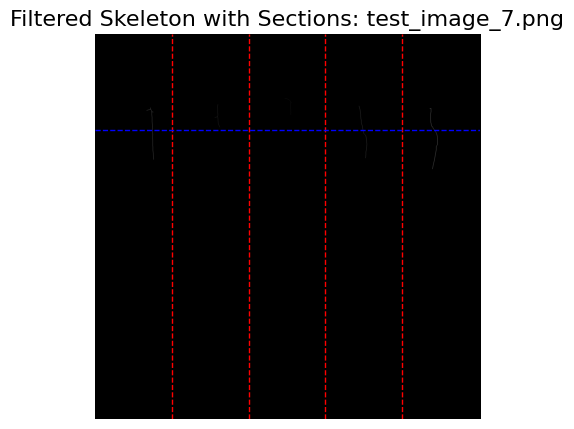

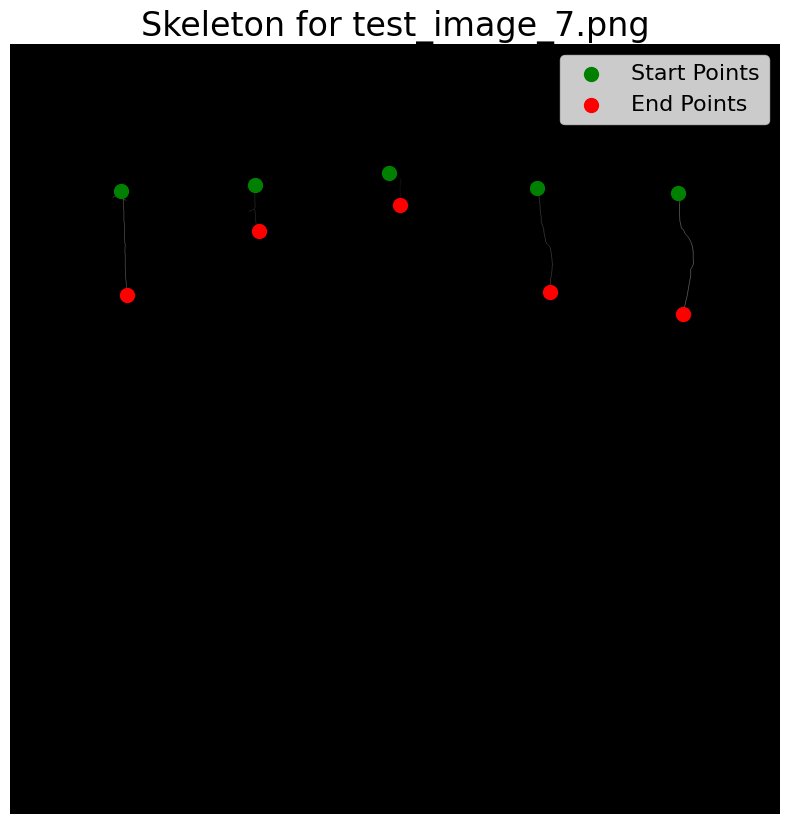

    skeleton-id           filename  start_y  start_x   end_y   end_x  \
0             0  test_image_13.png    473.0   2466.0  1907.0  2316.0   
1             1  test_image_13.png    475.0   1450.0  1527.0  1317.0   
2             2  test_image_13.png    476.0   1947.0  1749.0  1958.0   
3             3  test_image_13.png    482.0    892.0  1615.0   927.0   
4             4  test_image_13.png    494.0    391.0  1830.0   357.0   
..          ...                ...      ...      ...     ...     ...   
80            0   test_image_7.png    471.0   1384.0   590.0  1427.0   
81            1   test_image_7.png    514.0    897.0   682.0   910.0   
82            2   test_image_7.png    525.0   1926.0   907.0  1973.0   
83            3   test_image_7.png    538.0    406.0   918.0   427.0   
84            4   test_image_7.png    546.0   2442.0   987.0  2461.0   

    path_length  
0   1537.955411  
1   1137.014285  
2   1355.043723  
3   1199.646753  
4   1456.967604  
..          ...  
80   154.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx

# Process skeletonization and extract data for each binary connected component
all_start_end_data = []

for filename, binary_labels in processed_masks:
    print(f"Processing {filename}...")

    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)

    # Step 2: Label connected components
    labeled_roots = label(skeleton_object)

    # Step 3: Define the horizontal line at the top 25% of the height
    top_limit_y = int(binary_labels.shape[0] * 0.25)

    top_limit_y_adjustment = [int(binary_labels.shape[0] * 0.10)if _ in [0,4] else 0 for _ in range(5)]
    top_limit_x_adjustment = [int(binary_labels.shape[1] * 0.08)if _ in [4] else 0 for _ in range(5)]

    # Step 4: Divide the image into 5 vertical sections and retain the largest component in the top part of each sector
    section_width = binary_labels.shape[1] // 5
    filtered_roots = np.zeros_like(labeled_roots)

    for sector_id in range(5):
        x_start = sector_id * section_width
        x_end = (sector_id + 1) * section_width if sector_id < 4 else binary_labels.shape[1] - top_limit_x_adjustment[sector_id]  # decrease

        # Get the components in the top 25% of the sector
        sector_mask_top = labeled_roots[:top_limit_y, x_start:x_end]
        sector_labels_top = np.unique(sector_mask_top[sector_mask_top > 0])  # Exclude background

        # Find the largest component in the top part of the sector
        max_area = 0
        largest_label_top = 0
        for label_id in sector_labels_top:
            area = np.sum(labeled_roots[top_limit_y_adjustment[sector_id]:top_limit_y  :] == label_id)  # Count all pixels for the label in the top part
            if area > max_area:
                max_area = area
                largest_label_top = label_id

        # Retain the largest component in the top part of this sector
        if largest_label_top > 0:
            filtered_roots[labeled_roots == largest_label_top] = largest_label_top

    # Step 5: Remove neighboring roots on the x and y axes within specified thresholds and retain the larger one
    unique_labels = np.unique(filtered_roots[filtered_roots > 0])
    to_remove = set()

    # Define thresholds for proximity in x and y axes
    x_threshold = 100
    y_threshold = 200

    for label_id in unique_labels:
        coords = np.column_stack(np.where(filtered_roots == label_id))
        for other_label in unique_labels:
            if label_id == other_label or other_label in to_remove:
                continue

            other_coords = np.column_stack(np.where(filtered_roots == other_label))
            if any(abs(coord1[1] - coord2[1]) <= x_threshold and abs(coord1[0] - coord2[0]) <= y_threshold \
                   for coord1 in coords for coord2 in other_coords):
                # Compare the areas of the two labels
                area_label_id = np.sum(filtered_roots == label_id)
                area_other_label = np.sum(filtered_roots == other_label)

                if area_label_id >= area_other_label:
                    to_remove.add(other_label)
                else:
                    to_remove.add(label_id)
                    break

    for label_id in to_remove:
        filtered_roots[filtered_roots == label_id] = 0

    # Step 6: Plot filtered roots with sections and the horizontal line
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(filtered_roots, cmap="gray")

    # Draw vertical lines to indicate sections
    for i in range(1, 5):  # 4 lines divide into 5 sections
        x = i * section_width
        ax.axvline(x=x, color="red", linestyle="--", linewidth=1)

    # Draw the horizontal line at 35% of the height
    ax.axhline(y=top_limit_y, color="blue", linestyle="--", linewidth=1)

    ax.set_title(f"Filtered Skeleton with Sections: {filename}", fontsize=16)
    ax.axis("off")
    plt.show()

    # Step 7: Summarize the skeleton
    skeleton_data = Skeleton(filtered_roots)
    branch_data = summarize(skeleton_data)

    # Step 8: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data, 
        source='node-id-src', 
        target='node-id-dst', 
        edge_attr='branch-distance'
    )

    # Step 9: Extract start and end points of the skeleton
    results = []
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Start point (minimum y-coordinate)
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        start_y = start_branch[["image-coord-src-0", "image-coord-dst-0"]].min()
        start_x = start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()]

        # End point (maximum y-coordinate)
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]
        end_y = end_branch[["image-coord-src-0", "image-coord-dst-0"]].max()
        end_x = end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()]

        results.append({
            "skeleton-id": skeleton_id,
            "filename": filename,
            "start_y": start_y,
            "start_x": start_x,
            "end_y": end_y,
            "end_x": end_x
        })

    # Convert results to a DataFrame
    start_end_df = pd.DataFrame(results)

    # Step 10: Map coordinates to nodes and compute shortest paths
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    path_lengths = []
    for _, row in start_end_df.iterrows():
        src_node = coordinate_to_node.get((row['start_y'], row['start_x']), None)
        dst_node = coordinate_to_node.get((row['end_y'], row['end_x']), None)

        if src_node is not None and dst_node is not None and src_node in G.nodes and dst_node in G.nodes:
            try:
                path_len = nx.dijkstra_path_length(G, src_node, dst_node, weight='branch-distance')
                path_lengths.append(path_len)
            except nx.NetworkXNoPath:
                path_lengths.append(None)
        else:
            path_lengths.append(None)

    start_end_df['path_length'] = path_lengths
    all_start_end_data.append(start_end_df)

    # Visualize skeleton with start and end points
    plt.figure(figsize=(15, 10))
    plt.title(f"Skeleton for {filename}", fontsize=24)
    plt.imshow(filtered_roots, cmap='gray')  # Updated to display filtered_roots
    plt.scatter(start_end_df["start_x"], start_end_df["start_y"], color='green', label='Start Points', s=100)
    plt.scatter(start_end_df["end_x"], start_end_df["end_y"], color='red', label='End Points', s=100)
    plt.legend(fontsize=16)
    plt.axis("off")
    plt.show()

# Combine all results into a single DataFrame
final_data = pd.concat(all_start_end_data, ignore_index=True)

# Display the final results
print(final_data)


In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx
import numpy as np
from patchify import unpatchify

# Iterate through preprocessed data
patch_size = 256
for filename, patches_normalized in preprocessed_data:
    print(f"Processing {filename}...")

    # Step 1: Reconstruct the full image from patches
    num_patches = int(np.sqrt(len(patches_normalized)))  # Assuming square grid
    predicted_patches = np.array(patches_normalized).reshape(num_patches, num_patches, patch_size, patch_size)
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    full_image = unpatchify(predicted_patches, petri_dish_padded_shape)

    # Step 2: Skeletonize the image
    skeleton = skeletonize(full_image > 0)  # Ensure binary threshold

    # Step 3: Summarize the skeleton
    skeleton_data = Skeleton(skeleton)
    branch_data = summarize(skeleton_data)

    # Step 4: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data,
        source='node-id-src',
        target='node-id-dst',
        edge_attr='branch-distance'
    )

    # Step 5: Map coordinates to nodes
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    # Step 6: Extract start and end nodes for each skeleton
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Top and bottom nodes
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]

        top_node = (
            start_branch[["image-coord-src-0", "image-coord-dst-0"]].min(),
            start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[
                start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()
            ]
        )
        bottom_node = (
            end_branch[["image-coord-src-0", "image-coord-dst-0"]].max(),
            end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[
                end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()
            ]
        )

        # Map to graph nodes
        src_node = coordinate_to_node.get((int(top_node[0]), int(top_node[1])), None)
        dst_node = coordinate_to_node.get((int(bottom_node[0]), int(bottom_node[1])), None)

        if src_node and dst_node:
            try:
                path = nx.shortest_path(G, src_node, dst_node, weight='branch-distance')

                # Draw path on image
                overlay_image = cv2.cvtColor((full_image * 255).astype('uint8'), cv2.COLOR_GRAY2RGB)
                for i in range(len(path) - 1):
                    node_start = [k for k, v in coordinate_to_node.items() if v == path[i]][0]
                    node_end = [k for k, v in coordinate_to_node.items() if v == path[i + 1]][0]

                    cv2.line(
                        overlay_image,
                        (int(node_start[1]), int(node_start[0])),
                        (int(node_end[1]), int(node_end[0])),
                        (255, 0, 0),  # Red color for path
                        thickness=1
                    )

                # Display the overlay
                plt.figure(figsize=(10, 10))
                plt.title(f"Path Overlay for {filename}")
                plt.imshow(overlay_image)
                plt.axis("off")
                plt.show()

            except nx.NetworkXNoPath:
                print(f"No path found for skeleton {skeleton_id} in {filename}")
        else:
            print(f"Invalid nodes for skeleton {skeleton_id} in {filename}")


In [24]:
final_data.head(5)

skeleton-id           filename  start_y  start_x   end_y   end_x  \
0            0  test_image_13.png    473.0   2466.0  1907.0  2316.0   
1            1  test_image_13.png    475.0   1450.0  1527.0  1317.0   
2            2  test_image_13.png    476.0   1947.0  1749.0  1958.0   
3            3  test_image_13.png    482.0    892.0  1615.0   927.0   
4            4  test_image_13.png    494.0    391.0  1830.0   357.0   

   path_length  
0  1537.955411  
1  1137.014285  
2  1355.043723  
3  1199.646753  
4  1456.967604

In [25]:
import numpy as np
import pandas as pd

# Initialize results
results = []

# Define the number of sectors (5) and calculate sector boundaries
num_sectors = 5
image_width = final_data["start_x"].max() + 1  # Assuming start_x represents horizontal pixel positions
sector_width = image_width // num_sectors

# Group by filename and process each group
for filename, group in final_data.groupby("filename"):
    # Create an array to store lengths for each sector
    sector_lengths = [0] * num_sectors

    # Assign roots to sectors based on their start_x position
    for _, row in group.iterrows():
        sector_index = int(row["start_x"] // sector_width)  # Determine the sector based on start_x
        sector_index = min(sector_index, num_sectors - 1)  # Ensure it's within bounds (sector 0 to 4)
        path_length = round(row["path_length"])
        sector_lengths[sector_index] = path_length  # Store the length for the corresponding sector

    # Add results for each sector (plant ID 1 to 5)
    for plant_id in range(1, num_sectors + 1):
        results.append([f"{filename[:-4]}_plant_{plant_id}", sector_lengths[plant_id - 1]])

# Convert results to DataFrame for submission
submission_df = pd.DataFrame(results, columns=["Plant ID","Length (px)"])

# Save to CSV


In [26]:
submission_df.head(50)

Plant ID  Length (px)
0    test_image_1_plant_1          532
1    test_image_1_plant_2            0
2    test_image_1_plant_3          235
3    test_image_1_plant_4            0
4    test_image_1_plant_5            0
5   test_image_10_plant_1         1152
6   test_image_10_plant_2         1697
7   test_image_10_plant_3         1455
8   test_image_10_plant_4         1306
9   test_image_10_plant_5         1132
10  test_image_11_plant_1         1440
11  test_image_11_plant_2         1692
12  test_image_11_plant_3         1464
13  test_image_11_plant_4         1547
14  test_image_11_plant_5         1541
15  test_image_12_plant_1         1011
16  test_image_12_plant_2         1086
17  test_image_12_plant_3          954
18  test_image_12_plant_4          994
19  test_image_12_plant_5          994
20  test_image_13_plant_1         1457
21  test_image_13_plant_2         1200
22  test_image_13_plant_3         1137
23  test_image_13_plant_4         1355
24  test_image_13_plant_5         1538
25  test_image_14_plant_1           34
26  test_image_14_plant_2          134
27  test_image_14_plant_3           35
28  test_image_14_plant_4          130
29  test_image_14_plant_5           28
30  test_image_15_plant_1          295
31  test_image_15_plant_2          279
32  test_image_15_plant_3          319
33  test_image_15_plant_4          347
34  test_image_15_plant_5          269
35  test_image_16_plant_1          412
36  test_image_16_plant_2          399
37  test_image_16_plant_3            0
38  test_image_16_plant_4          445
39  test_image_16_plant_5          408
40  test_image_17_plant_1          628
41  test_image_17_plant_2          688
42  test_image_17_plant_3          792
43  test_image_17_plant_4          821
44  test_image_17_plant_5          764
45  test_image_18_plant_1          643
46  test_image_18_plant_2         1192
47  test_image_18_plant_3            0
48  test_image_18_plant_4         1409
49  test_image_18_plant_5         1435

In [27]:
submission_df.to_csv("submission_18_01_02.csv", index=False, header=False)

# Print a preview of the submission file
print(submission_df.head(25))


                 Plant ID  Length (px)
0    test_image_1_plant_1          532
1    test_image_1_plant_2            0
2    test_image_1_plant_3          235
3    test_image_1_plant_4            0
4    test_image_1_plant_5            0
5   test_image_10_plant_1         1152
6   test_image_10_plant_2         1697
7   test_image_10_plant_3         1455
8   test_image_10_plant_4         1306
9   test_image_10_plant_5         1132
10  test_image_11_plant_1         1440
11  test_image_11_plant_2         1692
12  test_image_11_plant_3         1464
13  test_image_11_plant_4         1547
14  test_image_11_plant_5         1541
15  test_image_12_plant_1         1011
16  test_image_12_plant_2         1086
17  test_image_12_plant_3          954
18  test_image_12_plant_4          994
19  test_image_12_plant_5          994
20  test_image_13_plant_1         1457
21  test_image_13_plant_2         1200
22  test_image_13_plant_3         1137
23  test_image_13_plant_4         1355
24  test_image_13_plant_5